In [39]:
import numpy as np
import pandas as pd
from reskit.core import DataTransformer, MatrixTransformer, Pipeliner
import matplotlib.pyplot as plt
import igraph as ig
import community
import networkx as nx
from data_load import load_data

%matplotlib inline

In [40]:
import os
import pickle
from scipy.spatial.distance import squareform
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA

In [41]:
path = '/home/bgutman/datasets/HCP/'

In [42]:
connec, think, log_jac, uniq_labels, mean_labels, mean_area_eq, subj_idx = load_data(path)

Connectomes:  (789, 2, 68, 68)
Thinkness:  (789, 2, 163842)
Log Jacob:  (789, 2, 163842)
Unique Labels:  (789, 2, 163842)
Mean Labels:  (2, 163842)
Mean Area eq:  (2, 163842)


In [43]:
mean_area = np.multiply(np.exp(log_jac), mean_area_eq.reshape(1,2,-1))

In [45]:
with open("/cobrain/groups/ml_group/data/HCP/cleaned_data/mean_mesh_labels", 'wb') as f:
    pickle.dump(mean_labels, f)

In [44]:
with open("/cobrain/groups/ml_group/data/HCP/cleaned_data/subjects_mesh_labels", 'wb') as f:
    pickle.dump(uniq_labels, f)

In [44]:
with open("/cobrain/groups/ml_group/data/HCP/cleaned_data/subjects_mesh_area", 'wb') as f:
    pickle.dump(mean_area, f)

In [38]:
with open("/cobrain/groups/ml_group/data/HCP/cleaned_data/subj_idx", 'wb') as f:
    pickle.dump(subj_idx, f)

In [39]:
with open("/cobrain/groups/ml_group/data/HCP/cleaned_data/subjects_thinkness", 'wb') as f:
    pickle.dump(think, f)

In [40]:
with open("/cobrain/groups/ml_group/data/HCP/cleaned_data/subjects_log_jac", 'wb') as f:
    pickle.dump(log_jac, f)

In [7]:
mean_labels = np.array(list(mean_labels[0]) + list(mean_labels[1]))
mean_labels.shape

(327684,)

In [8]:
idx = np.array(list(range(3)) + list(range(4,38)) + list(range(39, 70))) + 1
idx

array([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70])

In [9]:
mean_num_roi = np.array([len(np.where(mean_labels == i)[0]) for i in idx])

In [10]:
mean_num_roi

array([ 2096,  1383,  3709,  1635,   792,  4751,  7861,  4412,  2944,
        6353,  4178,  4193,  3301,  4484,  1619,  3301,  3069,   942,
        2035,  1890,  9486,  3291, 10773,  7319,  1381,  7317, 12174,
       10471,  7297,  8629,   265,   806,  1033,  5910,  2150,  1660,
        3515,  1656,   661,  4647,  9668,  4199,  2777,  5970,  4462,
        3916,  2784,  5073,  1451,  3804,  2482,   940,  2364,  1811,
        9125,  3014, 10733,  7995,  1085,  7873, 11917, 10217,  6868,
        8166,   376,   750,   764,  6337])

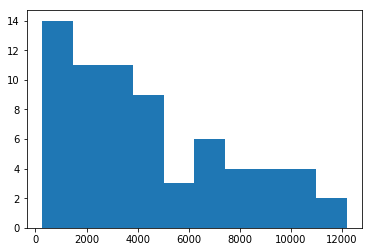

In [11]:
plt.hist(mean_num_roi);

In [12]:
mean_area_eq = np.array(list(mean_area_eq[0]) + list(mean_area_eq[1]))
mean_area_eq.shape

(327684,)

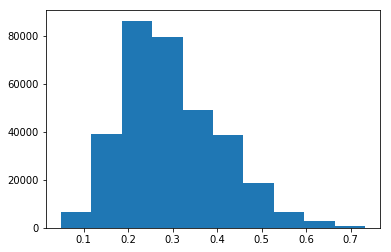

In [13]:
plt.hist(mean_area_eq);

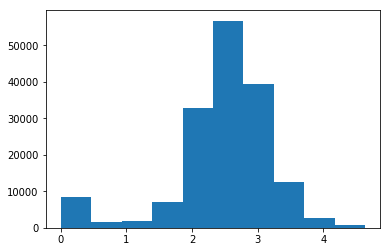

In [14]:
plt.hist(think[0][0]);

In [15]:
from collections import Counter

In [16]:
def counter_mean_area_thinkness_and_size_of_roi(thinkness, unique_labels):
    un_mean_think = []
    un_num_roi = []
    for l, one in enumerate(thinkness):
        un_label = np.array(list(unique_labels[l][0]) + list(unique_labels[l][1]))
        
        counter = Counter()
        counter.update(un_label)
        t = np.array([v for k, v in sorted(counter.items()) if k!= 0])
        
        un_num_roi += [t]

        one_think = np.array(list(one[0]) + list(one[1]))
        one_think = np.where(one_think < 0, 0, one_think)
        df = pd.DataFrame(data = np.concatenate((one_think[:, np.newaxis], un_label[:, np.newaxis]), axis=1))
        mean_area = df.groupby(by=df[1], axis =0,).mean()[1:]

        un_mean_think += [np.array(mean_area).reshape(-1)]
    return np.array(un_mean_think), np.array(un_num_roi)

In [17]:
un_mean_think,un_num_roi = counter_mean_area_thinkness_and_size_of_roi(think, uniq_labels)

In [20]:
with open("/cobrain/groups/ml_group/data/HCP/cleaned_data/subjects_roi_thinkness", 'wb') as f:
    pickle.dump(un_mean_think, f)

In [16]:
un_mean_think.shape, un_num_roi.shape

((789, 68), (789, 68))

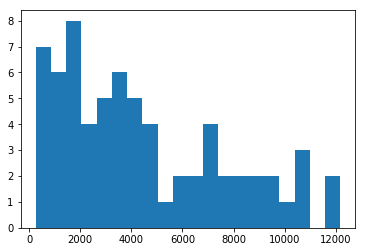

In [17]:
plt.hist(un_num_roi.sum(axis=0)/len(un_mean_think), bins=20);

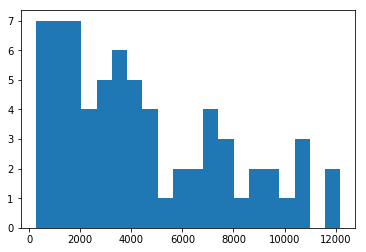

In [271]:
plt.hist(mean_num_roi, bins = 20);

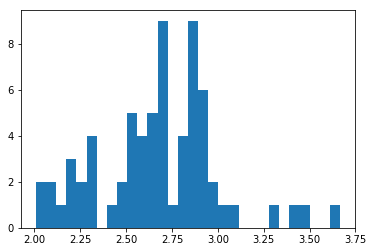

In [272]:
plt.hist(un_mean_think.mean(axis = 0), bins = 30);

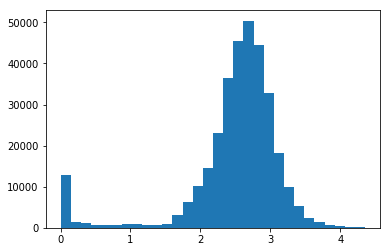

In [273]:
plt.hist(think.reshape(len(think), -1).mean(axis = 0), bins = 30);

In [51]:
bin_connec = connec[:,1,:,:].copy()
bin_connec[bin_connec > 0] = 1

In [52]:
freq_edges  = squareform(bin_connec.mean(axis = 0))
mean_weight = squareform(connec[:,1,:,:].mean(axis = 0))

In [53]:
perc_edges = np.percentile(freq_edges, 10)

In [54]:
perc_edges

0.46864727139472961

In [55]:
bin_connec[:,:,:].mean(axis = 0).shape

(68, 68)

In [68]:
mean_bin = bin_connec[:,:,:].mean(axis = 0) 

In [75]:
min(squareform(mean_bin))

0.017699115

In [76]:
mean_bin_per = mean_bin.copy()
mean_bin_per[mean_bin_per < perc_edges] = 0
mean_bin_per[mean_bin_per > perc_edges] = 1



In [21]:
def clear_connec(connectomes):
    bin_connectomes = connectomes.copy()
    bin_connectomes[bin_connectomes > 0] = 1
    freq_mat = bin_connectomes.mean(axis = 0)
    
    freq_edges = squareform(freq_mat)
    perc_edges = np.percentile(freq_edges, 10)
    
    new_connectomes = []
    for one in connectomes:
        t = one.copy()
        t[freq_mat < perc_edges] = 0.
        new_connectomes += [t]
    
    return np.array(new_connectomes)

In [23]:
not_normed_connec = clear_connec(connec[:, 0, :,:])

In [32]:
normed_connec = clear_connec(connec[:,1,:,:])

In [33]:
with open("/cobrain/groups/ml_group/data/HCP/cleaned_data/not_normed_connectomes", 'wb') as f:
    pickle.dump(not_normed_connec, f)

In [34]:
with open("/cobrain/groups/ml_group/data/HCP/cleaned_data/normed_connectomes", 'wb') as f:
    pickle.dump(normed_connec, f)

In [35]:
def count_mean_roi_volume(thinkness, un_log_jac, mean_area, unique_labels):
    mean_roi_volume = []
    prod = np.multiply(thinkness, np.multiply(np.exp(un_log_jac), mean_area.reshape(1,2,-1)))
    
    for l, one in enumerate(prod):
        un_label = np.array(list(unique_labels[l][0]) + list(unique_labels[l][1]))
        
        one_think = np.array(list(one[0]) + list(one[1]))
        one_think = np.where(np.array(list(thinkness[l][0]) + list(thinkness[l][0])) < 0, 0, one_think)
        
        df = pd.DataFrame(data = np.concatenate((one_think[:, np.newaxis], un_label[:, np.newaxis]), axis=1))
        mean_vol = df.groupby(by=df[1], axis =0,).mean()[1:]

        mean_roi_volume += [np.array(mean_vol).reshape(-1)]
    
    return np.array(mean_roi_volume)

In [36]:
mean_roi_volume = count_mean_roi_volume(think, log_jac, mean_area_eq, uniq_labels)

In [37]:
with open("/cobrain/groups/ml_group/data/HCP/cleaned_data/subjects_roi_volume", 'wb') as f:
    pickle.dump(mean_roi_volume, f)

In [43]:
mean_roi_volume.shape

(789, 68)

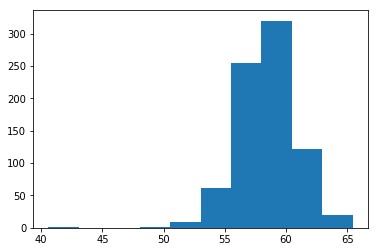

In [16]:
plt.hist(mean_roi_volume.sum(axis = -1));

In [37]:
outlier_by_think = [subj_idx[np.where(mean_roi_volume.sum(axis = -1)< 45)[0]][0]]

In [38]:
outlier_by_think

['257845']

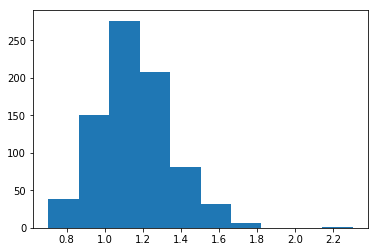

In [39]:
plt.hist(mean_roi_volume[:, 65]);

In [40]:
def outliers_normal(volumes):
    idx_b = np.where(volumes > volumes.mean() + 3*volumes.std())[0]
    idx_l = np.where(volumes < volumes.mean() - 3*volumes.std())[0]
    return np.array(list(idx_l) + list(idx_b))

In [41]:
idx_normal = np.array([])
for i in range(68):
    idx = outliers_normal(mean_roi_volume[:,i])
    #print(i, len(idx))
    idx_normal = np.concatenate((idx_normal, idx))

In [42]:
num_j, count = np.unique(idx_normal, return_counts=True)

In [43]:
outlier_by_think += list(subj_idx[num_j[np.where(count > 10)].astype(int)])

In [44]:
outlier_by_think

['257845', '257845', '671855']

In [177]:
from utils import count_mean_roi_volume, counter_mean_area_thinkness_and_size_of_roi, clear_connec

In [179]:
mean_roi_v = count_mean_roi_volume(think, log_jac, mean_area_eq, uniq_labels)

In [180]:
np.allclose(mean_roi_volume, mean_roi_v)

True

# X = thinkness
# Y = Binary degree of normed connectome

In [13]:
for train_idx, test_idx in split.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = bY[train_idx], bY[test_idx]
    mdl = PLSRegression(n_components=3)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    mse = np.mean((y_pred - y_test)**2)
    ae = np.mean(abs(y_pred - y_test))
    score_train = mdl.score(X_train, y_train)
    score_test = mdl.score(X_test, y_test)
    print('MSE: {}, AE: {}'.format(mse, ae))
    print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))

MSE: 57.26813690875828, AE: 4.818250747930625
R^2 score train: 0.13967647817486167, R^2 score test: 0.026868088858957685
MSE: 48.569512647720344, AE: 4.680657627444928
R^2 score train: 0.15921646206585133, R^2 score test: 0.022068155107856566
MSE: 48.61339785487322, AE: 4.591093092319611
R^2 score train: 0.16236004640495505, R^2 score test: 0.02855172581076263
MSE: 51.29113983052464, AE: 4.706182224040422
R^2 score train: 0.16518201617940884, R^2 score test: 0.014340231711629191
MSE: 51.58720873085003, AE: 4.727366817162571
R^2 score train: 0.15892406358811292, R^2 score test: 0.04264540175079126


In [37]:
np.mean([ 57.26813690875828,48.569512647, 48.61339785, 51.291139, 51.587208])

51.465878881151653

# X =thinkness
# Y = Weighted degree of normed connectome

In [14]:
for train_idx, test_idx in split.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = wY[train_idx], wY[test_idx]
    mdl = PLSRegression(n_components=3)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    mse = np.mean((y_pred - y_test)**2)
    ae = np.mean(abs(y_pred - y_test))
    score_train = mdl.score(X_train, y_train)
    score_test = mdl.score(X_test, y_test)
    print('MSE: {}, AE: {}'.format(mse, ae))
    print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))

MSE: 1581234377.111565, AE: 28472.602731816674
R^2 score train: 0.6709671105915991, R^2 score test: -0.17967228503389066
MSE: 1455427383.0756278, AE: 27395.519608571547
R^2 score train: 0.6821508306736095, R^2 score test: -0.08066351823720246
MSE: 1523628890.946066, AE: 27943.46711949351
R^2 score train: 0.6717274369581133, R^2 score test: -0.18765873195834062
MSE: 1549156404.7576962, AE: 28821.806015741935
R^2 score train: 0.6725044189718838, R^2 score test: -0.22918826449615434
MSE: 1610931976.1872532, AE: 29067.400287419452
R^2 score train: 0.6626449682248144, R^2 score test: -0.2336348714882733


# X = thinkness
# Y = Binary degree of not normed connectome

In [15]:
connec = connectomes[:, 0, :, :]
X = thinkness.reshape(thinkness.shape[0], -1)
bY = to_degree(connec)
wY = to_degree(connec, mode = 'weighted')

In [16]:
for train_idx, test_idx in split.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = bY[train_idx], bY[test_idx]
    mdl = PLSRegression(n_components=3)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    mse = np.mean((y_pred - y_test)**2)
    ae = np.mean(abs(y_pred - y_test))
    score_train = mdl.score(X_train, y_train)
    score_test = mdl.score(X_test, y_test)
    print('MSE: {}, AE: {}'.format(mse, ae))
    print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))

MSE: 57.26813690875828, AE: 4.818250747930625
R^2 score train: 0.13967647817486167, R^2 score test: 0.026868088858957685
MSE: 48.569512647720344, AE: 4.680657627444928
R^2 score train: 0.15921646206585133, R^2 score test: 0.022068155107856566
MSE: 48.61339785487322, AE: 4.591093092319611
R^2 score train: 0.16236004640495505, R^2 score test: 0.02855172581076263
MSE: 51.29113983052464, AE: 4.706182224040422
R^2 score train: 0.16518201617940884, R^2 score test: 0.014340231711629191
MSE: 51.58720873085003, AE: 4.727366817162571
R^2 score train: 0.15892406358811292, R^2 score test: 0.04264540175079126


# X = thinkness 
# Y = weighted degree of not normed connectome

In [17]:
for train_idx, test_idx in split.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = wY[train_idx], wY[test_idx]
    mdl = PLSRegression(n_components=3)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    mse = np.mean((y_pred - y_test)**2)
    ae = np.mean(abs(y_pred - y_test))
    score_train = mdl.score(X_train, y_train)
    score_test = mdl.score(X_test, y_test)
    print('MSE: {}, AE: {}'.format(mse, ae))
    print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))

MSE: 1458979390.2226567, AE: 27447.13941071795
R^2 score train: 0.6678755084629485, R^2 score test: -0.1951190457122126
MSE: 1374602384.1075604, AE: 26341.445829296004
R^2 score train: 0.6768811404816553, R^2 score test: -0.14580881746124866
MSE: 1410207365.929973, AE: 27298.67628733385
R^2 score train: 0.6645312284846157, R^2 score test: -0.16841960287586663
MSE: 1434388117.0590026, AE: 27474.053016624148
R^2 score train: 0.6747317947097818, R^2 score test: -0.1685771816739898
MSE: 1562831659.576293, AE: 28479.711675454364
R^2 score train: 0.6569255721363483, R^2 score test: -0.30569093418612836


In [47]:
fig, ax = plt.subplots(42, 2, figsize = (100,500))
for i in range(42):
    ax[i, 0].hist(tmp[0][i], bins = 30)
    ax[i, 1].hist(tmp[1][i], bins = 30)

In [19]:
np.mean(bY, axis = 0)

array([ 63.10214233,  73.0428772 ,  70.19545746,   0.        ,
        61.24085617,  42.52837372,  70.68726349,  73.04035187,
        73.64691162,  78.29003906,  70.25473022,  69.07187653,
        69.6506958 ,  71.11096954,  74.23203278,  68.49936676,
        69.83354187,  61.79445267,  52.03404617,  64.77931976,
        65.67339325,  69.39722443,  76.00882721,  73.43505859,
        79.12483978,  59.44514465,  77.4161377 ,  78.85372162,
        78.69356537,  75.02774048,  71.40731049,  55.08322906,
        50.59772873,  63.04413605,  77.84867859,  62.82597733,
        74.06557465,  69.24211884,   0.        ,  66.91551208,
        36.74401093,  74.98360443,  72.62042999,  74.96721649,
        78.58007812,  73.29003906,  71.92181396,  74.1853714 ,
        66.7692337 ,  73.25977325,  69.13493347,  71.0668335 ,
        61.35182953,  60.99243546,  63.82597733,  70.36444092,
        70.02269745,  75.21059418,  73.56998444,  79.52207184,
        65.03909302,  77.08197021,  78.81841278,  78.48

In [20]:
np.std(bY, axis = 0)

array([  8.77623463,   5.39259577,   5.06585932,   0.        ,
         9.32156181,  16.13513374,   6.04298067,   4.05179071,
         4.40324783,   2.48407602,   5.46830416,   6.66178846,
         6.66135025,   8.13677692,   3.74086785,   6.51337481,
         6.70265818,   7.46741724,   9.48351383,   6.69045162,
         7.63202143,   5.21830225,   3.53204465,   3.70354724,
         1.83033085,   9.86311817,   2.64089918,   1.66449296,
         2.10701704,   3.82158637,   5.02069521,  11.81864262,
        14.89351654,   9.71260834,   3.01903462,   7.69992352,
         4.48292351,   5.29001284,   0.        ,   8.42782307,
        16.90172005,   4.04245806,   4.0969882 ,   3.78107667,
         2.42910171,   4.51914835,   5.82761526,   4.74650764,
         8.06489658,   4.1370635 ,   6.59899092,   5.7223978 ,
         6.89178181,   7.36971998,   6.39830112,   6.18358374,
         4.62511444,   3.83549404,   3.53086805,   1.86623049,
         8.44009876,   2.70017219,   1.53637815,   2.21

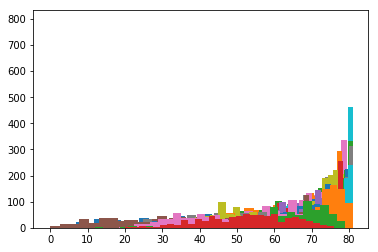

In [21]:
for i in range(84):
    plt.hist(bY.T[i], bins = 30)

In [26]:
connectomes.shape

(793, 2, 84, 84)

In [27]:
connec_without_subcort = connectomes[:, 0, :68,:68]

In [28]:
X = thinkness.reshape(thinkness.shape[0], -1)
bY = to_degree(connec_without_subcort)
wY = to_degree(connec_without_subcort, mode = 'weighted')

In [30]:
bY.shape,wY.shape

((793, 68), (793, 68))

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
sc = StandardScaler()

In [34]:
new_X = sc.fit_transform(X)

In [36]:
for train_idx, test_idx in split.split(new_X):
    X_train, X_test = new_X[train_idx], new_X[test_idx]
    y_train, y_test = bY[train_idx], bY[test_idx]
    mdl = PLSRegression(n_components=3)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    mse = np.mean((y_pred - y_test)**2)
    ae = np.mean(abs(y_pred - y_test))
    score_train = mdl.score(X_train, y_train)
    score_test = mdl.score(X_test, y_test)
    print('MSE: {}, AE: {}'.format(mse, ae))
    print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))

MSE: 37.066928795138224, AE: 3.9422446361236005
R^2 score train: 0.15941300165446498, R^2 score test: 0.02660761499223513


KeyboardInterrupt: 

In [23]:
non_zero = [len(np.where(connectomes[i][0]>0)[0])/2 for i in range(connectomes.shape[0])]

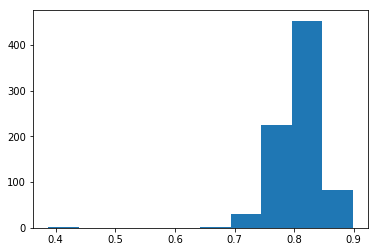

In [24]:
plt.hist(np.array(non_zero)/84/83*2);

In [39]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from IPython.display import clear_output
split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

In [19]:
alpha = [0.1, 1, 10, 50, 100]
alpha

[0.1, 1, 10, 50, 100]

Node number =  0
alpha =  0.1
MSE: 74.31803894042969, AE: 6.947085857391357
R^2 score train: 0.8142438921607971, R^2 score test: -0.0420311536970277
MSE: 94.59902954101562, AE: 7.741881847381592
R^2 score train: 0.806217870630177, R^2 score test: -0.052584452483930066
MSE: 76.48583984375, AE: 7.047251224517822
R^2 score train: 0.8166078849630096, R^2 score test: -0.07145062955152293
MSE: 96.31037139892578, AE: 7.746259689331055
R^2 score train: 0.8005052295397447, R^2 score test: -0.07630457567544968


/home/ayagoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


MSE: 88.08888244628906, AE: 7.444415092468262
R^2 score train: 0.8212469159497907, R^2 score test: -0.24061459519049366
alpha =  1
MSE: 71.32101440429688, AE: 6.660139560699463
R^2 score train: 0.0, R^2 score test: -9.133744269362865e-06
MSE: 90.66667938232422, AE: 7.555661201477051
R^2 score train: 0.0, R^2 score test: -0.008829823666834491
MSE: 71.61739349365234, AE: 6.744757652282715
R^2 score train: 0.0, R^2 score test: -0.003251225692256998
MSE: 93.41981506347656, AE: 7.619496822357178
R^2 score train: 0.0, R^2 score test: -0.04400140152698806
MSE: 71.22523498535156, AE: 6.740601539611816
R^2 score train: 0.0, R^2 score test: -0.0031124294328674917
alpha =  10
MSE: 71.32101440429688, AE: 6.660139560699463
R^2 score train: 0.0, R^2 score test: -9.133744269362865e-06
MSE: 90.66667938232422, AE: 7.555661201477051
R^2 score train: 0.0, R^2 score test: -0.008829823666834491
MSE: 71.61739349365234, AE: 6.744757652282715
R^2 score train: 0.0, R^2 score test: -0.003251225692256998
MSE: 93

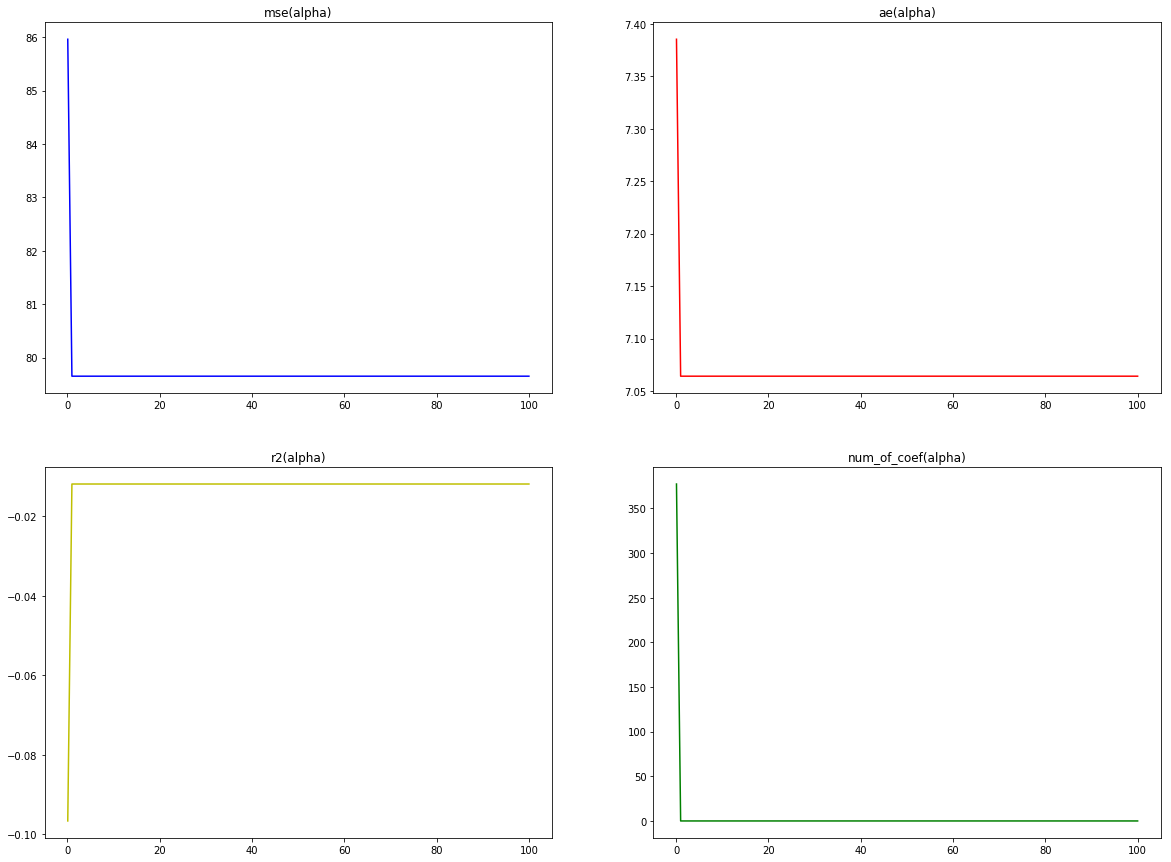

Node number =  1
alpha =  0.1
MSE: 34.63829040527344, AE: 4.212208271026611
R^2 score train: 0.6435883504263658, R^2 score test: -0.18038286581428475
MSE: 36.215843200683594, AE: 4.3806352615356445
R^2 score train: 0.6033629046158757, R^2 score test: -0.02686431718756177
MSE: 23.12912368774414, AE: 3.7722854614257812
R^2 score train: 0.6396107162556046, R^2 score test: -0.16787576036453133


KeyboardInterrupt: 

In [20]:

ae_s = []
mse_s = []
r2_s = []
coef_s = []

for j in range(84):
    print('Node number = ', j)
    mse_alpha = []
    ae_alpha = []
    r2_alpha = []
    coef_alpha = []
    
    for i in range(len(alpha)):
        print('alpha = ', alpha[i])
        mse = []
        ae = []
        r2 = []
        coef = []
        
        for train_idx, test_idx in split.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = bY[train_idx, j], bY[test_idx, j]
            lasso = Lasso(alpha=alpha[i], random_state=0)
            lasso.fit(X_train, y_train)
            y_pred = lasso.predict(X_test)
            mse += [np.mean((y_pred - y_test)**2)]
            ae += [np.mean(abs(y_pred - y_test))]
            score_train = r2_score(y_train, lasso.predict(X_train))
            score_test = r2_score(y_test, y_pred)
            r2 += [score_test]
            print('MSE: {}, AE: {}'.format(mse[-1], ae[-1]))
            print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))
            sparse_coef = np.squeeze(np.asarray(lasso.sparse_coef_.todense()))
            coef += [len(np.where(sparse_coef!=0)[0])]
            
            
        mse_alpha += [np.mean(mse)]
        ae_alpha += [np.mean(ae)]
        r2_alpha += [np.mean(r2)]
        coef_alpha += [np.mean(coef)]
        
    if (j + 1)%10 == 0:
        clear_output()
    fig, ax = plt.subplots(2,2, figsize = (20,15))
    ax[0,0].plot(alpha, mse_alpha, c = 'b')
    ax[0,0].set_title('mse(alpha)')
    
    ax[0,1].plot(alpha, ae_alpha, c = 'r')
    ax[0,1].set_title('ae(alpha)')
    
    ax[1,0].plot(alpha, r2_alpha, c = 'y')
    ax[1,0].set_title('r2(alpha)')
    
    ax[1,1].plot(alpha, coef_alpha, c = 'g')
    ax[1,1].set_title('num_of_coef(alpha)')    
    plt.show()
        
    ae_s += [ae_alpha]
    mse_s += [mse_alpha]
    r2_s += [r2_alpha]
    coef_s += [coef_alpha]

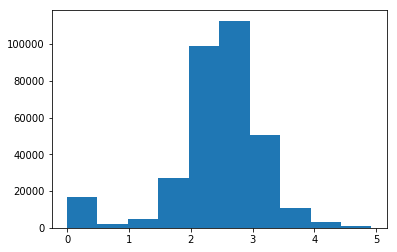

In [26]:
plt.hist(X[0]);

In [30]:
mean = np.mean(X, axis = 0)

In [31]:
std = np.std(X, axis = 0)

In [33]:
np.mean(mean), np.std(std)

(2.4918773, 0.1070491)

In [32]:
print('format: mean +- std')
for i in range(len(std)):
    print(thinkness i , ' : ', mean[i], '+-', std[i])


format: mean +- std
0  :  2.58113 +- 0.336174
1  :  2.3512 +- 0.275475
2  :  2.6863 +- 0.2504
3  :  2.75188 +- 0.303156
4  :  2.91321 +- 0.325813
5  :  2.58377 +- 0.385483
6  :  2.04801 +- 0.270554
7  :  2.68042 +- 0.235121
8  :  3.44718 +- 0.500503
9  :  2.3548 +- 0.223829
10  :  2.26486 +- 0.400552
11  :  2.8287 +- 0.310458
12  :  3.02007 +- 0.347279
13  :  2.49735 +- 0.322502
14  :  2.79323 +- 0.319428
15  :  2.50234 +- 0.281949
16  :  2.5684 +- 0.294465
17  :  2.26071 +- 0.261546
18  :  2.46394 +- 0.294286
19  :  2.78939 +- 0.251138
20  :  2.41367 +- 0.259783
21  :  2.61517 +- 0.269381
22  :  2.66119 +- 0.318995
23  :  2.67736 +- 0.404889
24  :  2.90897 +- 0.277059
25  :  2.94217 +- 0.318633
26  :  3.20031 +- 0.378795
27  :  0.0117112 +- 0.105401
28  :  0.0180292 +- 0.172141
29  :  2.97028 +- 0.369081
30  :  2.08023 +- 0.214755
31  :  2.05462 +- 0.251367
32  :  2.50984 +- 0.228472
33  :  2.61275 +- 0.37134
34  :  2.52293 +- 0.267147
35  :  2.52802 +- 0.287707
36  :  3.24271 +- 0.27

463  :  2.42143 +- 0.303331
464  :  2.80954 +- 0.318253
465  :  2.13616 +- 0.276974
466  :  2.33132 +- 0.274985
467  :  2.42663 +- 0.256463
468  :  2.81345 +- 0.402858
469  :  3.01173 +- 0.35018
470  :  2.61701 +- 0.286583
471  :  2.83941 +- 0.38482
472  :  2.90262 +- 0.39589
473  :  2.34499 +- 0.262279
474  :  2.25795 +- 0.268343
475  :  2.49013 +- 0.25109
476  :  2.47006 +- 0.277968
477  :  2.17301 +- 0.315415
478  :  1.84871 +- 0.273738
479  :  2.20698 +- 0.306972
480  :  2.20262 +- 0.290914
481  :  2.44694 +- 0.299518
482  :  2.55028 +- 0.328603
483  :  1.87931 +- 0.219838
484  :  2.51059 +- 0.324701
485  :  2.05887 +- 0.311442
486  :  2.43101 +- 0.28373
487  :  2.37172 +- 0.270374
488  :  1.76831 +- 0.246544
489  :  2.46618 +- 0.216363
490  :  2.29214 +- 0.272104
491  :  2.29037 +- 0.309197
492  :  2.29653 +- 0.260647
493  :  2.56497 +- 0.340238
494  :  2.6566 +- 0.30013
495  :  2.641 +- 0.238032
496  :  2.52963 +- 0.317536
497  :  2.63276 +- 0.269361
498  :  2.73826 +- 0.303415
4

862  :  2.73416 +- 0.306432
863  :  2.6926 +- 0.270627
864  :  2.98386 +- 0.242588
865  :  2.71038 +- 0.318911
866  :  3.04713 +- 0.248609
867  :  2.86886 +- 0.312069
868  :  2.9311 +- 0.29281
869  :  2.53062 +- 0.277978
870  :  1.97133 +- 0.193617
871  :  2.88366 +- 0.280701
872  :  2.83266 +- 0.259549
873  :  2.67616 +- 0.292368
874  :  2.55527 +- 0.281324
875  :  2.73489 +- 0.278548
876  :  2.87901 +- 0.245553
877  :  2.53331 +- 0.261788
878  :  2.64468 +- 0.278248
879  :  2.51155 +- 0.247701
880  :  2.55187 +- 0.268268
881  :  2.48473 +- 0.253182
882  :  2.48818 +- 0.26112
883  :  2.573 +- 0.25618
884  :  2.55718 +- 0.290071
885  :  2.48757 +- 0.243278
886  :  2.66994 +- 0.26289
887  :  2.76506 +- 0.276609
888  :  2.43465 +- 0.238536
889  :  2.45333 +- 0.269137
890  :  2.47419 +- 0.247772
891  :  2.61684 +- 0.287792
892  :  2.49332 +- 0.284724
893  :  2.56561 +- 0.29016
894  :  2.46185 +- 0.280225
895  :  2.40983 +- 0.250494
896  :  2.43544 +- 0.255195
897  :  2.43432 +- 0.243921
8

1271  :  2.50983 +- 0.302189
1272  :  2.57181 +- 0.283827
1273  :  2.50514 +- 0.274133
1274  :  2.63216 +- 0.284442
1275  :  2.45709 +- 0.266653
1276  :  2.47698 +- 0.277325
1277  :  2.43576 +- 0.252018
1278  :  2.46069 +- 0.242792
1279  :  2.42786 +- 0.237241
1280  :  2.22605 +- 0.253403
1281  :  2.36231 +- 0.242594
1282  :  2.37856 +- 0.369197
1283  :  2.50589 +- 0.337708
1284  :  2.51199 +- 0.318649
1285  :  2.76872 +- 0.292661
1286  :  2.84662 +- 0.298135
1287  :  2.94509 +- 0.287152
1288  :  2.73696 +- 0.369205
1289  :  2.94106 +- 0.30712
1290  :  2.54079 +- 0.282016
1291  :  2.59757 +- 0.272883
1292  :  2.57955 +- 0.261543
1293  :  2.61823 +- 0.357843
1294  :  2.62005 +- 0.335566
1295  :  2.67517 +- 0.347962
1296  :  2.96522 +- 0.322303
1297  :  2.80747 +- 0.373727
1298  :  2.97831 +- 0.355517
1299  :  2.81567 +- 0.360651
1300  :  2.59326 +- 0.302351
1301  :  2.63603 +- 0.311916
1302  :  2.59064 +- 0.289513
1303  :  2.60325 +- 0.261591
1304  :  2.98564 +- 0.302207
1305  :  3.0777

1931  :  2.72067 +- 0.277505
1932  :  2.73338 +- 0.303979
1933  :  2.79077 +- 0.255837
1934  :  2.55882 +- 0.236857
1935  :  2.51345 +- 0.238482
1936  :  2.37979 +- 0.27169
1937  :  2.4571 +- 0.263234
1938  :  2.51089 +- 0.260747
1939  :  2.55742 +- 0.281004
1940  :  2.48384 +- 0.269285
1941  :  2.42946 +- 0.278596
1942  :  2.44724 +- 0.272823
1943  :  2.4785 +- 0.267022
1944  :  2.51478 +- 0.26852
1945  :  2.86587 +- 0.295159
1946  :  2.73494 +- 0.454509
1947  :  2.88013 +- 0.374028
1948  :  2.89221 +- 0.387307
1949  :  2.97698 +- 0.349898
1950  :  2.97278 +- 0.317914
1951  :  2.94805 +- 0.332352
1952  :  2.95844 +- 0.313163
1953  :  2.84393 +- 0.283588
1954  :  2.52679 +- 0.310409
1955  :  2.36505 +- 0.305118
1956  :  2.32124 +- 0.308918
1957  :  3.04874 +- 0.437497
1958  :  3.68538 +- 0.463823
1959  :  4.00127 +- 0.542271
1960  :  3.58529 +- 0.517384
1961  :  2.99481 +- 0.409139
1962  :  3.45262 +- 0.588892
1963  :  2.88685 +- 0.367984
1964  :  2.68334 +- 0.318005
1965  :  3.02422 +

2468  :  1.71595 +- 0.678271
2469  :  2.06505 +- 0.473087
2470  :  2.32676 +- 0.480526
2471  :  2.64713 +- 0.385639
2472  :  2.4769 +- 0.307625
2473  :  2.19307 +- 0.284825
2474  :  2.3953 +- 0.322431
2475  :  2.9433 +- 0.383489
2476  :  3.28829 +- 0.452074
2477  :  3.15707 +- 0.658538
2478  :  3.16323 +- 0.333517
2479  :  2.9759 +- 0.286853
2480  :  2.70316 +- 0.321614
2481  :  2.65406 +- 0.37815
2482  :  2.16967 +- 0.327442
2483  :  2.23038 +- 0.297673
2484  :  2.17501 +- 0.265876
2485  :  1.98371 +- 0.301654
2486  :  2.04109 +- 0.286518
2487  :  1.97863 +- 0.285572
2488  :  2.03162 +- 0.285425
2489  :  2.28968 +- 0.262832
2490  :  2.41987 +- 0.271446
2491  :  1.90491 +- 0.319888
2492  :  1.80231 +- 0.32274
2493  :  2.05861 +- 0.283383
2494  :  2.39095 +- 0.347075
2495  :  2.34057 +- 0.316359
2496  :  2.39846 +- 0.319332
2497  :  2.31934 +- 0.292131
2498  :  2.41725 +- 0.242637
2499  :  2.78787 +- 0.268461
2500  :  2.94187 +- 0.291012
2501  :  3.02752 +- 0.339891
2502  :  3.15675 +- 

2947  :  3.05671 +- 0.449595
2948  :  3.03151 +- 0.461376
2949  :  3.006 +- 0.419533
2950  :  2.97397 +- 0.456063
2951  :  2.91087 +- 0.419053
2952  :  2.95931 +- 0.457179
2953  :  3.10032 +- 0.440607
2954  :  3.05855 +- 0.442312
2955  :  3.18407 +- 0.42685
2956  :  3.19859 +- 0.411246
2957  :  2.23957 +- 0.253875
2958  :  2.28291 +- 0.264212
2959  :  2.22267 +- 0.259692
2960  :  2.17737 +- 0.253422
2961  :  2.2502 +- 0.258005
2962  :  2.25047 +- 0.264309
2963  :  2.29341 +- 0.273707
2964  :  2.24084 +- 0.278267
2965  :  1.66734 +- 0.185988
2966  :  1.72141 +- 0.25691
2967  :  1.69057 +- 0.248838
2968  :  2.55695 +- 0.239096
2969  :  2.49217 +- 0.243508
2970  :  2.55167 +- 0.254063
2971  :  2.49424 +- 0.273786
2972  :  2.57889 +- 0.266284
2973  :  2.55006 +- 0.271225
2974  :  2.63505 +- 0.265233
2975  :  2.05753 +- 0.273041
2976  :  2.16618 +- 0.277059
2977  :  2.15015 +- 0.264753
2978  :  2.23361 +- 0.278181
2979  :  1.80725 +- 0.211877
2980  :  1.79013 +- 0.211693
2981  :  1.77901 +-

3434  :  2.5023 +- 0.391617
3435  :  2.53401 +- 0.392016
3436  :  2.54137 +- 0.405083
3437  :  2.49056 +- 0.340578
3438  :  2.54663 +- 0.368877
3439  :  2.46956 +- 0.313813
3440  :  2.46898 +- 0.298419
3441  :  2.42548 +- 0.308
3442  :  2.49428 +- 0.377215
3443  :  2.5516 +- 0.377212
3444  :  2.54969 +- 0.388018
3445  :  2.61461 +- 0.382103
3446  :  2.59994 +- 0.382051
3447  :  2.52531 +- 0.384419
3448  :  2.4821 +- 0.387255
3449  :  2.44717 +- 0.268288
3450  :  2.43794 +- 0.262845
3451  :  2.4203 +- 0.256993
3452  :  2.36432 +- 0.247933
3453  :  2.37691 +- 0.263386
3454  :  2.3707 +- 0.256747
3455  :  2.38255 +- 0.248541
3456  :  2.37101 +- 0.250322
3457  :  2.41612 +- 0.268365
3458  :  2.4404 +- 0.271758
3459  :  2.43315 +- 0.272004
3460  :  2.41541 +- 0.261924
3461  :  2.42645 +- 0.264673
3462  :  2.43125 +- 0.26454
3463  :  2.46931 +- 0.274038
3464  :  3.04917 +- 0.290553
3465  :  3.04453 +- 0.312769
3466  :  3.08863 +- 0.302872
3467  :  2.78948 +- 0.337576
3468  :  2.91289 +- 0.31

3829  :  2.63898 +- 0.285051
3830  :  2.39447 +- 0.286725
3831  :  2.51031 +- 0.283165
3832  :  2.3875 +- 0.278872
3833  :  2.42374 +- 0.273001
3834  :  2.41454 +- 0.268841
3835  :  2.58079 +- 0.277733
3836  :  2.54519 +- 0.266767
3837  :  2.59125 +- 0.27548
3838  :  2.60475 +- 0.282912
3839  :  2.64276 +- 0.300969
3840  :  2.78259 +- 0.323189
3841  :  2.7412 +- 0.319388
3842  :  3.10305 +- 0.291904
3843  :  3.11521 +- 0.292124
3844  :  3.16996 +- 0.29945
3845  :  3.11627 +- 0.322474
3846  :  3.12301 +- 0.310141
3847  :  3.27368 +- 0.453294
3848  :  3.27689 +- 0.483793
3849  :  3.21946 +- 0.484466
3850  :  3.43243 +- 0.405027
3851  :  3.35148 +- 0.439391
3852  :  3.46564 +- 0.438802
3853  :  2.91338 +- 0.609753
3854  :  3.1096 +- 0.610876
3855  :  3.40722 +- 0.403722
3856  :  3.41137 +- 0.394657
3857  :  3.70888 +- 0.439756
3858  :  3.32859 +- 0.398244
3859  :  3.57756 +- 0.396594
3860  :  3.60085 +- 0.372531
3861  :  3.72389 +- 0.40857
3862  :  3.57845 +- 0.35742
3863  :  3.27222 +- 0

4575  :  1.87742 +- 0.278646
4576  :  1.94801 +- 0.262688
4577  :  1.92516 +- 0.260777
4578  :  2.12451 +- 0.303407
4579  :  2.0845 +- 0.305121
4580  :  2.19512 +- 0.261679
4581  :  2.25607 +- 0.264808
4582  :  2.16979 +- 0.257679
4583  :  2.16207 +- 0.284975
4584  :  2.12522 +- 0.274805
4585  :  2.16785 +- 0.309202
4586  :  2.22239 +- 0.286298
4587  :  2.24635 +- 0.29946
4588  :  2.26613 +- 0.285666
4589  :  2.23926 +- 0.286498
4590  :  2.1942 +- 0.299312
4591  :  2.19574 +- 0.318715
4592  :  2.20463 +- 0.30302
4593  :  2.2479 +- 0.312833
4594  :  2.20496 +- 0.297475
4595  :  2.37649 +- 0.294374
4596  :  2.25834 +- 0.296392
4597  :  2.30891 +- 0.314959
4598  :  2.27141 +- 0.310461
4599  :  2.35453 +- 0.318116
4600  :  2.17315 +- 0.299505
4601  :  2.46814 +- 0.294361
4602  :  2.29787 +- 0.301086
4603  :  2.41015 +- 0.311957
4604  :  2.54558 +- 0.300575
4605  :  2.62403 +- 0.317717
4606  :  2.51378 +- 0.308975
4607  :  2.59447 +- 0.316972
4608  :  2.5141 +- 0.346236
4609  :  2.62959 +- 

5094  :  2.01512 +- 0.241237
5095  :  1.96578 +- 0.269934
5096  :  2.00159 +- 0.250173
5097  :  1.97311 +- 0.275039
5098  :  1.95092 +- 0.314095
5099  :  1.93595 +- 0.34047
5100  :  1.9302 +- 0.293464
5101  :  1.92203 +- 0.323359
5102  :  2.03567 +- 0.266752
5103  :  2.01487 +- 0.241877
5104  :  2.09462 +- 0.236694
5105  :  2.10486 +- 0.229972
5106  :  2.11879 +- 0.23304
5107  :  2.1869 +- 0.230387
5108  :  2.16344 +- 0.220864
5109  :  2.21673 +- 0.223133
5110  :  2.21469 +- 0.22144
5111  :  2.17969 +- 0.230673
5112  :  2.16261 +- 0.242264
5113  :  2.20951 +- 0.217725
5114  :  2.20201 +- 0.232099
5115  :  2.59953 +- 0.278953
5116  :  2.41473 +- 0.259857
5117  :  2.38063 +- 0.244873
5118  :  2.30461 +- 0.24928
5119  :  2.27031 +- 0.24917
5120  :  2.18842 +- 0.224202
5121  :  2.1036 +- 0.218083
5122  :  1.98781 +- 0.233568
5123  :  1.8891 +- 0.284507
5124  :  1.89339 +- 0.276852
5125  :  1.99111 +- 0.24828
5126  :  1.89565 +- 0.250401
5127  :  2.01139 +- 0.242767
5128  :  2.1243 +- 0.231

5663  :  3.02526 +- 0.355563
5664  :  3.09988 +- 0.363828
5665  :  2.95027 +- 0.374648
5666  :  3.0855 +- 0.351111
5667  :  3.24005 +- 0.347282
5668  :  3.04984 +- 0.377379
5669  :  3.0754 +- 0.390372
5670  :  2.9722 +- 0.412883
5671  :  3.01256 +- 0.393183
5672  :  2.8928 +- 0.37567
5673  :  3.05343 +- 0.378404
5674  :  3.17434 +- 0.395348
5675  :  3.14141 +- 0.375031
5676  :  3.14178 +- 0.390293
5677  :  3.05087 +- 0.376297
5678  :  3.12779 +- 0.401628
5679  :  2.62578 +- 0.318037
5680  :  2.68965 +- 0.336179
5681  :  2.63559 +- 0.334968
5682  :  2.72675 +- 0.346903
5683  :  2.75592 +- 0.335239
5684  :  2.89563 +- 0.361007
5685  :  3.07523 +- 0.385116
5686  :  2.99966 +- 0.386965
5687  :  2.99405 +- 0.411085
5688  :  2.93552 +- 0.395895
5689  :  2.92257 +- 0.357977
5690  :  2.89692 +- 0.389413
5691  :  2.90043 +- 0.380896
5692  :  2.89185 +- 0.380984
5693  :  2.88478 +- 0.390842
5694  :  3.11198 +- 0.473248
5695  :  3.15229 +- 0.520567
5696  :  2.64233 +- 0.438997
5697  :  2.40908 +-

6340  :  0.0248703 +- 0.250555
6341  :  1.81154 +- 0.607881
6342  :  1.19774 +- 0.744828
6343  :  1.76881 +- 0.865689
6344  :  2.29095 +- 1.00374
6345  :  3.08642 +- 0.794958
6346  :  2.68657 +- 0.652834
6347  :  3.32347 +- 0.605006
6348  :  2.89539 +- 0.68979
6349  :  2.48869 +- 0.774716
6350  :  1.84755 +- 0.288808
6351  :  1.86398 +- 0.290823
6352  :  1.81097 +- 0.295794
6353  :  1.8691 +- 0.318012
6354  :  1.94174 +- 0.330665
6355  :  2.08722 +- 0.376423
6356  :  2.05912 +- 0.356193
6357  :  2.0943 +- 0.462497
6358  :  2.23428 +- 0.514613
6359  :  2.364 +- 0.492646
6360  :  2.45575 +- 0.460901
6361  :  2.40816 +- 0.495911
6362  :  2.56273 +- 0.459355
6363  :  2.79841 +- 0.398955
6364  :  2.65375 +- 0.238876
6365  :  2.76914 +- 0.232433
6366  :  2.64317 +- 0.249522
6367  :  2.6387 +- 0.260528
6368  :  2.62712 +- 0.274114
6369  :  2.26645 +- 0.300614
6370  :  2.34334 +- 0.302257
6371  :  2.36427 +- 0.289456
6372  :  2.46869 +- 0.269
6373  :  2.54126 +- 0.274249
6374  :  2.56873 +- 0.

6840  :  2.24795 +- 0.282631
6841  :  2.2681 +- 0.277136
6842  :  2.34012 +- 0.264085
6843  :  2.42862 +- 0.239398
6844  :  2.4766 +- 0.244162
6845  :  2.47427 +- 0.252809
6846  :  2.46147 +- 0.249734
6847  :  2.46216 +- 0.226102
6848  :  2.45525 +- 0.202452
6849  :  2.40417 +- 0.312048
6850  :  2.30849 +- 0.321127
6851  :  2.35116 +- 0.321339
6852  :  2.35013 +- 0.319615
6853  :  2.29253 +- 0.281125
6854  :  2.31126 +- 0.221681
6855  :  2.30958 +- 0.213471
6856  :  2.31784 +- 0.208999
6857  :  2.31778 +- 0.199984
6858  :  2.28683 +- 0.188709
6859  :  2.24167 +- 0.183569
6860  :  2.30499 +- 0.177738
6861  :  2.28238 +- 0.173711
6862  :  2.27232 +- 0.170649
6863  :  2.30723 +- 0.183787
6864  :  2.30948 +- 0.188458
6865  :  2.33843 +- 0.204583
6866  :  2.26628 +- 0.201654
6867  :  2.09926 +- 0.242618
6868  :  2.08799 +- 0.236853
6869  :  2.09071 +- 0.238271
6870  :  2.11323 +- 0.234257
6871  :  2.12926 +- 0.253966
6872  :  2.16002 +- 0.261992
6873  :  2.08197 +- 0.253815
6874  :  1.99361

7510  :  1.72469 +- 0.21594
7511  :  2.01711 +- 0.226714
7512  :  1.71307 +- 0.195172
7513  :  1.67538 +- 0.22166
7514  :  1.60692 +- 0.229794
7515  :  1.62541 +- 0.233858
7516  :  1.75351 +- 0.225671
7517  :  1.86006 +- 0.248168
7518  :  1.67499 +- 0.269038
7519  :  1.65967 +- 0.255641
7520  :  1.71544 +- 0.237397
7521  :  1.85877 +- 0.228716
7522  :  1.86399 +- 0.233562
7523  :  2.03947 +- 0.237708
7524  :  2.2644 +- 0.240475
7525  :  2.48221 +- 0.248536
7526  :  2.48663 +- 0.258589
7527  :  2.41117 +- 0.266069
7528  :  2.33897 +- 0.267342
7529  :  2.37193 +- 0.265366
7530  :  2.34029 +- 0.267672
7531  :  2.30055 +- 0.258814
7532  :  2.31028 +- 0.229851
7533  :  2.26442 +- 0.241483
7534  :  2.23573 +- 0.252262
7535  :  2.17685 +- 0.250019
7536  :  2.16883 +- 0.246024
7537  :  2.61063 +- 0.328567
7538  :  2.71529 +- 0.341109
7539  :  2.77514 +- 0.343594
7540  :  2.77648 +- 0.337797
7541  :  2.9087 +- 0.32305
7542  :  2.81104 +- 0.329685
7543  :  2.71371 +- 0.323013
7544  :  2.6728 +- 

8038  :  2.8767 +- 0.370142
8039  :  2.84314 +- 0.341314
8040  :  2.80448 +- 0.35375
8041  :  2.8482 +- 0.370468
8042  :  2.86552 +- 0.382965
8043  :  2.86577 +- 0.40179
8044  :  2.82741 +- 0.39832
8045  :  2.8685 +- 0.37748
8046  :  2.94208 +- 0.350969
8047  :  2.97401 +- 0.348315
8048  :  2.99885 +- 0.3376
8049  :  2.9942 +- 0.332762
8050  :  2.93573 +- 0.330741
8051  :  2.80592 +- 0.320657
8052  :  2.73248 +- 0.323335
8053  :  2.85146 +- 0.302846
8054  :  2.73352 +- 0.311367
8055  :  2.65457 +- 0.319636
8056  :  2.58192 +- 0.30147
8057  :  2.58344 +- 0.314838
8058  :  2.61397 +- 0.321526
8059  :  2.61596 +- 0.326376
8060  :  2.64693 +- 0.323888
8061  :  2.68603 +- 0.315091
8062  :  2.62869 +- 0.287059
8063  :  2.63027 +- 0.266235
8064  :  2.65333 +- 0.256791
8065  :  2.67247 +- 0.258342
8066  :  2.62207 +- 0.264747
8067  :  2.59766 +- 0.269225
8068  :  2.6114 +- 0.305163
8069  :  2.68824 +- 0.320905
8070  :  2.75959 +- 0.321678
8071  :  2.60421 +- 0.287552
8072  :  2.64753 +- 0.2889

8583  :  3.26791 +- 0.278746
8584  :  3.22104 +- 0.273835
8585  :  3.14035 +- 0.293817
8586  :  2.95691 +- 0.320662
8587  :  2.90691 +- 0.336572
8588  :  2.94087 +- 0.331155
8589  :  2.90161 +- 0.327322
8590  :  2.83045 +- 0.317214
8591  :  2.69527 +- 0.285549
8592  :  2.69383 +- 0.252238
8593  :  2.6908 +- 0.258002
8594  :  2.6755 +- 0.321429
8595  :  2.65072 +- 0.295032
8596  :  2.69539 +- 0.264439
8597  :  2.74706 +- 0.26666
8598  :  2.76888 +- 0.264641
8599  :  2.74496 +- 0.259181
8600  :  2.73411 +- 0.264174
8601  :  2.6842 +- 0.286321
8602  :  2.68353 +- 0.315851
8603  :  2.88833 +- 0.342723
8604  :  3.003 +- 0.358723
8605  :  3.02255 +- 0.348592
8606  :  2.98982 +- 0.35819
8607  :  3.03027 +- 0.333696
8608  :  3.14844 +- 0.31361
8609  :  3.37143 +- 0.307535
8610  :  3.35179 +- 0.322671
8611  :  3.23396 +- 0.385649
8612  :  2.87776 +- 0.32789
8613  :  2.87932 +- 0.310443
8614  :  2.88549 +- 0.330199
8615  :  2.96075 +- 0.354998
8616  :  3.08986 +- 0.400465
8617  :  3.23648 +- 0.4

9114  :  2.90746 +- 0.360305
9115  :  2.84968 +- 0.285659
9116  :  3.00577 +- 0.295605
9117  :  3.08152 +- 0.279228
9118  :  2.87567 +- 0.275593
9119  :  2.83169 +- 0.270199
9120  :  2.84176 +- 0.273897
9121  :  2.70189 +- 0.295657
9122  :  2.75645 +- 0.329993
9123  :  2.96252 +- 0.334469
9124  :  3.11433 +- 0.312195
9125  :  3.17806 +- 0.372854
9126  :  3.25076 +- 0.422523
9127  :  3.185 +- 0.298729
9128  :  3.23736 +- 0.388065
9129  :  3.31442 +- 0.428129
9130  :  3.22766 +- 0.410351
9131  :  3.07982 +- 0.354164
9132  :  2.98756 +- 0.303089
9133  :  2.97259 +- 0.303327
9134  :  2.91353 +- 0.326426
9135  :  2.91252 +- 0.348085
9136  :  2.91423 +- 0.315348
9137  :  2.8821 +- 0.353065
9138  :  2.91671 +- 0.353097
9139  :  2.82576 +- 0.354421
9140  :  2.60744 +- 0.314302
9141  :  2.35162 +- 0.272109
9142  :  2.67632 +- 0.297233
9143  :  2.98327 +- 0.244814
9144  :  3.05174 +- 0.236541
9145  :  3.08891 +- 0.278885
9146  :  3.06572 +- 0.25233
9147  :  2.84432 +- 0.250838
9148  :  2.45108 +

9589  :  2.19312 +- 0.264506
9590  :  2.13629 +- 0.267385
9591  :  2.10121 +- 0.251909
9592  :  2.06921 +- 0.26392
9593  :  2.66411 +- 0.241995
9594  :  2.68964 +- 0.258085
9595  :  2.68994 +- 0.259034
9596  :  2.77508 +- 0.282116
9597  :  2.83295 +- 0.298945
9598  :  2.75658 +- 0.28269
9599  :  2.81916 +- 0.292289
9600  :  2.85685 +- 0.307467
9601  :  2.89178 +- 0.31122
9602  :  2.90857 +- 0.326336
9603  :  2.80649 +- 0.324948
9604  :  2.64583 +- 0.274886
9605  :  2.73883 +- 0.301
9606  :  2.80944 +- 0.306342
9607  :  2.84212 +- 0.305307
9608  :  2.86874 +- 0.298689
9609  :  2.88818 +- 0.303711
9610  :  2.87592 +- 0.319714
9611  :  2.76594 +- 0.312503
9612  :  2.67254 +- 0.312131
9613  :  2.60332 +- 0.309578
9614  :  2.57791 +- 0.301544
9615  :  2.57132 +- 0.285693
9616  :  2.55923 +- 0.272975
9617  :  2.54709 +- 0.273964
9618  :  2.56501 +- 0.266622
9619  :  2.54473 +- 0.24981
9620  :  2.51443 +- 0.251118
9621  :  2.51492 +- 0.259007
9622  :  2.56459 +- 0.348183
9623  :  2.60909 +- 0

10299  :  2.80971 +- 0.326734
10300  :  2.45592 +- 0.280498
10301  :  2.47109 +- 0.289814
10302  :  2.52357 +- 0.284537
10303  :  3.01671 +- 0.335891
10304  :  3.12259 +- 0.312172
10305  :  3.12232 +- 0.319545
10306  :  3.19924 +- 0.315846
10307  :  2.31246 +- 0.247401
10308  :  2.26762 +- 0.242307
10309  :  2.2773 +- 0.249945
10310  :  2.47397 +- 0.28316
10311  :  2.38997 +- 0.273108
10312  :  2.41998 +- 0.273962
10313  :  2.39683 +- 0.26911
10314  :  2.84244 +- 0.252516
10315  :  2.82015 +- 0.247135
10316  :  2.7699 +- 0.246354
10317  :  2.18661 +- 0.271106
10318  :  2.26321 +- 0.270175
10319  :  2.31903 +- 0.256942
10320  :  2.34494 +- 0.244426
10321  :  2.84429 +- 0.336108
10322  :  2.82671 +- 0.327922
10323  :  2.8069 +- 0.253771
10324  :  2.86705 +- 0.253142
10325  :  2.8609 +- 0.254609
10326  :  2.909 +- 0.251362
10327  :  2.62591 +- 0.346367
10328  :  2.61588 +- 0.350626
10329  :  2.62601 +- 0.331395
10330  :  2.60806 +- 0.263281
10331  :  2.62926 +- 0.269842
10332  :  2.63271 

10799  :  3.36138 +- 0.363275
10800  :  2.13117 +- 0.277191
10801  :  2.25438 +- 0.273113
10802  :  2.01582 +- 0.294613
10803  :  0.732295 +- 0.322612
10804  :  0.921476 +- 0.241072
10805  :  0.870211 +- 0.28649
10806  :  0.960079 +- 0.252388
10807  :  0.801467 +- 0.332269
10808  :  0.768997 +- 0.358728
10809  :  0.565063 +- 0.36454
10810  :  0.336552 +- 0.344722
10811  :  0.287836 +- 0.305753
10812  :  0.338539 +- 0.33941
10813  :  0.343237 +- 0.333325
10814  :  2.02228 +- 0.228686
10815  :  1.96095 +- 0.228937
10816  :  2.00029 +- 0.227187
10817  :  2.10019 +- 0.24536
10818  :  2.0313 +- 0.257212
10819  :  2.04455 +- 0.250172
10820  :  2.00039 +- 0.254712
10821  :  2.06429 +- 0.234098
10822  :  2.4382 +- 0.269203
10823  :  2.40898 +- 0.263711
10824  :  2.44913 +- 0.272673
10825  :  2.37949 +- 0.27074
10826  :  2.37625 +- 0.281407
10827  :  2.34953 +- 0.28544
10828  :  2.28684 +- 0.303312
10829  :  2.30749 +- 0.294268
10830  :  2.26427 +- 0.3068
10831  :  2.33381 +- 0.294517
10832  : 

11303  :  2.92114 +- 0.314755
11304  :  2.88651 +- 0.347743
11305  :  2.9322 +- 0.318702
11306  :  3.01017 +- 0.304116
11307  :  3.00738 +- 0.299876
11308  :  3.05833 +- 0.289727
11309  :  2.99609 +- 0.297894
11310  :  2.75703 +- 0.259078
11311  :  2.79833 +- 0.260298
11312  :  2.79465 +- 0.263059
11313  :  2.65359 +- 0.266867
11314  :  2.65551 +- 0.260736
11315  :  2.65072 +- 0.267559
11316  :  2.64903 +- 0.26745
11317  :  2.66362 +- 0.274723
11318  :  2.68393 +- 0.281371
11319  :  2.67456 +- 0.283686
11320  :  2.74141 +- 0.30035
11321  :  2.72727 +- 0.301792
11322  :  2.74547 +- 0.294445
11323  :  2.7636 +- 0.288695
11324  :  2.77 +- 0.286917
11325  :  2.83031 +- 0.355778
11326  :  2.84312 +- 0.369028
11327  :  2.82439 +- 0.369199
11328  :  2.80869 +- 0.382964
11329  :  2.76405 +- 0.382917
11330  :  2.82323 +- 0.375838
11331  :  2.8563 +- 0.353666
11332  :  2.88659 +- 0.3605
11333  :  2.90879 +- 0.253699
11334  :  2.93381 +- 0.249765
11335  :  2.9614 +- 0.241746
11336  :  2.5178 +- 0

11802  :  2.49188 +- 0.274057
11803  :  2.50111 +- 0.277211
11804  :  2.47131 +- 0.277598
11805  :  2.47781 +- 0.246719
11806  :  2.46777 +- 0.245925
11807  :  2.4679 +- 0.243599
11808  :  2.40373 +- 0.247129
11809  :  2.41543 +- 0.253213
11810  :  2.3972 +- 0.246351
11811  :  2.4081 +- 0.251298
11812  :  2.38531 +- 0.246038
11813  :  2.38659 +- 0.25257
11814  :  2.38663 +- 0.241823
11815  :  2.45309 +- 0.244025
11816  :  2.44982 +- 0.237443
11817  :  2.44928 +- 0.239337
11818  :  2.44516 +- 0.238776
11819  :  0.0189599 +- 0.108958
11820  :  0.0121418 +- 0.0941046
11821  :  0.0177954 +- 0.109144
11822  :  0.0876067 +- 0.183244
11823  :  0.0317716 +- 0.127182
11824  :  0.0422888 +- 0.140414
11825  :  0.0228832 +- 0.110894
11826  :  0.0593263 +- 0.16405
11827  :  2.36364 +- 0.366201
11828  :  2.11002 +- 0.378743
11829  :  2.21571 +- 0.394798
11830  :  1.33991 +- 0.549191
11831  :  1.12082 +- 0.525273
11832  :  0.906264 +- 0.534674
11833  :  0.501733 +- 0.470972
11834  :  0.690984 +- 0.52

12324  :  1.83211 +- 0.244133
12325  :  1.86463 +- 0.229688
12326  :  1.79836 +- 0.232479
12327  :  1.94429 +- 0.228694
12328  :  2.46259 +- 0.222234
12329  :  2.43487 +- 0.217824
12330  :  2.44507 +- 0.218038
12331  :  2.42282 +- 0.21606
12332  :  2.45277 +- 0.215029
12333  :  2.46241 +- 0.213712
12334  :  2.47085 +- 0.212523
12335  :  2.31217 +- 0.270673
12336  :  2.30814 +- 0.267284
12337  :  2.28842 +- 0.267951
12338  :  2.2622 +- 0.263119
12339  :  2.2674 +- 0.268623
12340  :  2.24869 +- 0.269605
12341  :  2.26965 +- 0.27365
12342  :  2.29085 +- 0.303493
12343  :  2.27718 +- 0.295272
12344  :  2.27794 +- 0.299597
12345  :  2.26345 +- 0.289064
12346  :  2.27604 +- 0.302128
12347  :  2.29585 +- 0.285967
12348  :  2.29105 +- 0.290962
12349  :  2.28536 +- 0.291868
12350  :  2.27568 +- 0.263803
12351  :  2.27079 +- 0.273434
12352  :  2.28691 +- 0.265336
12353  :  2.29884 +- 0.264995
12354  :  2.30988 +- 0.260827
12355  :  2.33168 +- 0.259063
12356  :  2.31882 +- 0.259932
12357  :  2.33

12910  :  2.6532 +- 0.297429
12911  :  2.70602 +- 0.30624
12912  :  2.66197 +- 0.301148
12913  :  2.66899 +- 0.299971
12914  :  2.6338 +- 0.289737
12915  :  2.61639 +- 0.279004
12916  :  2.60932 +- 0.278349
12917  :  2.45781 +- 0.260317
12918  :  2.47189 +- 0.255167
12919  :  2.46919 +- 0.254693
12920  :  2.48415 +- 0.243879
12921  :  2.47467 +- 0.249938
12922  :  2.77601 +- 0.353271
12923  :  2.73764 +- 0.351867
12924  :  2.79485 +- 0.354521
12925  :  2.78915 +- 0.358236
12926  :  2.82081 +- 0.368902
12927  :  2.81671 +- 0.359578
12928  :  2.8284 +- 0.356822
12929  :  2.79287 +- 0.346826
12930  :  2.63118 +- 0.375563
12931  :  2.65584 +- 0.363748
12932  :  2.60072 +- 0.362383
12933  :  2.4825 +- 0.269672
12934  :  2.47681 +- 0.273215
12935  :  2.47347 +- 0.271006
12936  :  2.47494 +- 0.272994
12937  :  2.4697 +- 0.268081
12938  :  2.46297 +- 0.262256
12939  :  2.46973 +- 0.263594
12940  :  2.58242 +- 0.270195
12941  :  2.55698 +- 0.266394
12942  :  2.58171 +- 0.262789
12943  :  2.5792

13359  :  2.6342 +- 0.313741
13360  :  2.62863 +- 0.325729
13361  :  2.6333 +- 0.324869
13362  :  2.77675 +- 0.362533
13363  :  2.79146 +- 0.351895
13364  :  2.85861 +- 0.368885
13365  :  2.95856 +- 0.375592
13366  :  2.92024 +- 0.382603
13367  :  2.96502 +- 0.393521
13368  :  2.89141 +- 0.385283
13369  :  2.93971 +- 0.357193
13370  :  2.91185 +- 0.372455
13371  :  2.91683 +- 0.372697
13372  :  2.89416 +- 0.380378
13373  :  2.91833 +- 0.382748
13374  :  2.83202 +- 0.443009
13375  :  2.86161 +- 0.468756
13376  :  2.61691 +- 0.417028
13377  :  2.46694 +- 0.260415
13378  :  2.42937 +- 0.255673
13379  :  2.48354 +- 0.258031
13380  :  2.4975 +- 0.260464
13381  :  2.55013 +- 0.266215
13382  :  2.94916 +- 0.329576
13383  :  2.89732 +- 0.314912
13384  :  2.95739 +- 0.328927
13385  :  3.36082 +- 0.310567
13386  :  3.20599 +- 0.308797
13387  :  3.28443 +- 0.313604
13388  :  3.19844 +- 0.313296
13389  :  3.36082 +- 0.315608
13390  :  3.42511 +- 0.315965
13391  :  3.48117 +- 0.307214
13392  :  2.9

13836  :  3.05017 +- 0.241036
13837  :  2.5238 +- 0.282126
13838  :  2.50808 +- 0.279178
13839  :  2.51365 +- 0.283551
13840  :  2.43708 +- 0.301363
13841  :  2.41219 +- 0.295589
13842  :  2.35455 +- 0.294175
13843  :  2.27468 +- 0.293081
13844  :  2.30153 +- 0.295056
13845  :  2.32958 +- 0.2538
13846  :  2.41554 +- 0.253995
13847  :  2.38321 +- 0.244839
13848  :  2.4392 +- 0.234671
13849  :  2.47538 +- 0.23902
13850  :  2.50718 +- 0.236108
13851  :  2.5129 +- 0.232388
13852  :  2.51431 +- 0.229417
13853  :  2.49294 +- 0.228236
13854  :  2.50682 +- 0.226043
13855  :  2.37858 +- 0.220667
13856  :  2.46075 +- 0.221847
13857  :  2.43528 +- 0.218139
13858  :  2.45585 +- 0.210509
13859  :  2.60731 +- 0.337945
13860  :  2.59099 +- 0.326609
13861  :  2.58744 +- 0.335104
13862  :  2.56103 +- 0.34102
13863  :  2.56813 +- 0.336834
13864  :  2.5698 +- 0.336949
13865  :  2.586 +- 0.325366
13866  :  2.58185 +- 0.334887
13867  :  2.62558 +- 0.23467
13868  :  2.71634 +- 0.239826
13869  :  2.62802 +- 

14192  :  2.5073 +- 0.258652
14193  :  2.5243 +- 0.26046
14194  :  2.54112 +- 0.265915
14195  :  2.54607 +- 0.266132
14196  :  2.58351 +- 0.269974
14197  :  2.53908 +- 0.285965
14198  :  2.54783 +- 0.287143
14199  :  2.50784 +- 0.28315
14200  :  2.4605 +- 0.276513
14201  :  2.48614 +- 0.280183
14202  :  2.47817 +- 0.283273
14203  :  2.48423 +- 0.280294
14204  :  2.46336 +- 0.277221
14205  :  2.4191 +- 0.251271
14206  :  2.4285 +- 0.254414
14207  :  2.41125 +- 0.253241
14208  :  2.41457 +- 0.247496
14209  :  2.42335 +- 0.249338
14210  :  2.43812 +- 0.25088
14211  :  2.44625 +- 0.254729
14212  :  2.45265 +- 0.248266
14213  :  2.46333 +- 0.238798
14214  :  2.4527 +- 0.23756
14215  :  2.46183 +- 0.235156
14216  :  2.45105 +- 0.230003
14217  :  2.46269 +- 0.236229
14218  :  2.46047 +- 0.242274
14219  :  0.362906 +- 0.258303
14220  :  0.181601 +- 0.213271
14221  :  0.378483 +- 0.259725
14222  :  0.791511 +- 0.309979
14223  :  0.475417 +- 0.287909
14224  :  0.549349 +- 0.313297
14225  :  0.33

14620  :  3.08866 +- 0.406898
14621  :  3.07267 +- 0.395028
14622  :  3.12781 +- 0.398197
14623  :  3.21476 +- 0.417841
14624  :  3.17466 +- 0.402999
14625  :  3.18721 +- 0.407563
14626  :  3.15341 +- 0.398811
14627  :  2.32715 +- 0.257167
14628  :  2.34373 +- 0.26328
14629  :  2.32415 +- 0.260812
14630  :  2.27161 +- 0.266173
14631  :  2.30816 +- 0.266703
14632  :  2.29704 +- 0.267526
14633  :  2.33893 +- 0.263676
14634  :  2.28759 +- 0.264683
14635  :  2.18149 +- 0.25157
14636  :  2.21496 +- 0.253509
14637  :  2.21679 +- 0.253367
14638  :  2.28977 +- 0.26149
14639  :  2.28778 +- 0.262788
14640  :  2.33015 +- 0.261368
14641  :  2.37277 +- 0.257923
14642  :  2.35834 +- 0.260828
14643  :  2.35211 +- 0.27029
14644  :  2.33274 +- 0.266442
14645  :  2.27496 +- 0.278197
14646  :  2.27217 +- 0.279827
14647  :  2.24915 +- 0.284169
14648  :  2.21482 +- 0.295534
14649  :  2.23445 +- 0.287517
14650  :  1.69189 +- 0.204461
14651  :  1.71856 +- 0.229851
14652  :  1.69902 +- 0.226274
14653  :  1.80

15104  :  2.91929 +- 0.343203
15105  :  3.10511 +- 0.378204
15106  :  3.04595 +- 0.390489
15107  :  3.03523 +- 0.408333
15108  :  2.96665 +- 0.390029
15109  :  2.89681 +- 0.39092
15110  :  2.85347 +- 0.360247
15111  :  2.76036 +- 0.332322
15112  :  2.81005 +- 0.344456
15113  :  2.75514 +- 0.337445
15114  :  2.85448 +- 0.359501
15115  :  3.12613 +- 0.348478
15116  :  2.98773 +- 0.356869
15117  :  3.09045 +- 0.325313
15118  :  3.08647 +- 0.302241
15119  :  3.18395 +- 0.283792
15120  :  3.01121 +- 0.275577
15121  :  3.07795 +- 0.276873
15122  :  2.92099 +- 0.269691
15123  :  2.54529 +- 0.259119
15124  :  2.77501 +- 0.258326
15125  :  2.68937 +- 0.259949
15126  :  2.82139 +- 0.26653
15127  :  2.57078 +- 0.274468
15128  :  0.961778 +- 0.159598
15129  :  1.00953 +- 0.170589
15130  :  0.980318 +- 0.163801
15131  :  1.0527 +- 0.240082
15132  :  1.10014 +- 0.23512
15133  :  1.2484 +- 0.268385
15134  :  1.53688 +- 0.270854
15135  :  1.45131 +- 0.281927
15136  :  1.66593 +- 0.28919
15137  :  1.38

15508  :  3.30446 +- 0.470192
15509  :  3.35088 +- 0.487219
15510  :  2.44817 +- 0.602254
15511  :  2.43752 +- 0.6016
15512  :  2.42446 +- 0.653767
15513  :  3.29163 +- 0.687804
15514  :  2.99426 +- 0.739896
15515  :  3.30309 +- 0.694102
15516  :  3.28861 +- 0.694435
15517  :  3.45573 +- 0.645863
15518  :  3.45279 +- 0.643257
15519  :  3.45299 +- 0.646715
15520  :  3.36055 +- 0.679016
15521  :  3.35776 +- 0.6885
15522  :  3.44589 +- 0.673095
15523  :  3.57097 +- 0.636907
15524  :  3.6127 +- 0.638664
15525  :  2.93463 +- 0.480859
15526  :  2.86225 +- 0.469929
15527  :  2.77704 +- 0.452223
15528  :  2.9385 +- 0.445621
15529  :  2.76948 +- 0.445375
15530  :  2.9002 +- 0.476277
15531  :  2.83136 +- 0.500953
15532  :  3.07451 +- 0.509982
15533  :  3.79492 +- 0.519983
15534  :  3.75257 +- 0.484043
15535  :  3.75404 +- 0.543006
15536  :  3.61446 +- 0.596928
15537  :  3.66736 +- 0.552452
15538  :  3.66275 +- 0.553599
15539  :  3.71355 +- 0.494081
15540  :  3.70203 +- 0.552435
15541  :  3.78371

15899  :  2.8836 +- 0.307934
15900  :  2.85693 +- 0.316437
15901  :  2.81248 +- 0.325999
15902  :  2.83111 +- 0.324438
15903  :  2.80692 +- 0.330461
15904  :  2.84918 +- 0.326875
15905  :  2.74502 +- 0.333905
15906  :  2.81611 +- 0.338292
15907  :  2.75269 +- 0.341817
15908  :  2.76716 +- 0.348758
15909  :  2.94946 +- 0.28256
15910  :  3.0362 +- 0.25582
15911  :  2.98692 +- 0.277745
15912  :  2.98054 +- 0.280745
15913  :  3.03263 +- 0.265238
15914  :  3.04774 +- 0.263811
15915  :  3.06649 +- 0.263273
15916  :  3.0548 +- 0.264698
15917  :  2.76842 +- 0.332382
15918  :  2.80346 +- 0.328725
15919  :  2.89239 +- 0.308415
15920  :  3.00242 +- 0.282194
15921  :  3.01938 +- 0.278261
15922  :  3.01401 +- 0.279516
15923  :  3.02633 +- 0.27741
15924  :  2.99358 +- 0.287518
15925  :  2.97493 +- 0.294391
15926  :  2.9549 +- 0.294983
15927  :  2.842 +- 0.320889
15928  :  2.86159 +- 0.314918
15929  :  2.81969 +- 0.326068
15930  :  2.7982 +- 0.326938
15931  :  2.58225 +- 0.250587
15932  :  2.51681 +-

16319  :  2.60195 +- 0.263982
16320  :  2.60499 +- 0.263898
16321  :  2.60931 +- 0.272205
16322  :  2.60958 +- 0.260244
16323  :  2.64664 +- 0.247411
16324  :  2.66568 +- 0.240677
16325  :  2.6641 +- 0.239143
16326  :  2.65806 +- 0.25194
16327  :  2.65576 +- 0.244078
16328  :  2.64012 +- 0.251725
16329  :  2.62684 +- 0.259018
16330  :  2.63439 +- 0.258901
16331  :  2.63994 +- 0.267467
16332  :  2.63524 +- 0.262628
16333  :  2.63657 +- 0.266512
16334  :  2.62155 +- 0.271558
16335  :  2.60927 +- 0.270196
16336  :  2.58552 +- 0.272726
16337  :  2.59981 +- 0.267058
16338  :  2.59761 +- 0.264519
16339  :  2.614 +- 0.265593
16340  :  2.63785 +- 0.277243
16341  :  2.6282 +- 0.274283
16342  :  2.64073 +- 0.278838
16343  :  2.64569 +- 0.2754
16344  :  2.65885 +- 0.283833
16345  :  2.71723 +- 0.304108
16346  :  2.69326 +- 0.299793
16347  :  2.71206 +- 0.305288
16348  :  2.72256 +- 0.310272
16349  :  2.71021 +- 0.303723
16350  :  2.70802 +- 0.30039
16351  :  2.69341 +- 0.292881
16352  :  2.70624 

16639  :  3.10139 +- 0.291882
16640  :  3.12163 +- 0.293269
16641  :  3.11951 +- 0.293052
16642  :  3.12177 +- 0.291264
16643  :  3.10443 +- 0.284716
16644  :  3.11703 +- 0.28729
16645  :  3.08902 +- 0.282042
16646  :  3.09668 +- 0.281603
16647  :  3.08389 +- 0.282245
16648  :  3.07262 +- 0.286304
16649  :  3.07294 +- 0.282615
16650  :  2.68726 +- 0.284297
16651  :  2.73079 +- 0.282461
16652  :  2.75345 +- 0.279156
16653  :  2.85483 +- 0.271384
16654  :  2.85612 +- 0.279183
16655  :  2.84957 +- 0.278913
16656  :  2.82602 +- 0.282685
16657  :  2.81389 +- 0.274703
16658  :  2.76442 +- 0.263764
16659  :  2.79629 +- 0.260479
16660  :  2.76328 +- 0.251279
16661  :  2.67463 +- 0.253723
16662  :  2.72354 +- 0.250417
16663  :  2.69126 +- 0.256232
16664  :  2.70983 +- 0.264532
16665  :  2.65483 +- 0.2671
16666  :  2.62066 +- 0.280939
16667  :  2.61804 +- 0.277311
16668  :  2.67547 +- 0.271144
16669  :  2.65643 +- 0.276825
16670  :  2.71795 +- 0.277201
16671  :  2.80129 +- 0.282847
16672  :  2.8

17412  :  3.68029 +- 0.429145
17413  :  3.43768 +- 0.439405
17414  :  3.27197 +- 0.442825
17415  :  3.15781 +- 0.423158
17416  :  2.92168 +- 0.371992
17417  :  3.05818 +- 0.392654
17418  :  2.94034 +- 0.377826
17419  :  2.83379 +- 0.349795
17420  :  2.77581 +- 0.345288
17421  :  2.68855 +- 0.337618
17422  :  2.78778 +- 0.345888
17423  :  3.06021 +- 0.501927
17424  :  3.05999 +- 0.466261
17425  :  3.03338 +- 0.427875
17426  :  3.158 +- 0.346624
17427  :  3.05915 +- 0.353697
17428  :  3.04809 +- 0.340293
17429  :  2.95062 +- 0.335941
17430  :  3.02666 +- 0.342783
17431  :  3.03979 +- 0.378122
17432  :  3.07591 +- 0.379462
17433  :  3.19702 +- 0.481762
17434  :  3.17131 +- 0.472559
17435  :  3.24188 +- 0.478347
17436  :  3.3308 +- 0.466714
17437  :  3.30013 +- 0.464364
17438  :  1.91562 +- 0.240197
17439  :  1.8794 +- 0.238494
17440  :  1.91813 +- 0.251245
17441  :  1.973 +- 0.302037
17442  :  1.93456 +- 0.285181
17443  :  1.94605 +- 0.29485
17444  :  1.93353 +- 0.296761
17445  :  1.96212

18004  :  2.43632 +- 0.246474
18005  :  2.41659 +- 0.251937
18006  :  2.42953 +- 0.252111
18007  :  2.40172 +- 0.257443
18008  :  2.45773 +- 0.258125
18009  :  2.43446 +- 0.249978
18010  :  2.45576 +- 0.250123
18011  :  2.49892 +- 0.247983
18012  :  2.44691 +- 0.254383
18013  :  2.46118 +- 0.254712
18014  :  2.43271 +- 0.26167
18015  :  2.49376 +- 0.253537
18016  :  2.53604 +- 0.253175
18017  :  2.57081 +- 0.249184
18018  :  2.59568 +- 0.268192
18019  :  2.63652 +- 0.272017
18020  :  2.61741 +- 0.276052
18021  :  2.63892 +- 0.279933
18022  :  2.60447 +- 0.279193
18023  :  2.61458 +- 0.282419
18024  :  2.5912 +- 0.277842
18025  :  2.57206 +- 0.276447
18026  :  2.60163 +- 0.280366
18027  :  2.61266 +- 0.277376
18028  :  2.66097 +- 0.268362
18029  :  2.62364 +- 0.266586
18030  :  2.55859 +- 0.251978
18031  :  2.55913 +- 0.254771
18032  :  2.57775 +- 0.254916
18033  :  2.61636 +- 0.25926
18034  :  2.60309 +- 0.262601
18035  :  2.62272 +- 0.256901
18036  :  2.64492 +- 0.253857
18037  :  2.6

18561  :  2.49221 +- 0.258888
18562  :  2.49381 +- 0.263072
18563  :  2.50672 +- 0.267484
18564  :  2.48793 +- 0.27013
18565  :  2.48472 +- 0.27565
18566  :  2.48429 +- 0.27705
18567  :  2.5038 +- 0.27211
18568  :  2.52551 +- 0.269026
18569  :  2.54501 +- 0.265539
18570  :  2.52569 +- 0.256302
18571  :  2.51021 +- 0.26084
18572  :  2.56672 +- 0.257429
18573  :  2.80864 +- 0.290028
18574  :  2.69995 +- 0.278166
18575  :  2.77611 +- 0.287989
18576  :  2.73383 +- 0.281739
18577  :  2.84364 +- 0.292069
18578  :  2.89338 +- 0.295989
18579  :  2.90313 +- 0.298586
18580  :  2.79617 +- 0.334985
18581  :  2.84642 +- 0.324591
18582  :  2.76324 +- 0.3519
18583  :  2.7309 +- 0.365729
18584  :  2.72255 +- 0.455754
18585  :  2.72498 +- 0.445047
18586  :  2.73949 +- 0.449649
18587  :  2.84188 +- 0.412453
18588  :  2.84227 +- 0.409474
18589  :  2.90035 +- 0.383658
18590  :  2.95567 +- 0.361748
18591  :  2.94685 +- 0.36626
18592  :  2.8163 +- 0.417014
18593  :  2.82084 +- 0.414925
18594  :  2.86747 +- 

19135  :  2.5256 +- 0.278377
19136  :  2.57745 +- 0.280999
19137  :  2.5699 +- 0.277819
19138  :  2.68902 +- 0.277643
19139  :  2.68585 +- 0.275676
19140  :  2.70979 +- 0.27463
19141  :  2.70265 +- 0.276699
19142  :  2.69416 +- 0.27511
19143  :  2.64494 +- 0.279347
19144  :  2.66399 +- 0.278184
19145  :  2.60631 +- 0.281318
19146  :  2.57583 +- 0.284329
19147  :  2.53707 +- 0.282013
19148  :  2.48157 +- 0.277738
19149  :  2.50766 +- 0.278026
19150  :  2.60071 +- 0.266409
19151  :  2.57569 +- 0.269348
19152  :  2.59821 +- 0.273661
19153  :  2.62788 +- 0.281358
19154  :  2.59904 +- 0.286637
19155  :  2.60905 +- 0.28452
19156  :  2.59666 +- 0.286627
19157  :  2.62702 +- 0.282626
19158  :  2.65196 +- 0.291621
19159  :  2.65633 +- 0.283145
19160  :  2.64037 +- 0.284219
19161  :  2.65121 +- 0.282092
19162  :  2.65422 +- 0.281165
19163  :  2.66403 +- 0.283461
19164  :  2.66694 +- 0.282362
19165  :  2.67178 +- 0.280457
19166  :  2.6723 +- 0.27526
19167  :  2.65662 +- 0.273663
19168  :  2.55056

19581  :  2.48668 +- 0.367591
19582  :  2.51822 +- 0.360213
19583  :  2.49757 +- 0.367911
19584  :  2.55201 +- 0.35027
19585  :  2.43084 +- 0.320834
19586  :  2.54596 +- 0.328465
19587  :  2.521 +- 0.322069
19588  :  2.70162 +- 0.329126
19589  :  2.68497 +- 0.32927
19590  :  2.69956 +- 0.332547
19591  :  2.62673 +- 0.337507
19592  :  2.66481 +- 0.338232
19593  :  2.61296 +- 0.353899
19594  :  2.70045 +- 0.341169
19595  :  2.81078 +- 0.34767
19596  :  2.7633 +- 0.34722
19597  :  2.78652 +- 0.350907
19598  :  2.71387 +- 0.358389
19599  :  2.44152 +- 0.244076
19600  :  2.56466 +- 0.248036
19601  :  2.46535 +- 0.250175
19602  :  2.39407 +- 0.259851
19603  :  2.5051 +- 0.258671
19604  :  2.51835 +- 0.261098
19605  :  2.57731 +- 0.26592
19606  :  2.52503 +- 0.264029
19607  :  1.8514 +- 0.234834
19608  :  1.94996 +- 0.243294
19609  :  1.97997 +- 0.254931
19610  :  2.38852 +- 0.283506
19611  :  2.35723 +- 0.275901
19612  :  2.46877 +- 0.279374
19613  :  2.52011 +- 0.280219
19614  :  2.50772 +-

20051  :  2.62373 +- 0.260738
20052  :  2.61363 +- 0.261375
20053  :  2.54189 +- 0.281989
20054  :  2.61328 +- 0.261829
20055  :  2.56425 +- 0.28669
20056  :  2.53797 +- 0.28372
20057  :  2.60251 +- 0.29602
20058  :  2.82322 +- 0.2654
20059  :  2.76125 +- 0.264321
20060  :  2.77156 +- 0.253623
20061  :  2.65531 +- 0.26138
20062  :  2.6942 +- 0.261915
20063  :  2.57581 +- 0.278605
20064  :  2.73496 +- 0.266412
20065  :  2.90605 +- 0.277935
20066  :  2.8044 +- 0.288612
20067  :  2.82645 +- 0.302861
20068  :  2.74596 +- 0.330586
20069  :  2.84225 +- 0.317036
20070  :  2.81764 +- 0.268681
20071  :  2.69429 +- 0.302114
20072  :  2.76022 +- 0.29361
20073  :  2.69931 +- 0.347637
20074  :  2.66848 +- 0.355034
20075  :  2.64617 +- 0.357951
20076  :  2.6691 +- 0.354107
20077  :  2.65563 +- 0.347331
20078  :  2.87807 +- 0.321673
20079  :  2.83089 +- 0.332245
20080  :  2.80344 +- 0.351808
20081  :  2.76661 +- 0.324155
20082  :  2.70893 +- 0.341095
20083  :  2.74422 +- 0.320552
20084  :  2.75615 +-

20443  :  2.88449 +- 0.323473
20444  :  2.86799 +- 0.327594
20445  :  2.87531 +- 0.315251
20446  :  2.89078 +- 0.31601
20447  :  2.9146 +- 0.311056
20448  :  2.99572 +- 0.322035
20449  :  2.98235 +- 0.321065
20450  :  3.01009 +- 0.330289
20451  :  3.07307 +- 0.330101
20452  :  3.10216 +- 0.332823
20453  :  3.28393 +- 0.321902
20454  :  3.13623 +- 0.328873
20455  :  3.10534 +- 0.307024
20456  :  3.21253 +- 0.313513
20457  :  3.23624 +- 0.305784
20458  :  3.4071 +- 0.30975
20459  :  3.24033 +- 0.299584
20460  :  2.93051 +- 0.297403
20461  :  2.98528 +- 0.288314
20462  :  2.97539 +- 0.292881
20463  :  3.04021 +- 0.302963
20464  :  3.03903 +- 0.297352
20465  :  3.09618 +- 0.309311
20466  :  3.21682 +- 0.314943
20467  :  3.20261 +- 0.326676
20468  :  3.34463 +- 0.339494
20469  :  3.18607 +- 0.338653
20470  :  3.04468 +- 0.332607
20471  :  3.12912 +- 0.346819
20472  :  3.08054 +- 0.344044
20473  :  3.13964 +- 0.35846
20474  :  3.02299 +- 0.343057
20475  :  2.49079 +- 0.315543
20476  :  2.566

20883  :  2.9088 +- 0.361633
20884  :  2.80623 +- 0.34734
20885  :  2.89129 +- 0.345131
20886  :  2.87609 +- 0.329477
20887  :  3.00701 +- 0.337757
20888  :  3.20534 +- 0.298409
20889  :  3.26411 +- 0.307661
20890  :  3.25279 +- 0.30302
20891  :  3.27722 +- 0.306593
20892  :  3.30489 +- 0.301925
20893  :  3.31713 +- 0.308964
20894  :  3.27316 +- 0.308689
20895  :  3.32312 +- 0.314816
20896  :  3.32402 +- 0.319871
20897  :  3.3158 +- 0.319593
20898  :  3.38315 +- 0.32034
20899  :  3.36496 +- 0.318174
20900  :  3.42344 +- 0.322058
20901  :  3.44358 +- 0.333286
20902  :  3.44407 +- 0.316881
20903  :  1.87096 +- 0.291307
20904  :  1.9387 +- 0.304419
20905  :  1.92369 +- 0.294808
20906  :  1.9535 +- 0.291004
20907  :  1.9899 +- 0.305632
20908  :  2.02312 +- 0.308861
20909  :  2.2207 +- 0.31111
20910  :  2.06781 +- 0.313159
20911  :  1.47042 +- 0.239531
20912  :  1.64558 +- 0.25
20913  :  1.7488 +- 0.260899
20914  :  1.89416 +- 0.310515
20915  :  1.90056 +- 0.302168
20916  :  2.01747 +- 0.31

21331  :  2.31268 +- 0.221606
21332  :  2.29306 +- 0.207791
21333  :  2.33182 +- 0.199799
21334  :  2.34611 +- 0.199865
21335  :  2.38281 +- 0.198789
21336  :  2.42218 +- 0.198692
21337  :  2.41067 +- 0.198463
21338  :  2.25317 +- 0.181513
21339  :  2.25269 +- 0.190557
21340  :  2.27518 +- 0.187895
21341  :  2.42222 +- 0.170389
21342  :  2.39599 +- 0.182194
21343  :  2.42595 +- 0.1851
21344  :  2.42692 +- 0.195473
21345  :  2.42477 +- 0.186825
21346  :  2.42387 +- 0.187275
21347  :  2.41979 +- 0.179669
21348  :  2.42097 +- 0.180613
21349  :  2.41899 +- 0.181423
21350  :  2.42882 +- 0.195418
21351  :  2.45895 +- 0.211753
21352  :  2.44304 +- 0.20819
21353  :  2.45968 +- 0.21722
21354  :  2.42955 +- 0.208235
21355  :  2.42575 +- 0.205452
21356  :  2.41791 +- 0.21298
21357  :  2.42329 +- 0.213489
21358  :  2.42666 +- 0.219901
21359  :  2.42853 +- 0.210759
21360  :  2.30188 +- 0.189753
21361  :  2.33278 +- 0.193316
21362  :  2.31457 +- 0.195906
21363  :  2.30656 +- 0.206383
21364  :  2.348

21729  :  2.83588 +- 0.266444
21730  :  2.81663 +- 0.281352
21731  :  2.80735 +- 0.312489
21732  :  2.81689 +- 0.300211
21733  :  2.81576 +- 0.300003
21734  :  2.83855 +- 0.2851
21735  :  2.82765 +- 0.296281
21736  :  2.85814 +- 0.287419
21737  :  2.85023 +- 0.303329
21738  :  2.95525 +- 0.294517
21739  :  2.93705 +- 0.300784
21740  :  2.98253 +- 0.291199
21741  :  2.99605 +- 0.294553
21742  :  3.02472 +- 0.280745
21743  :  2.9179 +- 0.322853
21744  :  2.95376 +- 0.307181
21745  :  3.00028 +- 0.301796
21746  :  3.12076 +- 0.268793
21747  :  3.09543 +- 0.272985
21748  :  3.10818 +- 0.266027
21749  :  3.07695 +- 0.267223
21750  :  3.0778 +- 0.264639
21751  :  2.97283 +- 0.264286
21752  :  3.06056 +- 0.267467
21753  :  3.09694 +- 0.279693
21754  :  2.99396 +- 0.276627
21755  :  2.95324 +- 0.284695
21756  :  2.7768 +- 0.27898
21757  :  2.91576 +- 0.291809
21758  :  2.86055 +- 0.291767
21759  :  3.02947 +- 0.297462
21760  :  3.19312 +- 0.305571
21761  :  3.1835 +- 0.30295
21762  :  3.20404 

22176  :  3.53143 +- 0.515029
22177  :  3.38637 +- 0.524928
22178  :  3.33766 +- 0.507704
22179  :  3.3058 +- 0.50359
22180  :  3.25801 +- 0.439273
22181  :  3.27932 +- 0.438642
22182  :  3.26114 +- 0.423398
22183  :  3.28218 +- 0.415799
22184  :  3.20491 +- 0.412218
22185  :  2.90588 +- 0.453624
22186  :  2.97698 +- 0.440917
22187  :  2.96595 +- 0.417404
22188  :  3.29953 +- 0.362214
22189  :  3.2648 +- 0.368644
22190  :  3.39976 +- 0.378859
22191  :  3.46118 +- 0.435266
22192  :  3.47159 +- 0.411463
22193  :  3.43345 +- 0.356322
22194  :  3.40071 +- 0.357366
22195  :  3.47634 +- 0.367209
22196  :  3.41584 +- 0.423497
22197  :  3.45063 +- 0.413417
22198  :  3.42602 +- 0.446437
22199  :  3.44717 +- 0.460104
22200  :  3.39061 +- 0.471455
22201  :  3.33587 +- 0.48258
22202  :  3.30931 +- 0.480636
22203  :  2.99285 +- 0.460209
22204  :  3.06503 +- 0.47311
22205  :  2.96306 +- 0.44051
22206  :  3.00085 +- 0.3976
22207  :  2.90545 +- 0.401795
22208  :  2.8918 +- 0.369537
22209  :  2.83436 +

22639  :  2.85003 +- 0.324333
22640  :  2.83016 +- 0.309663
22641  :  2.85835 +- 0.318015
22642  :  2.86471 +- 0.313082
22643  :  2.88457 +- 0.327748
22644  :  2.86825 +- 0.330679
22645  :  2.85512 +- 0.334384
22646  :  2.85456 +- 0.344053
22647  :  2.88951 +- 0.3428
22648  :  2.87551 +- 0.351149
22649  :  2.91443 +- 0.342752
22650  :  2.92883 +- 0.340968
22651  :  2.94444 +- 0.344075
22652  :  2.94734 +- 0.348306
22653  :  2.95349 +- 0.348447
22654  :  2.97332 +- 0.33532
22655  :  2.9566 +- 0.353893
22656  :  2.96013 +- 0.347468
22657  :  2.93973 +- 0.353612
22658  :  2.97436 +- 0.333189
22659  :  2.83115 +- 0.32626
22660  :  2.87522 +- 0.337308
22661  :  2.9287 +- 0.329348
22662  :  3.08875 +- 0.330472
22663  :  3.08019 +- 0.325773
22664  :  3.12442 +- 0.324084
22665  :  3.13767 +- 0.322049
22666  :  3.15531 +- 0.320844
22667  :  2.97546 +- 0.389137
22668  :  3.01016 +- 0.374564
22669  :  3.03516 +- 0.375004
22670  :  3.17072 +- 0.327748
22671  :  3.14278 +- 0.337546
22672  :  3.1899

23150  :  2.50863 +- 0.300265
23151  :  3.00298 +- 0.341287
23152  :  3.1252 +- 0.321358
23153  :  3.12292 +- 0.31765
23154  :  3.2218 +- 0.308285
23155  :  3.28209 +- 0.313488
23156  :  3.2945 +- 0.328447
23157  :  3.27073 +- 0.311836
23158  :  3.25943 +- 0.317719
23159  :  2.25133 +- 0.240225
23160  :  2.19007 +- 0.241074
23161  :  2.22629 +- 0.241923
23162  :  2.20312 +- 0.245381
23163  :  2.18514 +- 0.250445
23164  :  2.46319 +- 0.286836
23165  :  2.37133 +- 0.278112
23166  :  2.37408 +- 0.276435
23167  :  2.32786 +- 0.260043
23168  :  2.3279 +- 0.247368
23169  :  2.34376 +- 0.238363
23170  :  2.36603 +- 0.252649
23171  :  2.39806 +- 0.260882
23172  :  2.92585 +- 0.23605
23173  :  2.8676 +- 0.232056
23174  :  2.85845 +- 0.240654
23175  :  2.76041 +- 0.239236
23176  :  2.63312 +- 0.230089
23177  :  1.97615 +- 0.250243
23178  :  2.04148 +- 0.258197
23179  :  2.16029 +- 0.272347
23180  :  2.32968 +- 0.266819
23181  :  2.39985 +- 0.249043
23182  :  2.38436 +- 0.242112
23183  :  2.36894

23622  :  2.10326 +- 0.713758
23623  :  2.25569 +- 0.689705
23624  :  2.635 +- 0.75948
23625  :  3.09257 +- 0.749967
23626  :  3.45052 +- 0.650427
23627  :  3.2817 +- 0.678511
23628  :  3.38686 +- 0.628525
23629  :  3.42502 +- 0.594149
23630  :  1.72564 +- 0.266797
23631  :  1.77576 +- 0.282319
23632  :  1.77991 +- 0.283532
23633  :  1.86021 +- 0.307384
23634  :  1.94724 +- 0.334887
23635  :  2.29436 +- 0.512483
23636  :  2.23183 +- 0.551729
23637  :  2.35621 +- 0.576095
23638  :  2.39861 +- 0.601421
23639  :  2.42654 +- 0.580368
23640  :  2.43717 +- 0.538492
23641  :  2.53736 +- 0.534662
23642  :  2.61779 +- 0.471623
23643  :  2.63973 +- 0.407351
23644  :  2.40443 +- 0.251792
23645  :  2.47258 +- 0.250278
23646  :  2.39794 +- 0.250248
23647  :  2.3929 +- 0.244602
23648  :  2.3968 +- 0.242084
23649  :  2.30338 +- 0.272138
23650  :  2.33836 +- 0.276252
23651  :  2.34455 +- 0.263192
23652  :  2.37714 +- 0.259675
23653  :  2.39672 +- 0.263552
23654  :  2.40657 +- 0.276169
23655  :  2.3505

24085  :  1.94723 +- 0.278925
24086  :  1.9742 +- 0.271253
24087  :  1.9968 +- 0.282765
24088  :  2.37929 +- 0.258583
24089  :  2.34947 +- 0.258735
24090  :  2.3776 +- 0.258829
24091  :  2.37327 +- 0.261029
24092  :  2.36566 +- 0.261643
24093  :  2.38984 +- 0.253137
24094  :  2.37067 +- 0.266266
24095  :  2.37944 +- 0.277092
24096  :  2.38793 +- 0.295319
24097  :  2.3529 +- 0.299831
24098  :  2.27935 +- 0.294283
24099  :  2.27792 +- 0.308449
24100  :  2.20171 +- 0.321503
24101  :  2.15209 +- 0.332485
24102  :  2.13195 +- 0.340526
24103  :  2.19006 +- 0.329604
24104  :  2.23382 +- 0.323636
24105  :  2.27456 +- 0.323272
24106  :  3.13491 +- 0.314978
24107  :  3.12806 +- 0.323637
24108  :  3.12413 +- 0.312817
24109  :  3.0929 +- 0.310966
24110  :  3.04763 +- 0.312423
24111  :  3.0007 +- 0.318821
24112  :  2.99631 +- 0.310998
24113  :  2.87237 +- 0.325265
24114  :  2.69463 +- 0.348767
24115  :  2.28262 +- 0.278517
24116  :  2.25241 +- 0.282249
24117  :  2.25528 +- 0.284253
24118  :  2.2318

24523  :  2.91487 +- 0.302654
24524  :  2.83079 +- 0.324688
24525  :  2.86949 +- 0.313145
24526  :  2.91838 +- 0.299942
24527  :  2.9533 +- 0.294557
24528  :  2.96365 +- 0.291561
24529  :  2.99583 +- 0.284528
24530  :  2.99423 +- 0.283782
24531  :  2.96777 +- 0.290192
24532  :  2.93714 +- 0.297362
24533  :  2.92314 +- 0.300052
24534  :  2.87238 +- 0.313042
24535  :  2.47618 +- 0.254075
24536  :  2.45829 +- 0.259572
24537  :  2.43441 +- 0.273674
24538  :  2.42727 +- 0.28803
24539  :  2.4271 +- 0.332654
24540  :  2.43496 +- 0.325384
24541  :  2.45773 +- 0.339055
24542  :  2.49941 +- 0.347112
24543  :  2.54587 +- 0.351224
24544  :  2.59221 +- 0.346903
24545  :  2.59663 +- 0.356682
24546  :  2.67972 +- 0.350741
24547  :  2.42947 +- 0.234516
24548  :  2.42748 +- 0.225833
24549  :  2.41383 +- 0.232064
24550  :  2.40809 +- 0.231276
24551  :  2.42031 +- 0.23624
24552  :  2.66731 +- 0.269946
24553  :  2.60036 +- 0.266906
24554  :  2.68981 +- 0.270968
24555  :  2.71319 +- 0.267039
24556  :  2.72

24886  :  1.66971 +- 0.232753
24887  :  1.73229 +- 0.227952
24888  :  1.70549 +- 0.237896
24889  :  1.73239 +- 0.228892
24890  :  1.74184 +- 0.227952
24891  :  1.74946 +- 0.228798
24892  :  2.32499 +- 0.259349
24893  :  2.19388 +- 0.253826
24894  :  2.38746 +- 0.254172
24895  :  2.43659 +- 0.252076
24896  :  2.46812 +- 0.250628
24897  :  2.48294 +- 0.249434
24898  :  2.487 +- 0.248798
24899  :  2.47895 +- 0.248683
24900  :  2.45558 +- 0.255372
24901  :  2.42466 +- 0.260711
24902  :  2.43252 +- 0.255137
24903  :  2.40251 +- 0.250175
24904  :  2.36589 +- 0.241376
24905  :  2.24496 +- 0.240986
24906  :  2.25902 +- 0.238694
24907  :  2.22509 +- 0.244481
24908  :  2.20286 +- 0.245678
24909  :  2.17959 +- 0.246845
24910  :  2.16105 +- 0.249063
24911  :  2.14967 +- 0.249156
24912  :  2.13049 +- 0.250939
24913  :  2.78095 +- 0.334039
24914  :  2.81383 +- 0.328145
24915  :  2.85588 +- 0.330075
24916  :  2.88628 +- 0.32858
24917  :  2.90452 +- 0.330957
24918  :  2.89508 +- 0.33091
24919  :  2.85

25272  :  2.43051 +- 0.237558
25273  :  2.42017 +- 0.237613
25274  :  2.40214 +- 0.237085
25275  :  2.38439 +- 0.233311
25276  :  2.36493 +- 0.307184
25277  :  2.41232 +- 0.301546
25278  :  2.42214 +- 0.290624
25279  :  2.46861 +- 0.278174
25280  :  2.48083 +- 0.278283
25281  :  2.4684 +- 0.288296
25282  :  2.47166 +- 0.289755
25283  :  2.49021 +- 0.296352
25284  :  2.51046 +- 0.30243
25285  :  2.53241 +- 0.304934
25286  :  2.56192 +- 0.301285
25287  :  2.54962 +- 0.295115
25288  :  2.57197 +- 0.278283
25289  :  2.60883 +- 0.264879
25290  :  2.51289 +- 0.275071
25291  :  2.52596 +- 0.274366
25292  :  2.52934 +- 0.284125
25293  :  2.55735 +- 0.299251
25294  :  2.60168 +- 0.312239
25295  :  2.93471 +- 0.330312
25296  :  2.87989 +- 0.324723
25297  :  2.90356 +- 0.341921
25298  :  2.85844 +- 0.355685
25299  :  2.80548 +- 0.36712
25300  :  2.75088 +- 0.37529
25301  :  2.81511 +- 0.379033
25302  :  2.81971 +- 0.382336
25303  :  2.81998 +- 0.378908
25304  :  2.81158 +- 0.37461
25305  :  2.825

25673  :  2.09404 +- 0.247834
25674  :  2.19906 +- 0.258504
25675  :  2.77968 +- 0.283435
25676  :  2.69266 +- 0.267946
25677  :  2.79471 +- 0.275741
25678  :  2.80457 +- 0.268633
25679  :  2.80028 +- 0.264584
25680  :  2.77289 +- 0.265337
25681  :  2.84181 +- 0.267471
25682  :  2.82527 +- 0.271962
25683  :  2.69002 +- 0.250062
25684  :  2.64654 +- 0.248222
25685  :  2.64874 +- 0.255178
25686  :  2.61872 +- 0.26443
25687  :  2.59966 +- 0.278065
25688  :  2.75888 +- 0.312912
25689  :  2.68702 +- 0.320437
25690  :  2.75086 +- 0.310048
25691  :  2.7598 +- 0.296568
25692  :  2.76314 +- 0.282254
25693  :  2.73981 +- 0.270958
25694  :  2.82938 +- 0.275744
25695  :  2.87651 +- 0.264697
25696  :  2.8668 +- 0.244638
25697  :  3.07118 +- 0.263339
25698  :  3.07601 +- 0.262851
25699  :  3.07132 +- 0.267373
25700  :  3.07735 +- 0.268927
25701  :  3.08325 +- 0.277201
25702  :  2.84053 +- 0.278988
25703  :  2.93821 +- 0.288946
25704  :  2.83476 +- 0.268927
25705  :  2.82041 +- 0.256555
25706  :  2.7

26080  :  2.51352 +- 0.253584
26081  :  2.51826 +- 0.242663
26082  :  2.52329 +- 0.236703
26083  :  2.50271 +- 0.243148
26084  :  2.50171 +- 0.241549
26085  :  2.50757 +- 0.238408
26086  :  2.37408 +- 0.27003
26087  :  2.38522 +- 0.270286
26088  :  2.38818 +- 0.264578
26089  :  2.42616 +- 0.253996
26090  :  2.47404 +- 0.252599
26091  :  2.52673 +- 0.275447
26092  :  2.53131 +- 0.273618
26093  :  2.53497 +- 0.276844
26094  :  2.54048 +- 0.278217
26095  :  2.54387 +- 0.280747
26096  :  2.5442 +- 0.284152
26097  :  2.52546 +- 0.284984
26098  :  2.50344 +- 0.283142
26099  :  2.48583 +- 0.274923
26100  :  2.42648 +- 0.27021
26101  :  2.43287 +- 0.269051
26102  :  2.41842 +- 0.27497
26103  :  2.41779 +- 0.277524
26104  :  2.42181 +- 0.279557
26105  :  2.46658 +- 0.267094
26106  :  2.44493 +- 0.271165
26107  :  2.45367 +- 0.271422
26108  :  2.44698 +- 0.274873
26109  :  2.44885 +- 0.275165
26110  :  2.45675 +- 0.269886
26111  :  2.45819 +- 0.274901
26112  :  2.46308 +- 0.273043
26113  :  2.46

26464  :  2.67888 +- 0.27996
26465  :  2.66153 +- 0.278147
26466  :  2.63666 +- 0.276038
26467  :  2.63292 +- 0.268796
26468  :  2.62017 +- 0.273949
26469  :  2.63872 +- 0.270089
26470  :  2.64399 +- 0.272492
26471  :  2.64885 +- 0.274966
26472  :  2.60796 +- 0.2837
26473  :  2.62494 +- 0.282165
26474  :  2.61385 +- 0.279738
26475  :  2.63012 +- 0.278394
26476  :  2.64022 +- 0.275644
26477  :  2.63726 +- 0.270398
26478  :  2.61595 +- 0.269815
26479  :  2.57982 +- 0.266565
26480  :  2.53915 +- 0.260484
26481  :  2.50649 +- 0.258743
26482  :  2.52886 +- 0.260437
26483  :  2.51669 +- 0.265273
26484  :  2.50336 +- 0.272136
26485  :  2.53134 +- 0.288111
26486  :  2.50309 +- 0.278667
26487  :  2.51427 +- 0.284991
26488  :  2.51138 +- 0.289264
26489  :  2.52054 +- 0.291846
26490  :  2.53704 +- 0.288422
26491  :  2.54065 +- 0.293327
26492  :  2.56472 +- 0.29679
26493  :  2.59251 +- 0.300767
26494  :  2.76518 +- 0.34032
26495  :  2.80605 +- 0.343749
26496  :  2.69925 +- 0.324809
26497  :  2.625

26834  :  2.2857 +- 0.289056
26835  :  2.28071 +- 0.291006
26836  :  2.26366 +- 0.276576
26837  :  2.26793 +- 0.287528
26838  :  2.26586 +- 0.281835
26839  :  2.27016 +- 0.286129
26840  :  2.27502 +- 0.286628
26841  :  2.27715 +- 0.284283
26842  :  2.28731 +- 0.272774
26843  :  2.30834 +- 0.26264
26844  :  2.33386 +- 0.259416
26845  :  2.35662 +- 0.258213
26846  :  2.34446 +- 0.258676
26847  :  2.35032 +- 0.256665
26848  :  2.35348 +- 0.256641
26849  :  2.3374 +- 0.262971
26850  :  2.34071 +- 0.262791
26851  :  2.34003 +- 0.261815
26852  :  2.34719 +- 0.262284
26853  :  2.36254 +- 0.264987
26854  :  2.3811 +- 0.26655
26855  :  2.36884 +- 0.264732
26856  :  2.376 +- 0.262606
26857  :  2.6339 +- 0.304306
26858  :  2.60745 +- 0.302431
26859  :  2.62401 +- 0.307371
26860  :  2.64064 +- 0.312567
26861  :  2.58583 +- 0.333735
26862  :  2.62245 +- 0.327368
26863  :  2.60513 +- 0.329127
26864  :  2.63515 +- 0.322675
26865  :  2.67129 +- 0.309918
26866  :  2.70733 +- 0.29245
26867  :  2.67654 +

27243  :  2.92081 +- 0.302531
27244  :  2.94031 +- 0.30405
27245  :  2.96199 +- 0.303554
27246  :  2.99549 +- 0.312327
27247  :  3.01303 +- 0.321701
27248  :  3.05425 +- 0.325457
27249  :  3.03253 +- 0.316801
27250  :  3.04807 +- 0.306221
27251  :  3.05403 +- 0.29456
27252  :  2.91173 +- 0.306185
27253  :  2.96591 +- 0.298825
27254  :  2.95862 +- 0.301294
27255  :  3.00215 +- 0.301797
27256  :  3.0402 +- 0.310505
27257  :  3.08814 +- 0.327853
27258  :  3.03377 +- 0.317408
27259  :  3.0165 +- 0.321634
27260  :  2.98434 +- 0.325827
27261  :  2.40927 +- 0.318443
27262  :  2.48302 +- 0.322115
27263  :  2.43862 +- 0.317562
27264  :  2.49709 +- 0.306067
27265  :  2.57295 +- 0.300391
27266  :  2.5939 +- 0.308962
27267  :  2.65411 +- 0.304619
27268  :  2.71224 +- 0.317095
27269  :  2.80022 +- 0.334104
27270  :  2.8191 +- 0.363303
27271  :  2.79034 +- 0.39422
27272  :  2.77398 +- 0.388224
27273  :  2.73564 +- 0.409427
27274  :  2.73721 +- 0.414954
27275  :  2.62048 +- 0.335065
27276  :  2.63712

27638  :  2.21529 +- 0.21772
27639  :  2.58817 +- 0.285417
27640  :  2.50241 +- 0.28121
27641  :  2.50685 +- 0.274645
27642  :  2.40256 +- 0.253153
27643  :  2.31051 +- 0.226499
27644  :  2.33309 +- 0.268675
27645  :  2.29187 +- 0.261327
27646  :  2.29328 +- 0.247727
27647  :  2.25378 +- 0.229211
27648  :  2.2177 +- 0.222004
27649  :  2.18508 +- 0.221269
27650  :  2.1401 +- 0.221344
27651  :  2.04392 +- 0.223294
27652  :  1.96881 +- 0.229674
27653  :  1.94054 +- 0.250255
27654  :  1.91673 +- 0.251515
27655  :  1.86778 +- 0.280615
27656  :  1.82594 +- 0.299795
27657  :  1.97033 +- 0.263975
27658  :  1.90471 +- 0.267337
27659  :  1.94087 +- 0.249064
27660  :  1.95512 +- 0.244506
27661  :  2.00435 +- 0.246712
27662  :  2.06302 +- 0.243033
27663  :  2.06339 +- 0.24064
27664  :  2.13488 +- 0.227772
27665  :  2.21502 +- 0.22448
27666  :  2.27312 +- 0.232038
27667  :  2.21297 +- 0.229432
27668  :  2.19652 +- 0.240505
27669  :  2.16875 +- 0.263849
27670  :  2.08366 +- 0.339427
27671  :  2.0851

28053  :  2.68012 +- 0.301415
28054  :  2.69631 +- 0.301912
28055  :  2.68933 +- 0.301583
28056  :  2.69846 +- 0.299324
28057  :  2.7048 +- 0.300084
28058  :  2.7071 +- 0.303318
28059  :  2.68302 +- 0.296925
28060  :  2.6533 +- 0.290623
28061  :  2.62206 +- 0.283729
28062  :  2.61846 +- 0.25099
28063  :  2.60513 +- 0.253022
28064  :  2.62673 +- 0.243229
28065  :  2.63716 +- 0.237092
28066  :  2.6483 +- 0.232573
28067  :  2.65796 +- 0.228176
28068  :  2.663 +- 0.233041
28069  :  2.65862 +- 0.241617
28070  :  3.33161 +- 0.404509
28071  :  3.3602 +- 0.417976
28072  :  3.30801 +- 0.404239
28073  :  3.29857 +- 0.409831
28074  :  3.30243 +- 0.426132
28075  :  2.98998 +- 0.401839
28076  :  3.04999 +- 0.421511
28077  :  2.91724 +- 0.394468
28078  :  2.79753 +- 0.361953
28079  :  2.62698 +- 0.329206
28080  :  2.45165 +- 0.303499
28081  :  2.44322 +- 0.288414
28082  :  2.3392 +- 0.262535
28083  :  2.3203 +- 0.253601
28084  :  2.88706 +- 0.26909
28085  :  2.94639 +- 0.271926
28086  :  2.84331 +- 

28440  :  2.20255 +- 0.328864
28441  :  2.10737 +- 0.347347
28442  :  2.17731 +- 0.36846
28443  :  2.20098 +- 0.351967
28444  :  2.25705 +- 0.33239
28445  :  2.26359 +- 0.302265
28446  :  2.23852 +- 0.273358
28447  :  2.2623 +- 0.279064
28448  :  2.23817 +- 0.267326
28449  :  2.20035 +- 0.268288
28450  :  1.88369 +- 0.267426
28451  :  1.86324 +- 0.25479
28452  :  1.91242 +- 0.277003
28453  :  1.94694 +- 0.29321
28454  :  1.97775 +- 0.308101
28455  :  1.87348 +- 0.286425
28456  :  1.92846 +- 0.284962
28457  :  1.89944 +- 0.277507
28458  :  1.93404 +- 0.276499
28459  :  1.97188 +- 0.277861
28460  :  2.01439 +- 0.278273
28461  :  1.94275 +- 0.273327
28462  :  1.92682 +- 0.275447
28463  :  1.93384 +- 0.280499
28464  :  1.96282 +- 0.281851
28465  :  1.92446 +- 0.278011
28466  :  1.93523 +- 0.277383
28467  :  1.96599 +- 0.280961
28468  :  2.1381 +- 0.278862
28469  :  2.10882 +- 0.279202
28470  :  2.18623 +- 0.275532
28471  :  2.23735 +- 0.266703
28472  :  2.28821 +- 0.261547
28473  :  2.3322

28816  :  2.60763 +- 0.367557
28817  :  2.60057 +- 0.370365
28818  :  2.63841 +- 0.369539
28819  :  2.61887 +- 0.369996
28820  :  2.60487 +- 0.365602
28821  :  2.6133 +- 0.354029
28822  :  2.62495 +- 0.340696
28823  :  2.98689 +- 0.286317
28824  :  2.96692 +- 0.288446
28825  :  2.98185 +- 0.293342
28826  :  2.96405 +- 0.30484
28827  :  2.93152 +- 0.318788
28828  :  2.86756 +- 0.328618
28829  :  2.88024 +- 0.33216
28830  :  2.88319 +- 0.333244
28831  :  2.82255 +- 0.344999
28832  :  2.75379 +- 0.348996
28833  :  2.52581 +- 0.360134
28834  :  2.6089 +- 0.357706
28835  :  2.56953 +- 0.357036
28836  :  2.64627 +- 0.347784
28837  :  2.75222 +- 0.331015
28838  :  2.64541 +- 0.335208
28839  :  2.75174 +- 0.328235
28840  :  2.86438 +- 0.313212
28841  :  2.9491 +- 0.298968
28842  :  2.9878 +- 0.290361
28843  :  2.45403 +- 0.298651
28844  :  2.45334 +- 0.308162
28845  :  2.42577 +- 0.313019
28846  :  2.41103 +- 0.319442
28847  :  2.42636 +- 0.329215
28848  :  2.41274 +- 0.329628
28849  :  2.4122

29187  :  2.65478 +- 0.263337
29188  :  2.65551 +- 0.276903
29189  :  2.66695 +- 0.288451
29190  :  2.65938 +- 0.288101
29191  :  2.6668 +- 0.296387
29192  :  2.67924 +- 0.302424
29193  :  2.67329 +- 0.291244
29194  :  2.68472 +- 0.29874
29195  :  2.69594 +- 0.305017
29196  :  2.71511 +- 0.304213
29197  :  2.73623 +- 0.302326
29198  :  2.75926 +- 0.299983
29199  :  2.79406 +- 0.328459
29200  :  2.81425 +- 0.352254
29201  :  2.81374 +- 0.326595
29202  :  2.82817 +- 0.329378
29203  :  2.82527 +- 0.338295
29204  :  2.83797 +- 0.306742
29205  :  2.8289 +- 0.328752
29206  :  2.80652 +- 0.354884
29207  :  2.79433 +- 0.373002
29208  :  2.80865 +- 0.375618
29209  :  2.84852 +- 0.370915
29210  :  2.95802 +- 0.240447
29211  :  2.96402 +- 0.238729
29212  :  2.94513 +- 0.242068
29213  :  2.85971 +- 0.251195
29214  :  2.72837 +- 0.267271
29215  :  2.72598 +- 0.279871
29216  :  2.67624 +- 0.288227
29217  :  2.62219 +- 0.300447
29218  :  2.57411 +- 0.328369
29219  :  2.56319 +- 0.341464
29220  :  2.5

29503  :  3.43607 +- 0.382252
29504  :  3.51827 +- 0.363036
29505  :  3.45611 +- 0.373388
29506  :  3.48729 +- 0.363773
29507  :  3.5147 +- 0.36319
29508  :  3.37657 +- 0.37718
29509  :  3.48809 +- 0.364923
29510  :  3.52525 +- 0.368201
29511  :  3.51346 +- 0.368693
29512  :  3.48296 +- 0.362288
29513  :  3.4377 +- 0.355111
29514  :  0.0122582 +- 0.112058
29515  :  0.011254 +- 0.0984391
29516  :  0.0111189 +- 0.0992934
29517  :  0.0108927 +- 0.0906923
29518  :  0.0139815 +- 0.0895574
29519  :  0.00944206 +- 0.0861386
29520  :  0.0107377 +- 0.0811984
29521  :  0.0277184 +- 0.100445
29522  :  0.0701064 +- 0.138426
29523  :  0.169927 +- 0.226023
29524  :  0.350552 +- 0.365043
29525  :  1.19535 +- 0.591359
29526  :  1.45151 +- 0.683032
29527  :  1.64945 +- 0.755799
29528  :  2.26845 +- 0.844545
29529  :  2.92583 +- 0.809725
29530  :  2.62317 +- 0.917611
29531  :  3.09574 +- 0.825588
29532  :  3.47512 +- 0.685992
29533  :  3.77924 +- 0.580072
29534  :  3.79339 +- 0.551892
29535  :  3.58049 

29884  :  2.47013 +- 0.224654
29885  :  2.47652 +- 0.221197
29886  :  2.44914 +- 0.230928
29887  :  2.46013 +- 0.22504
29888  :  2.4674 +- 0.224613
29889  :  2.45782 +- 0.234415
29890  :  2.45698 +- 0.247116
29891  :  0.0807461 +- 0.171791
29892  :  0.0338831 +- 0.136101
29893  :  0.0775741 +- 0.170481
29894  :  0.0806759 +- 0.170726
29895  :  0.0909756 +- 0.173536
29896  :  0.418365 +- 0.269695
29897  :  0.227816 +- 0.229487
29898  :  0.108848 +- 0.182176
29899  :  0.13789 +- 0.202449
29900  :  0.177907 +- 0.23377
29901  :  0.230035 +- 0.270777
29902  :  2.54588 +- 0.385392
29903  :  2.32584 +- 0.404859
29904  :  2.43258 +- 0.407481
29905  :  2.30379 +- 0.436194
29906  :  2.16074 +- 0.471388
29907  :  2.56406 +- 0.426934
29908  :  2.32236 +- 0.463775
29909  :  2.01228 +- 0.507593
29910  :  1.86604 +- 0.53789
29911  :  1.72566 +- 0.560715
29912  :  1.58161 +- 0.579514
29913  :  1.4231 +- 0.596774
29914  :  1.85618 +- 0.602731
29915  :  2.15539 +- 0.595118
29916  :  2.46125 +- 0.550465


30301  :  2.99724 +- 0.317145
30302  :  2.8894 +- 0.334416
30303  :  2.80343 +- 0.346991
30304  :  2.95587 +- 0.353012
30305  :  2.89866 +- 0.370144
30306  :  2.94103 +- 0.359664
30307  :  2.94241 +- 0.361642
30308  :  2.96279 +- 0.353361
30309  :  2.99245 +- 0.326849
30310  :  3.00459 +- 0.33407
30311  :  2.98971 +- 0.336034
30312  :  3.00814 +- 0.320961
30313  :  3.01114 +- 0.312517
30314  :  2.99799 +- 0.31787
30315  :  2.68081 +- 0.276426
30316  :  2.70062 +- 0.281813
30317  :  2.69063 +- 0.282912
30318  :  2.68349 +- 0.289071
30319  :  2.67347 +- 0.295115
30320  :  2.6323 +- 0.308379
30321  :  2.6513 +- 0.306277
30322  :  2.67384 +- 0.306761
30323  :  2.69168 +- 0.315569
30324  :  2.72693 +- 0.318865
30325  :  2.76544 +- 0.317451
30326  :  2.78711 +- 0.318994
30327  :  2.76735 +- 0.310778
30328  :  2.75478 +- 0.304234
30329  :  2.71936 +- 0.297269
30330  :  2.6514 +- 0.285582
30331  :  2.66221 +- 0.28778
30332  :  2.6662 +- 0.289823
30333  :  2.60849 +- 0.287211
30334  :  2.56346 

30837  :  2.60427 +- 0.287611
30838  :  2.59561 +- 0.292172
30839  :  2.56644 +- 0.302339
30840  :  2.49051 +- 0.291274
30841  :  2.48077 +- 0.271402
30842  :  2.45194 +- 0.259027
30843  :  2.49689 +- 0.265003
30844  :  2.58498 +- 0.274418
30845  :  2.77165 +- 0.280217
30846  :  2.96912 +- 0.275979
30847  :  3.09818 +- 0.269871
30848  :  2.89895 +- 0.325212
30849  :  2.93638 +- 0.316663
30850  :  2.88214 +- 0.298163
30851  :  2.80335 +- 0.276839
30852  :  2.71205 +- 0.273321
30853  :  2.649 +- 0.277543
30854  :  2.64811 +- 0.277799
30855  :  2.64976 +- 0.279341
30856  :  2.62479 +- 0.28532
30857  :  2.63623 +- 0.28424
30858  :  2.70023 +- 0.277811
30859  :  2.82612 +- 0.268959
30860  :  2.77713 +- 0.268544
30861  :  2.87791 +- 0.264042
30862  :  2.98067 +- 0.264752
30863  :  2.77571 +- 0.249019
30864  :  2.92352 +- 0.259507
30865  :  3.06278 +- 0.276283
30866  :  3.1128 +- 0.299229
30867  :  3.13866 +- 0.323418
30868  :  3.15821 +- 0.339047
30869  :  2.86923 +- 0.34571
30870  :  2.9408

31417  :  2.83734 +- 0.317737
31418  :  2.83055 +- 0.319994
31419  :  2.79709 +- 0.31773
31420  :  2.78056 +- 0.314477
31421  :  2.77015 +- 0.310517
31422  :  2.69859 +- 0.300148
31423  :  2.64582 +- 0.292491
31424  :  2.61373 +- 0.281558
31425  :  2.59681 +- 0.272253
31426  :  2.58361 +- 0.268073
31427  :  2.55636 +- 0.259745
31428  :  2.52777 +- 0.256062
31429  :  2.54695 +- 0.263374
31430  :  2.51882 +- 0.257681
31431  :  2.49775 +- 0.256038
31432  :  2.47213 +- 0.25792
31433  :  2.45752 +- 0.260815
31434  :  2.45308 +- 0.264828
31435  :  2.82088 +- 0.358354
31436  :  2.81933 +- 0.35593
31437  :  2.80572 +- 0.354509
31438  :  2.78773 +- 0.350262
31439  :  2.7691 +- 0.358314
31440  :  2.69905 +- 0.372167
31441  :  2.72081 +- 0.368614
31442  :  2.75036 +- 0.367798
31443  :  2.74167 +- 0.367092
31444  :  2.7515 +- 0.357615
31445  :  2.77195 +- 0.346751
31446  :  2.61743 +- 0.360822
31447  :  2.5841 +- 0.356472
31448  :  2.59481 +- 0.34524
31449  :  2.56518 +- 0.328454
31450  :  2.53711

31932  :  2.3729 +- 0.290936
31933  :  2.37789 +- 0.302869
31934  :  2.42338 +- 0.293564
31935  :  2.49054 +- 0.275473
31936  :  2.49952 +- 0.273565
31937  :  2.49984 +- 0.269537
31938  :  2.58633 +- 0.256927
31939  :  2.67699 +- 0.258826
31940  :  2.77395 +- 0.263726
31941  :  2.85239 +- 0.267198
31942  :  2.84097 +- 0.268637
31943  :  2.8981 +- 0.270297
31944  :  2.93977 +- 0.273119
31945  :  2.86243 +- 0.279773
31946  :  2.93277 +- 0.272374
31947  :  2.96723 +- 0.274889
31948  :  2.98883 +- 0.27689
31949  :  3.01287 +- 0.283512
31950  :  3.04287 +- 0.286783
31951  :  2.84712 +- 0.277579
31952  :  2.96553 +- 0.276906
31953  :  2.95127 +- 0.279097
31954  :  3.07575 +- 0.266872
31955  :  3.1323 +- 0.268698
31956  :  3.06836 +- 0.268928
31957  :  3.12167 +- 0.270539
31958  :  3.10886 +- 0.292267
31959  :  3.09523 +- 0.312038
31960  :  3.16508 +- 0.316529
31961  :  3.28153 +- 0.317979
31962  :  3.36264 +- 0.339445
31963  :  3.29197 +- 0.323166
31964  :  3.29199 +- 0.336088
31965  :  3.26

32438  :  2.6565 +- 0.281718
32439  :  2.90223 +- 0.278145
32440  :  2.67822 +- 0.279411
32441  :  2.45101 +- 0.29476
32442  :  2.2688 +- 0.316309
32443  :  2.12703 +- 0.337738
32444  :  2.58545 +- 0.342581
32445  :  2.61961 +- 0.330302
32446  :  2.61938 +- 0.343551
32447  :  2.64338 +- 0.349211
32448  :  2.65203 +- 0.358765
32449  :  2.5645 +- 0.378445
32450  :  2.6057 +- 0.374551
32451  :  2.64934 +- 0.37111
32452  :  2.6416 +- 0.381999
32453  :  2.63247 +- 0.386235
32454  :  2.62292 +- 0.388217
32455  :  2.57414 +- 0.399553
32456  :  2.56689 +- 0.404345
32457  :  2.56502 +- 0.401463
32458  :  2.57803 +- 0.389525
32459  :  2.57731 +- 0.394033
32460  :  2.56951 +- 0.395201
32461  :  2.58024 +- 0.39174
32462  :  2.59483 +- 0.391075
32463  :  2.61123 +- 0.390152
32464  :  2.59053 +- 0.381253
32465  :  2.55889 +- 0.353723
32466  :  2.52549 +- 0.322343
32467  :  2.49221 +- 0.30564
32468  :  2.49517 +- 0.303474
32469  :  2.50146 +- 0.304291
32470  :  2.48383 +- 0.294991
32471  :  2.46345 +

32971  :  2.11539 +- 0.290812
32972  :  2.0604 +- 0.300682
32973  :  2.01058 +- 0.304888
32974  :  2.1364 +- 0.284985
32975  :  2.04528 +- 0.294632
32976  :  1.97507 +- 0.307355
32977  :  1.96305 +- 0.31089
32978  :  1.9796 +- 0.308963
32979  :  2.0216 +- 0.301125
32980  :  2.01549 +- 0.298132
32981  :  2.01438 +- 0.29411
32982  :  2.01717 +- 0.289859
32983  :  2.04738 +- 0.287799
32984  :  2.02078 +- 0.290026
32985  :  2.02398 +- 0.285438
32986  :  2.03528 +- 0.280769
32987  :  2.05097 +- 0.277252
32988  :  1.999 +- 0.24803
32989  :  1.84141 +- 0.226505
32990  :  1.89982 +- 0.239612
32991  :  1.83062 +- 0.226177
32992  :  1.79133 +- 0.216328
32993  :  1.94011 +- 0.239322
32994  :  1.81005 +- 0.222218
32995  :  1.77399 +- 0.213672
32996  :  1.76684 +- 0.218784
32997  :  1.75671 +- 0.230787
32998  :  1.73487 +- 0.24233
32999  :  2.35972 +- 0.255365
33000  :  2.12424 +- 0.240114
33001  :  1.90501 +- 0.220428
33002  :  1.91532 +- 0.21222
33003  :  1.8203 +- 0.206701
33004  :  1.75865 +- 0

33369  :  2.51984 +- 0.279774
33370  :  2.59315 +- 0.295403
33371  :  2.52232 +- 0.284621
33372  :  2.60985 +- 0.293149
33373  :  2.64961 +- 0.304653
33374  :  2.69239 +- 0.309349
33375  :  2.745 +- 0.311897
33376  :  2.82229 +- 0.312917
33377  :  2.93307 +- 0.301123
33378  :  3.01673 +- 0.29535
33379  :  3.05515 +- 0.291344
33380  :  2.98989 +- 0.288542
33381  :  3.06399 +- 0.284233
33382  :  3.05584 +- 0.284134
33383  :  3.03706 +- 0.275997
33384  :  3.01353 +- 0.271643
33385  :  2.9852 +- 0.2858
33386  :  2.94957 +- 0.312256
33387  :  3.01104 +- 0.292147
33388  :  3.03655 +- 0.300345
33389  :  3.07452 +- 0.301097
33390  :  3.09472 +- 0.314579
33391  :  3.11534 +- 0.310644
33392  :  3.10587 +- 0.303285
33393  :  3.1072 +- 0.316672
33394  :  3.06967 +- 0.334159
33395  :  2.99917 +- 0.342521
33396  :  2.83486 +- 0.313093
33397  :  2.89813 +- 0.31637
33398  :  2.91963 +- 0.323835
33399  :  2.81095 +- 0.313284
33400  :  2.85544 +- 0.321595
33401  :  2.91672 +- 0.328677
33402  :  2.9095 +

33753  :  2.18275 +- 0.245944
33754  :  2.16579 +- 0.23978
33755  :  2.58754 +- 0.279904
33756  :  2.59146 +- 0.272792
33757  :  2.58832 +- 0.283841
33758  :  2.59174 +- 0.287765
33759  :  2.60208 +- 0.287991
33760  :  2.58795 +- 0.297163
33761  :  2.59886 +- 0.29431
33762  :  2.62118 +- 0.287762
33763  :  2.64474 +- 0.293261
33764  :  2.66704 +- 0.301623
33765  :  2.68686 +- 0.309122
33766  :  2.58927 +- 0.313053
33767  :  2.59017 +- 0.310548
33768  :  2.60086 +- 0.311079
33769  :  2.60928 +- 0.312897
33770  :  2.61327 +- 0.312374
33771  :  2.61805 +- 0.312087
33772  :  2.64064 +- 0.313105
33773  :  2.67067 +- 0.314831
33774  :  2.70775 +- 0.313344
33775  :  2.73561 +- 0.314686
33776  :  2.77501 +- 0.313264
33777  :  2.8236 +- 0.313775
33778  :  2.76569 +- 0.301029
33779  :  2.82529 +- 0.308018
33780  :  2.86144 +- 0.317425
33781  :  2.86013 +- 0.317732
33782  :  2.81369 +- 0.311585
33783  :  2.74503 +- 0.304331
33784  :  2.6969 +- 0.346851
33785  :  2.69447 +- 0.346147
33786  :  2.72

34189  :  1.9256 +- 0.270236
34190  :  1.89265 +- 0.267455
34191  :  1.87513 +- 0.2654
34192  :  1.90601 +- 0.282516
34193  :  1.94514 +- 0.303786
34194  :  1.98448 +- 0.31697
34195  :  2.01114 +- 0.308023
34196  :  1.99043 +- 0.305294
34197  :  1.98123 +- 0.300168
34198  :  1.96337 +- 0.283644
34199  :  1.97791 +- 0.296948
34200  :  1.98008 +- 0.305126
34201  :  1.98875 +- 0.317508
34202  :  2.00645 +- 0.321616
34203  :  2.01765 +- 0.314373
34204  :  2.03735 +- 0.308763
34205  :  2.04054 +- 0.312237
34206  :  2.03458 +- 0.320699
34207  :  2.06267 +- 0.31649
34208  :  2.04627 +- 0.320189
34209  :  2.03362 +- 0.319849
34210  :  2.04777 +- 0.310559
34211  :  2.079 +- 0.306698
34212  :  2.12371 +- 0.311463
34213  :  2.40583 +- 0.361573
34214  :  2.39916 +- 0.343286
34215  :  2.46337 +- 0.342944
34216  :  2.51808 +- 0.324327
34217  :  2.55693 +- 0.317476
34218  :  2.5927 +- 0.319142
34219  :  2.57909 +- 0.316406
34220  :  2.5606 +- 0.320268
34221  :  2.52213 +- 0.318086
34222  :  2.46004 +

34548  :  2.99542 +- 0.360491
34549  :  2.99414 +- 0.365987
34550  :  2.98617 +- 0.371901
34551  :  2.97013 +- 0.375858
34552  :  2.93767 +- 0.383686
34553  :  2.89957 +- 0.396091
34554  :  2.6312 +- 0.346108
34555  :  2.59497 +- 0.349901
34556  :  2.57891 +- 0.355015
34557  :  2.44598 +- 0.36854
34558  :  2.50689 +- 0.365893
34559  :  2.58417 +- 0.358838
34560  :  2.61097 +- 0.356926
34561  :  2.65608 +- 0.349207
34562  :  2.71465 +- 0.340485
34563  :  2.51262 +- 0.319918
34564  :  2.52746 +- 0.32134
34565  :  2.5513 +- 0.325516
34566  :  2.67493 +- 0.302717
34567  :  2.626 +- 0.313553
34568  :  2.58703 +- 0.331148
34569  :  2.63714 +- 0.332385
34570  :  2.70408 +- 0.331431
34571  :  2.78425 +- 0.33448
34572  :  2.85431 +- 0.331777
34573  :  2.91412 +- 0.332062
34574  :  2.95042 +- 0.33692
34575  :  2.90392 +- 0.32412
34576  :  2.93505 +- 0.336458
34577  :  2.95617 +- 0.348058
34578  :  2.93591 +- 0.364375
34579  :  2.90078 +- 0.384867
34580  :  2.86359 +- 0.40857
34581  :  2.84335 +-

35186  :  2.63382 +- 0.305769
35187  :  2.61745 +- 0.298384
35188  :  2.63905 +- 0.308975
35189  :  2.68278 +- 0.323891
35190  :  2.75578 +- 0.341857
35191  :  2.8666 +- 0.352542
35192  :  3.01316 +- 0.345345
35193  :  2.73726 +- 0.337839
35194  :  2.75255 +- 0.353621
35195  :  2.78663 +- 0.367123
35196  :  2.9221 +- 0.3706
35197  :  2.89085 +- 0.376287
35198  :  2.84761 +- 0.371619
35199  :  2.93814 +- 0.363521
35200  :  3.04789 +- 0.342854
35201  :  3.14793 +- 0.314512
35202  :  3.1877 +- 0.287108
35203  :  3.10559 +- 0.281308
35204  :  2.95301 +- 0.277657
35205  :  3.00124 +- 0.28494
35206  :  2.89316 +- 0.277718
35207  :  2.77663 +- 0.26497
35208  :  2.5671 +- 0.255679
35209  :  2.30027 +- 0.265081
35210  :  2.04082 +- 0.281173
35211  :  2.80008 +- 0.360088
35212  :  2.83744 +- 0.365931
35213  :  2.91453 +- 0.360323
35214  :  3.03577 +- 0.333982
35215  :  3.02594 +- 0.335869
35216  :  3.01498 +- 0.334608
35217  :  3.09774 +- 0.29734
35218  :  3.11787 +- 0.271444
35219  :  3.06109 +

35726  :  2.97396 +- 0.399577
35727  :  2.81374 +- 0.353962
35728  :  2.84351 +- 0.362937
35729  :  2.87039 +- 0.371239
35730  :  2.82381 +- 0.3546
35731  :  2.80418 +- 0.350933
35732  :  2.80938 +- 0.361257
35733  :  2.79135 +- 0.372917
35734  :  2.80831 +- 0.400792
35735  :  2.86646 +- 0.418676
35736  :  2.75571 +- 0.384648
35737  :  2.85281 +- 0.412999
35738  :  2.99346 +- 0.420474
35739  :  3.20089 +- 0.410178
35740  :  3.43481 +- 0.407869
35741  :  3.61834 +- 0.426592
35742  :  2.70457 +- 0.35048
35743  :  2.83911 +- 0.363384
35744  :  3.03654 +- 0.374872
35745  :  3.31404 +- 0.368206
35746  :  3.29518 +- 0.380306
35747  :  3.274 +- 0.394001
35748  :  3.48932 +- 0.417528
35749  :  3.63847 +- 0.432407
35750  :  3.70952 +- 0.431545
35751  :  3.69862 +- 0.407072
35752  :  3.60391 +- 0.382526
35753  :  3.44882 +- 0.384116
35754  :  3.54445 +- 0.36893
35755  :  3.41573 +- 0.37932
35756  :  3.26447 +- 0.413169
35757  :  3.09276 +- 0.447759
35758  :  2.97542 +- 0.460162
35759  :  2.92865

36179  :  2.79979 +- 0.409788
36180  :  2.84529 +- 0.395877
36181  :  2.83644 +- 0.399564
36182  :  2.83733 +- 0.396727
36183  :  2.84275 +- 0.393679
36184  :  2.83919 +- 0.387949
36185  :  2.79249 +- 0.404185
36186  :  2.76501 +- 0.415978
36187  :  2.8297 +- 0.387502
36188  :  2.78134 +- 0.408695
36189  :  2.75523 +- 0.420778
36190  :  2.76606 +- 0.418562
36191  :  2.79971 +- 0.409135
36192  :  2.85237 +- 0.391229
36193  :  2.86213 +- 0.386303
36194  :  2.86939 +- 0.380575
36195  :  2.86914 +- 0.382031
36196  :  2.85818 +- 0.380354
36197  :  2.8496 +- 0.387866
36198  :  2.86191 +- 0.388377
36199  :  2.8587 +- 0.384231
36200  :  2.86917 +- 0.380638
36201  :  2.88835 +- 0.381203
36202  :  2.73623 +- 0.294532
36203  :  2.75046 +- 0.295492
36204  :  2.77778 +- 0.293478
36205  :  2.68524 +- 0.295975
36206  :  2.73678 +- 0.291145
36207  :  2.82292 +- 0.29161
36208  :  2.88238 +- 0.29916
36209  :  2.94044 +- 0.314618
36210  :  2.97228 +- 0.326818
36211  :  2.71976 +- 0.290563
36212  :  2.745

36626  :  2.43704 +- 0.248742
36627  :  2.51102 +- 0.252174
36628  :  2.57415 +- 0.256365
36629  :  2.59545 +- 0.259285
36630  :  2.58269 +- 0.261634
36631  :  2.60195 +- 0.262604
36632  :  2.58926 +- 0.262765
36633  :  2.5492 +- 0.258442
36634  :  2.50227 +- 0.250496
36635  :  2.44758 +- 0.25001
36636  :  2.38875 +- 0.256658
36637  :  2.41294 +- 0.255383
36638  :  2.44231 +- 0.255565
36639  :  2.47602 +- 0.257413
36640  :  2.55965 +- 0.262933
36641  :  2.5446 +- 0.258538
36642  :  2.50997 +- 0.259409
36643  :  2.53778 +- 0.262207
36644  :  2.55376 +- 0.265472
36645  :  2.55526 +- 0.269356
36646  :  2.40542 +- 0.289225
36647  :  2.41235 +- 0.286039
36648  :  2.43435 +- 0.279893
36649  :  2.32368 +- 0.293856
36650  :  2.39196 +- 0.284914
36651  :  2.46397 +- 0.273792
36652  :  2.49652 +- 0.267807
36653  :  2.52617 +- 0.269163
36654  :  2.54372 +- 0.274314
36655  :  2.52435 +- 0.279655
36656  :  2.50319 +- 0.284571
36657  :  2.48359 +- 0.288904
36658  :  2.36132 +- 0.298843
36659  :  2.4

37019  :  2.29783 +- 0.276036
37020  :  2.29866 +- 0.275134
37021  :  2.30118 +- 0.27832
37022  :  2.30093 +- 0.28815
37023  :  2.30069 +- 0.299633
37024  :  2.29707 +- 0.309196
37025  :  2.27757 +- 0.29435
37026  :  2.2772 +- 0.294511
37027  :  2.27948 +- 0.2937
37028  :  2.2734 +- 0.295172
37029  :  2.27852 +- 0.29705
37030  :  2.28418 +- 0.295895
37031  :  2.28921 +- 0.301248
37032  :  2.292 +- 0.308316
37033  :  2.28747 +- 0.310416
37034  :  2.27336 +- 0.30346
37035  :  2.26084 +- 0.292995
37036  :  2.26261 +- 0.280794
37037  :  2.27613 +- 0.282148
37038  :  2.27651 +- 0.277121
37039  :  2.28619 +- 0.268309
37040  :  2.32697 +- 0.259464
37041  :  2.37404 +- 0.25616
37042  :  2.41609 +- 0.256778
37043  :  2.41855 +- 0.259069
37044  :  2.41745 +- 0.25998
37045  :  2.41411 +- 0.25869
37046  :  2.37624 +- 0.254919
37047  :  2.39408 +- 0.253737
37048  :  2.40957 +- 0.258586
37049  :  2.4048 +- 0.260698
37050  :  2.40096 +- 0.26259
37051  :  2.40023 +- 0.263201
37052  :  2.32698 +- 0.261

37428  :  2.94742 +- 0.332592
37429  :  2.99539 +- 0.335372
37430  :  3.04462 +- 0.328779
37431  :  2.69618 +- 0.268624
37432  :  2.73214 +- 0.272915
37433  :  2.78422 +- 0.278854
37434  :  2.83833 +- 0.28995
37435  :  2.8365 +- 0.291852
37436  :  2.86016 +- 0.290599
37437  :  2.95804 +- 0.30717
37438  :  3.04955 +- 0.317153
37439  :  3.09209 +- 0.31671
37440  :  3.12715 +- 0.306091
37441  :  3.14144 +- 0.304474
37442  :  3.13259 +- 0.313198
37443  :  3.15821 +- 0.294671
37444  :  3.13542 +- 0.316068
37445  :  3.10715 +- 0.322529
37446  :  3.0761 +- 0.314688
37447  :  3.04509 +- 0.301685
37448  :  3.01227 +- 0.291952
37449  :  2.97695 +- 0.280557
37450  :  2.93141 +- 0.276366
37451  :  2.87644 +- 0.283744
37452  :  2.9762 +- 0.286269
37453  :  2.90056 +- 0.29299
37454  :  2.81865 +- 0.295643
37455  :  2.77661 +- 0.310177
37456  :  2.76778 +- 0.320733
37457  :  2.79917 +- 0.31717
37458  :  3.02789 +- 0.298797
37459  :  3.04665 +- 0.299964
37460  :  3.01529 +- 0.309531
37461  :  3.05713 

37903  :  2.79601 +- 0.411317
37904  :  2.83873 +- 0.402209
37905  :  2.81047 +- 0.405483
37906  :  2.8198 +- 0.401543
37907  :  2.85917 +- 0.392416
37908  :  2.48079 +- 0.318195
37909  :  2.48057 +- 0.333433
37910  :  2.50342 +- 0.341093
37911  :  2.62142 +- 0.319253
37912  :  2.58483 +- 0.328225
37913  :  2.55354 +- 0.339899
37914  :  2.6294 +- 0.334914
37915  :  2.71795 +- 0.334842
37916  :  2.78749 +- 0.343527
37917  :  2.892 +- 0.316851
37918  :  2.86859 +- 0.319872
37919  :  2.81975 +- 0.333431
37920  :  2.72277 +- 0.361378
37921  :  2.74542 +- 0.356645
37922  :  2.77346 +- 0.342932
37923  :  2.76395 +- 0.346172
37924  :  2.78977 +- 0.355243
37925  :  2.81833 +- 0.362136
37926  :  2.81497 +- 0.382944
37927  :  2.79423 +- 0.396491
37928  :  2.77955 +- 0.404755
37929  :  2.81667 +- 0.376625
37930  :  2.82631 +- 0.387199
37931  :  2.79063 +- 0.405455
37932  :  2.82877 +- 0.398502
37933  :  2.87326 +- 0.388869
37934  :  2.90505 +- 0.379336
37935  :  2.9324 +- 0.363721
37936  :  2.940

38362  :  2.94769 +- 0.296749
38363  :  2.91869 +- 0.312644
38364  :  2.87122 +- 0.339179
38365  :  2.91819 +- 0.34756
38366  :  2.9681 +- 0.354268
38367  :  3.01819 +- 0.35813
38368  :  2.59565 +- 0.302667
38369  :  2.6267 +- 0.310245
38370  :  2.67267 +- 0.319732
38371  :  2.73739 +- 0.336797
38372  :  2.733 +- 0.331379
38373  :  2.72602 +- 0.322728
38374  :  2.78446 +- 0.321938
38375  :  2.86156 +- 0.325951
38376  :  2.9757 +- 0.326866
38377  :  3.21001 +- 0.320541
38378  :  3.19952 +- 0.336116
38379  :  3.18332 +- 0.339856
38380  :  3.28529 +- 0.300811
38381  :  3.28008 +- 0.312217
38382  :  3.16638 +- 0.331599
38383  :  3.15029 +- 0.321589
38384  :  3.13803 +- 0.319167
38385  :  3.12914 +- 0.324137
38386  :  3.26135 +- 0.322581
38387  :  3.31575 +- 0.322509
38388  :  3.31373 +- 0.324885
38389  :  3.31891 +- 0.316241
38390  :  3.32863 +- 0.320827
38391  :  3.32525 +- 0.333294
38392  :  3.3779 +- 0.345619
38393  :  3.43581 +- 0.355884
38394  :  3.45956 +- 0.354099
38395  :  1.95415 

38807  :  2.2081 +- 0.26628
38808  :  2.22532 +- 0.259294
38809  :  2.25614 +- 0.251383
38810  :  2.22643 +- 0.279726
38811  :  2.24136 +- 0.269119
38812  :  2.25659 +- 0.25976
38813  :  2.35774 +- 0.248339
38814  :  2.31129 +- 0.249401
38815  :  2.26908 +- 0.254703
38816  :  2.27898 +- 0.251232
38817  :  2.28849 +- 0.246042
38818  :  2.29927 +- 0.240749
38819  :  2.34735 +- 0.230979
38820  :  2.38939 +- 0.227844
38821  :  2.42104 +- 0.230735
38822  :  2.46018 +- 0.231804
38823  :  2.45366 +- 0.232109
38824  :  2.44446 +- 0.233846
38825  :  2.46407 +- 0.234059
38826  :  2.48267 +- 0.235741
38827  :  2.49718 +- 0.245135
38828  :  2.51707 +- 0.248947
38829  :  2.50995 +- 0.252333
38830  :  2.48567 +- 0.259813
38831  :  2.49334 +- 0.242962
38832  :  2.47638 +- 0.25544
38833  :  2.46588 +- 0.268915
38834  :  2.46011 +- 0.272587
38835  :  2.46275 +- 0.26848
38836  :  2.46904 +- 0.260805
38837  :  2.47274 +- 0.252555
38838  :  2.46469 +- 0.255566
38839  :  2.4635 +- 0.25568
38840  :  2.4733 

39258  :  2.03483 +- 0.275259
39259  :  2.03779 +- 0.274073
39260  :  2.04273 +- 0.271595
39261  :  2.6976 +- 0.273853
39262  :  2.70403 +- 0.298011
39263  :  2.69439 +- 0.324821
39264  :  2.6373 +- 0.319711
39265  :  2.65264 +- 0.336883
39266  :  2.67599 +- 0.348333
39267  :  2.65941 +- 0.35844
39268  :  2.65335 +- 0.350374
39269  :  2.66299 +- 0.335601
39270  :  2.48783 +- 0.341495
39271  :  2.50763 +- 0.340048
39272  :  2.53387 +- 0.33759
39273  :  2.55537 +- 0.324387
39274  :  2.55743 +- 0.326553
39275  :  2.566 +- 0.334374
39276  :  2.60296 +- 0.332042
39277  :  2.64315 +- 0.328934
39278  :  2.6872 +- 0.324636
39279  :  2.71802 +- 0.320082
39280  :  2.75204 +- 0.321753
39281  :  2.79356 +- 0.32501
39282  :  2.731 +- 0.316305
39283  :  2.78514 +- 0.321452
39284  :  2.84309 +- 0.325709
39285  :  2.8848 +- 0.324044
39286  :  2.90025 +- 0.319896
39287  :  2.88479 +- 0.313401
39288  :  2.4169 +- 0.325233
39289  :  2.46553 +- 0.312491
39290  :  2.50898 +- 0.307447
39291  :  2.52644 +- 0

39705  :  3.15193 +- 0.323847
39706  :  3.0286 +- 0.325331
39707  :  3.09321 +- 0.328294
39708  :  3.15156 +- 0.324082
39709  :  3.14361 +- 0.323482
39710  :  3.12782 +- 0.322345
39711  :  3.11022 +- 0.318313
39712  :  3.02493 +- 0.315076
39713  :  2.9493 +- 0.312516
39714  :  2.90823 +- 0.312178
39715  :  2.86427 +- 0.310883
39716  :  2.88052 +- 0.311986
39717  :  2.90143 +- 0.312779
39718  :  2.91079 +- 0.318208
39719  :  2.91544 +- 0.325864
39720  :  2.90345 +- 0.331584
39721  :  2.8909 +- 0.332353
39722  :  2.86868 +- 0.330586
39723  :  2.83473 +- 0.325475
39724  :  2.83876 +- 0.321471
39725  :  2.82246 +- 0.323453
39726  :  2.78986 +- 0.318593
39727  :  2.7415 +- 0.309841
39728  :  2.702 +- 0.298647
39729  :  2.68122 +- 0.286333
39730  :  2.82811 +- 0.312634
39731  :  2.80954 +- 0.318577
39732  :  2.78041 +- 0.320244
39733  :  2.76014 +- 0.307792
39734  :  2.75358 +- 0.314164
39735  :  2.74239 +- 0.315379
39736  :  2.70184 +- 0.303431
39737  :  2.67494 +- 0.28866
39738  :  2.6827 

40120  :  1.58279 +- 0.707949
40121  :  1.42092 +- 0.805773
40122  :  1.3065 +- 0.881269
40123  :  1.28305 +- 0.788104
40124  :  1.35424 +- 0.692122
40125  :  1.49538 +- 0.609267
40126  :  1.85295 +- 0.506329
40127  :  2.11226 +- 0.452929
40128  :  2.29013 +- 0.436339
40129  :  2.3444 +- 0.433421
40130  :  2.36421 +- 0.443568
40131  :  2.34483 +- 0.475638
40132  :  2.23499 +- 0.532148
40133  :  2.06209 +- 0.497942
40134  :  1.96461 +- 0.376837
40135  :  2.64275 +- 0.424457
40136  :  2.47239 +- 0.433416
40137  :  2.29557 +- 0.419531
40138  :  2.0935 +- 0.290218
40139  :  2.09881 +- 0.319435
40140  :  2.1368 +- 0.386027
40141  :  2.02812 +- 0.345693
40142  :  1.99909 +- 0.315629
40143  :  2.06819 +- 0.31947
40144  :  2.42424 +- 0.385991
40145  :  2.83868 +- 0.40897
40146  :  3.03271 +- 0.40502
40147  :  3.00872 +- 0.400563
40148  :  2.98782 +- 0.407105
40149  :  2.92708 +- 0.405443
40150  :  2.69531 +- 0.359682
40151  :  2.51914 +- 0.300737
40152  :  2.4282 +- 0.268381
40153  :  2.36837 

40571  :  2.50141 +- 0.26076
40572  :  2.50978 +- 0.260594
40573  :  2.53514 +- 0.262503
40574  :  2.55693 +- 0.278269
40575  :  2.57619 +- 0.294766
40576  :  2.59641 +- 0.30748
40577  :  2.63196 +- 0.319672
40578  :  2.68279 +- 0.331809
40579  :  2.6578 +- 0.325656
40580  :  2.703 +- 0.335401
40581  :  2.74152 +- 0.346032
40582  :  2.79263 +- 0.361057
40583  :  2.82094 +- 0.375135
40584  :  2.82485 +- 0.386348
40585  :  2.62169 +- 0.305903
40586  :  2.58984 +- 0.297816
40587  :  2.5767 +- 0.290868
40588  :  2.64037 +- 0.30314
40589  :  2.60913 +- 0.294674
40590  :  2.58133 +- 0.287841
40591  :  2.603 +- 0.287922
40592  :  2.63261 +- 0.289471
40593  :  2.65655 +- 0.293647
40594  :  2.71231 +- 0.308976
40595  :  2.71172 +- 0.310022
40596  :  2.71194 +- 0.312892
40597  :  2.77968 +- 0.33492
40598  :  2.74169 +- 0.326322
40599  :  2.71129 +- 0.314374
40600  :  2.70881 +- 0.312067
40601  :  2.69952 +- 0.305084
40602  :  2.68109 +- 0.297925
40603  :  2.7205 +- 0.309621
40604  :  2.7764 +- 0

41067  :  2.89945 +- 0.273271
41068  :  2.92779 +- 0.274585
41069  :  0.0118027 +- 0.102882
41070  :  0.0119734 +- 0.100081
41071  :  0.0116612 +- 0.101967
41072  :  3.2831 +- 0.371485
41073  :  3.29262 +- 0.369312
41074  :  3.22662 +- 0.378035
41075  :  3.17918 +- 0.385232
41076  :  3.15259 +- 0.383765
41077  :  2.56543 +- 0.295945
41078  :  2.57118 +- 0.298188
41079  :  2.57311 +- 0.29772
41080  :  0.0117234 +- 0.107849
41081  :  0.0116454 +- 0.107054
41082  :  0.0117386 +- 0.105262
41083  :  0.0118885 +- 0.102951
41084  :  2.1054 +- 0.213612
41085  :  2.11034 +- 0.214924
41086  :  2.08587 +- 0.216495
41087  :  2.9315 +- 0.36023
41088  :  2.94167 +- 0.329747
41089  :  2.96418 +- 0.349587
41090  :  2.98971 +- 0.336797
41091  :  2.9964 +- 0.360999
41092  :  2.46852 +- 0.292649
41093  :  2.48737 +- 0.293372
41094  :  2.4834 +- 0.295091
41095  :  2.0815 +- 0.212326
41096  :  2.11753 +- 0.210417
41097  :  2.11054 +- 0.211704
41098  :  2.14126 +- 0.211493
41099  :  2.60819 +- 0.367408
4110

41585  :  2.62744 +- 0.29323
41586  :  2.63418 +- 0.295248
41587  :  2.66201 +- 0.369301
41588  :  2.66086 +- 0.368296
41589  :  2.66836 +- 0.361622
41590  :  2.81752 +- 0.288933
41591  :  2.80173 +- 0.289678
41592  :  2.79759 +- 0.287906
41593  :  2.77557 +- 0.28851
41594  :  2.78363 +- 0.288094
41595  :  2.75931 +- 0.289733
41596  :  2.78365 +- 0.28852
41597  :  2.30391 +- 0.237781
41598  :  2.32077 +- 0.240566
41599  :  2.30883 +- 0.235393
41600  :  2.31659 +- 0.234503
41601  :  2.29765 +- 0.231785
41602  :  2.34506 +- 0.3514
41603  :  2.35654 +- 0.350797
41604  :  2.35517 +- 0.347846
41605  :  2.9188 +- 0.261964
41606  :  2.9234 +- 0.267468
41607  :  2.9192 +- 0.266838
41608  :  2.91686 +- 0.271128
41609  :  2.9112 +- 0.26713
41610  :  2.51414 +- 0.263363
41611  :  2.51951 +- 0.263882
41612  :  2.52495 +- 0.26307
41613  :  2.69002 +- 0.369491
41614  :  2.67249 +- 0.366765
41615  :  2.69138 +- 0.365459
41616  :  2.69504 +- 0.364352
41617  :  2.71164 +- 0.363675
41618  :  2.72939 +- 

41956  :  3.14412 +- 0.408926
41957  :  2.13743 +- 0.240884
41958  :  2.12263 +- 0.243793
41959  :  2.13099 +- 0.241201
41960  :  2.03678 +- 0.260712
41961  :  2.0323 +- 0.259735
41962  :  2.02273 +- 0.261044
41963  :  2.01222 +- 0.26157
41964  :  2.01336 +- 0.26219
41965  :  1.93034 +- 0.272358
41966  :  1.89224 +- 0.269898
41967  :  1.96788 +- 0.272183
41968  :  2.16829 +- 0.275793
41969  :  2.16917 +- 0.277101
41970  :  2.14274 +- 0.284574
41971  :  2.11575 +- 0.294578
41972  :  2.11097 +- 0.292932
41973  :  2.0809 +- 0.30112
41974  :  2.1167 +- 0.289809
41975  :  2.37309 +- 0.243518
41976  :  2.3419 +- 0.248059
41977  :  2.35471 +- 0.244222
41978  :  2.3348 +- 0.245559
41979  :  2.599 +- 0.267214
41980  :  2.50386 +- 0.266824
41981  :  2.55621 +- 0.266953
41982  :  1.8903 +- 0.201368
41983  :  1.84917 +- 0.198824
41984  :  1.82539 +- 0.202868
41985  :  1.77149 +- 0.206165
41986  :  1.80902 +- 0.208393
41987  :  1.78035 +- 0.219028
41988  :  1.77153 +- 0.220273
41989  :  1.77787 +- 

42485  :  2.5341 +- 0.245853
42486  :  2.53486 +- 0.246931
42487  :  2.53036 +- 0.249928
42488  :  2.52809 +- 0.254294
42489  :  2.52981 +- 0.252973
42490  :  2.62394 +- 0.260507
42491  :  2.62616 +- 0.259434
42492  :  2.63313 +- 0.257988
42493  :  2.63912 +- 0.255354
42494  :  2.63997 +- 0.255649
42495  :  2.46438 +- 0.246978
42496  :  2.4738 +- 0.252888
42497  :  2.47136 +- 0.251906
42498  :  2.67758 +- 0.318212
42499  :  2.69288 +- 0.316595
42500  :  2.64536 +- 0.319578
42501  :  2.61316 +- 0.319465
42502  :  2.59862 +- 0.318767
42503  :  2.46022 +- 0.280137
42504  :  2.46792 +- 0.28927
42505  :  2.45513 +- 0.279501
42506  :  2.52057 +- 0.261008
42507  :  2.52736 +- 0.260276
42508  :  2.53308 +- 0.263988
42509  :  2.54541 +- 0.268928
42510  :  2.5353 +- 0.269413
42511  :  2.53487 +- 0.272822
42512  :  2.52616 +- 0.270365
42513  :  2.75967 +- 0.271017
42514  :  2.77076 +- 0.273045
42515  :  2.80115 +- 0.270672
42516  :  2.83833 +- 0.267346
42517  :  2.59454 +- 0.304501
42518  :  2.56

42982  :  2.19755 +- 0.294774
42983  :  2.19075 +- 0.304445
42984  :  2.17669 +- 0.30747
42985  :  2.19196 +- 0.309622
42986  :  2.19898 +- 0.309951
42987  :  2.21122 +- 0.309253
42988  :  2.21394 +- 0.28849
42989  :  2.2093 +- 0.288814
42990  :  2.19874 +- 0.291282
42991  :  2.19182 +- 0.294745
42992  :  2.19339 +- 0.293295
42993  :  2.19289 +- 0.295117
42994  :  2.19592 +- 0.292879
42995  :  2.43007 +- 0.299777
42996  :  2.38987 +- 0.306005
42997  :  2.40586 +- 0.306582
42998  :  2.38347 +- 0.312569
42999  :  2.42231 +- 0.305924
43000  :  2.10705 +- 0.297528
43001  :  2.15471 +- 0.298174
43002  :  2.13768 +- 0.296
43003  :  2.51601 +- 0.324657
43004  :  2.54343 +- 0.322259
43005  :  2.57298 +- 0.326037
43006  :  2.61083 +- 0.325403
43007  :  2.5968 +- 0.328283
43008  :  2.61415 +- 0.328296
43009  :  2.57987 +- 0.330041
43010  :  2.41715 +- 0.305516
43011  :  2.45739 +- 0.311257
43012  :  2.46186 +- 0.309596
43013  :  2.51474 +- 0.314443
43014  :  1.90328 +- 0.221904
43015  :  1.93578

43492  :  2.05194 +- 0.253114
43493  :  2.03751 +- 0.248202
43494  :  2.04372 +- 0.248211
43495  :  1.94658 +- 0.297579
43496  :  1.95641 +- 0.287855
43497  :  1.94972 +- 0.30538
43498  :  1.94994 +- 0.315542
43499  :  1.94258 +- 0.323561
43500  :  1.93551 +- 0.335925
43501  :  1.93636 +- 0.328977
43502  :  2.08842 +- 0.237084
43503  :  2.09311 +- 0.235219
43504  :  2.10229 +- 0.232784
43505  :  2.11069 +- 0.23316
43506  :  2.10462 +- 0.231281
43507  :  2.22224 +- 0.238834
43508  :  2.21656 +- 0.236225
43509  :  2.22735 +- 0.238976
43510  :  2.17815 +- 0.231956
43511  :  2.17119 +- 0.235012
43512  :  2.16812 +- 0.23961
43513  :  2.1682 +- 0.243261
43514  :  2.17009 +- 0.242975
43515  :  2.58049 +- 0.275396
43516  :  2.53489 +- 0.271523
43517  :  2.52026 +- 0.270539
43518  :  2.17763 +- 0.238781
43519  :  2.19034 +- 0.237072
43520  :  2.13809 +- 0.236947
43521  :  2.10066 +- 0.234362
43522  :  2.08105 +- 0.237616
43523  :  2.0237 +- 0.240526
43524  :  2.06285 +- 0.23988
43525  :  2.0340

43967  :  1.97609 +- 0.316642
43968  :  1.9861 +- 0.320525
43969  :  1.85669 +- 0.277022
43970  :  1.86102 +- 0.276729
43971  :  1.86293 +- 0.27576
43972  :  1.87048 +- 0.274702
43973  :  1.86751 +- 0.274817
43974  :  1.87567 +- 0.273577
43975  :  1.87103 +- 0.273284
43976  :  2.29839 +- 0.289482
43977  :  2.28988 +- 0.281435
43978  :  2.30804 +- 0.281915
43979  :  2.31712 +- 0.275801
43980  :  2.32007 +- 0.281271
43981  :  1.87839 +- 0.312481
43982  :  1.88786 +- 0.318268
43983  :  1.88305 +- 0.312345
43984  :  1.98765 +- 0.250302
43985  :  1.94716 +- 0.247851
43986  :  1.97913 +- 0.254883
43987  :  1.97415 +- 0.25922
43988  :  2.01315 +- 0.264515
43989  :  2.40699 +- 0.311772
43990  :  2.41945 +- 0.320361
43991  :  2.39628 +- 0.314405
43992  :  2.41207 +- 0.271121
43993  :  2.41872 +- 0.273976
43994  :  2.41796 +- 0.273928
43995  :  2.42073 +- 0.279649
43996  :  2.41223 +- 0.275205
43997  :  2.40278 +- 0.27809
43998  :  2.40053 +- 0.273398
43999  :  2.73647 +- 0.25827
44000  :  2.690

44319  :  2.93095 +- 0.373007
44320  :  2.63418 +- 0.300826
44321  :  2.62815 +- 0.292254
44322  :  2.64451 +- 0.298617
44323  :  2.73612 +- 0.302887
44324  :  2.71745 +- 0.295204
44325  :  2.72786 +- 0.30058
44326  :  2.71769 +- 0.298831
44327  :  2.73577 +- 0.305086
44328  :  2.74013 +- 0.307409
44329  :  2.75037 +- 0.309814
44330  :  2.83157 +- 0.335682
44331  :  2.81776 +- 0.330125
44332  :  2.83391 +- 0.332081
44333  :  2.83464 +- 0.328396
44334  :  2.85243 +- 0.333302
44335  :  2.44793 +- 0.247646
44336  :  2.46106 +- 0.251638
44337  :  2.45195 +- 0.260243
44338  :  2.47145 +- 0.310726
44339  :  2.45395 +- 0.316686
44340  :  2.46256 +- 0.3165
44341  :  2.45523 +- 0.323375
44342  :  2.47214 +- 0.316863
44343  :  3.01462 +- 0.340329
44344  :  3.07632 +- 0.328728
44345  :  3.07145 +- 0.329154
44346  :  3.30016 +- 0.329446
44347  :  3.30299 +- 0.331763
44348  :  3.30274 +- 0.341962
44349  :  3.29464 +- 0.355265
44350  :  3.29005 +- 0.354569
44351  :  3.27097 +- 0.366632
44352  :  3.2

44957  :  3.34827 +- 0.350689
44958  :  3.23489 +- 0.374044
44959  :  3.34301 +- 0.353579
44960  :  3.3416 +- 0.356516
44961  :  3.43075 +- 0.337988
44962  :  2.77886 +- 0.329969
44963  :  2.77346 +- 0.334794
44964  :  2.77742 +- 0.337152
44965  :  2.86522 +- 0.3692
44966  :  2.86176 +- 0.368884
44967  :  2.90333 +- 0.361121
44968  :  2.94494 +- 0.348335
44969  :  2.95221 +- 0.348531
44970  :  2.53676 +- 0.292218
44971  :  2.52544 +- 0.29509
44972  :  2.42203 +- 0.302461
44973  :  1.80893 +- 0.33503
44974  :  1.89582 +- 0.336731
44975  :  1.80447 +- 0.332871
44976  :  1.80183 +- 0.33023
44977  :  1.69796 +- 0.328284
44978  :  1.58241 +- 0.32223
44979  :  1.57864 +- 0.323722
44980  :  0.777171 +- 0.264931
44981  :  0.798055 +- 0.26205
44982  :  0.64147 +- 0.272974
44983  :  0.509866 +- 0.273449
44984  :  2.32894 +- 0.25285
44985  :  2.31711 +- 0.251606
44986  :  2.34691 +- 0.256077
44987  :  2.55757 +- 0.300782
44988  :  2.5097 +- 0.288461
44989  :  2.5468 +- 0.2943
44990  :  2.53581 +-

45446  :  2.48639 +- 0.24015
45447  :  2.49299 +- 0.238843
45448  :  2.50962 +- 0.242362
45449  :  2.51454 +- 0.237855
45450  :  2.51293 +- 0.238818
45451  :  2.51261 +- 0.235796
45452  :  2.50802 +- 0.240324
45453  :  2.50047 +- 0.242516
45454  :  2.49462 +- 0.246462
45455  :  2.35875 +- 0.267163
45456  :  2.36806 +- 0.267637
45457  :  2.35382 +- 0.266831
45458  :  2.3489 +- 0.266811
45459  :  2.34226 +- 0.265993
45460  :  2.33337 +- 0.265655
45461  :  2.33716 +- 0.265565
45462  :  2.30957 +- 0.272948
45463  :  2.31005 +- 0.274168
45464  :  2.30711 +- 0.276898
45465  :  2.30536 +- 0.281323
45466  :  2.30465 +- 0.279362
45467  :  2.22525 +- 0.258835
45468  :  2.23993 +- 0.262966
45469  :  2.2383 +- 0.258988
45470  :  2.25457 +- 0.25013
45471  :  2.25649 +- 0.251636
45472  :  2.25868 +- 0.253769
45473  :  2.26197 +- 0.257227
45474  :  2.26376 +- 0.256327
45475  :  2.27169 +- 0.259054
45476  :  2.26712 +- 0.256303
45477  :  2.2967 +- 0.254783
45478  :  2.30411 +- 0.254548
45479  :  2.310

45928  :  2.07762 +- 0.308708
45929  :  2.0867 +- 0.321052
45930  :  2.0842 +- 0.322053
45931  :  2.09749 +- 0.330099
45932  :  2.23524 +- 0.343875
45933  :  2.20942 +- 0.350287
45934  :  2.22638 +- 0.352028
45935  :  2.2163 +- 0.355377
45936  :  2.2422 +- 0.354692
45937  :  3.12479 +- 0.329716
45938  :  3.10532 +- 0.329566
45939  :  3.12359 +- 0.328142
45940  :  3.02243 +- 0.326788
45941  :  3.0109 +- 0.33153
45942  :  2.98615 +- 0.337149
45943  :  2.94666 +- 0.347013
45944  :  2.96436 +- 0.342281
45945  :  2.94513 +- 0.346817
45946  :  2.97676 +- 0.336262
45947  :  2.74988 +- 0.335297
45948  :  2.81035 +- 0.327991
45949  :  2.72979 +- 0.33576
45950  :  2.70883 +- 0.337218
45951  :  2.64294 +- 0.348382
45952  :  2.26753 +- 0.275932
45953  :  2.25462 +- 0.276085
45954  :  2.25763 +- 0.278089
45955  :  2.21404 +- 0.273772
45956  :  2.21766 +- 0.273644
45957  :  2.21176 +- 0.272306
45958  :  2.21047 +- 0.270434
45959  :  2.20746 +- 0.271173
45960  :  2.29723 +- 0.264404
45961  :  2.30355

46380  :  2.2653 +- 0.316065
46381  :  2.00225 +- 0.295498
46382  :  1.96624 +- 0.2905
46383  :  2.00585 +- 0.291451
46384  :  2.15194 +- 0.281122
46385  :  2.09478 +- 0.273661
46386  :  2.11782 +- 0.275928
46387  :  2.08888 +- 0.270187
46388  :  2.14287 +- 0.280381
46389  :  2.26779 +- 0.312743
46390  :  2.27184 +- 0.313626
46391  :  2.272 +- 0.314764
46392  :  2.36963 +- 0.299467
46393  :  2.34062 +- 0.302053
46394  :  2.35669 +- 0.301743
46395  :  2.35295 +- 0.30016
46396  :  2.37139 +- 0.301809
46397  :  2.38274 +- 0.302324
46398  :  2.39994 +- 0.29738
46399  :  2.68328 +- 0.261776
46400  :  2.65211 +- 0.258581
46401  :  2.69159 +- 0.263835
46402  :  2.69878 +- 0.265652
46403  :  2.73332 +- 0.270386
46404  :  2.77256 +- 0.274846
46405  :  2.76139 +- 0.274998
46406  :  2.91977 +- 0.274262
46407  :  2.93309 +- 0.270067
46408  :  2.95725 +- 0.266036
46409  :  2.98158 +- 0.262454
46410  :  2.97833 +- 0.263469
46411  :  2.77342 +- 0.283838
46412  :  2.84573 +- 0.284492
46413  :  2.84657

46792  :  2.59358 +- 0.383396
46793  :  2.59901 +- 0.389789
46794  :  2.58668 +- 0.385439
46795  :  2.53034 +- 0.351386
46796  :  2.54821 +- 0.367086
46797  :  2.54401 +- 0.361735
46798  :  2.55625 +- 0.371689
46799  :  2.54021 +- 0.356557
46800  :  2.53792 +- 0.352215
46801  :  2.52304 +- 0.339378
46802  :  2.43989 +- 0.297502
46803  :  2.45217 +- 0.294823
46804  :  2.44215 +- 0.29391
46805  :  2.4438 +- 0.290273
46806  :  2.43148 +- 0.292167
46807  :  2.45983 +- 0.364084
46808  :  2.47361 +- 0.362397
46809  :  2.48128 +- 0.367131
46810  :  2.59984 +- 0.382596
46811  :  2.59799 +- 0.3805
46812  :  2.60427 +- 0.383966
46813  :  2.59816 +- 0.386134
46814  :  2.60375 +- 0.387096
46815  :  2.57969 +- 0.375758
46816  :  2.58538 +- 0.37829
46817  :  2.60144 +- 0.375619
46818  :  2.51879 +- 0.385986
46819  :  2.53817 +- 0.385055
46820  :  2.51085 +- 0.386645
46821  :  2.50321 +- 0.387238
46822  :  2.48814 +- 0.388679
46823  :  2.47166 +- 0.389157
46824  :  2.4785 +- 0.389118
46825  :  2.5143

47218  :  1.83353 +- 0.219392
47219  :  1.79717 +- 0.212798
47220  :  1.75425 +- 0.207184
47221  :  1.76704 +- 0.207064
47222  :  2.33317 +- 0.228883
47223  :  2.26898 +- 0.232712
47224  :  2.21042 +- 0.225615
47225  :  1.6758 +- 0.191982
47226  :  1.69036 +- 0.189639
47227  :  1.66915 +- 0.194618
47228  :  1.6686 +- 0.198896
47229  :  1.6576 +- 0.203394
47230  :  1.64764 +- 0.213169
47231  :  1.64624 +- 0.209433
47232  :  1.64852 +- 0.233733
47233  :  1.63454 +- 0.233862
47234  :  1.65237 +- 0.232728
47235  :  1.66459 +- 0.230845
47236  :  1.67607 +- 0.230767
47237  :  1.75081 +- 0.242118
47238  :  1.71962 +- 0.249421
47239  :  1.71105 +- 0.243911
47240  :  1.74238 +- 0.230262
47241  :  1.73386 +- 0.231856
47242  :  1.74756 +- 0.230997
47243  :  1.75807 +- 0.231086
47244  :  1.77391 +- 0.231013
47245  :  2.00265 +- 0.247501
47246  :  1.93825 +- 0.240968
47247  :  2.03821 +- 0.248083
47248  :  2.39921 +- 0.248466
47249  :  2.31803 +- 0.247073
47250  :  2.36011 +- 0.246494
47251  :  2.3

47625  :  2.58318 +- 0.287774
47626  :  2.57695 +- 0.284508
47627  :  2.61033 +- 0.290056
47628  :  2.86767 +- 0.302
47629  :  2.80565 +- 0.298787
47630  :  2.86571 +- 0.297431
47631  :  2.86613 +- 0.294147
47632  :  2.93824 +- 0.299441
47633  :  3.01562 +- 0.305902
47634  :  3.01351 +- 0.305258
47635  :  3.28297 +- 0.332245
47636  :  3.26802 +- 0.336897
47637  :  3.27916 +- 0.34036
47638  :  3.28039 +- 0.350464
47639  :  3.2941 +- 0.342893
47640  :  1.51294 +- 0.285138
47641  :  1.56294 +- 0.285776
47642  :  1.4263 +- 0.283319
47643  :  0.937749 +- 0.170481
47644  :  0.998682 +- 0.188218
47645  :  0.961386 +- 0.173617
47646  :  0.984818 +- 0.179547
47647  :  0.930061 +- 0.165994
47648  :  0.12067 +- 0.172356
47649  :  0.200445 +- 0.205908
47650  :  0.157766 +- 0.191071
47651  :  0.461599 +- 0.285917
47652  :  0.524716 +- 0.282563
47653  :  0.596572 +- 0.283453
47654  :  0.717932 +- 0.261175
47655  :  0.666815 +- 0.280166
47656  :  0.733536 +- 0.271219
47657  :  0.610211 +- 0.294205
47

48081  :  3.05034 +- 0.399274
48082  :  3.04545 +- 0.399483
48083  :  3.02724 +- 0.397743
48084  :  3.03958 +- 0.399719
48085  :  2.93577 +- 0.366898
48086  :  2.95683 +- 0.36635
48087  :  2.93705 +- 0.358326
48088  :  2.9448 +- 0.350462
48089  :  2.91753 +- 0.350874
48090  :  0.0139856 +- 0.111866
48091  :  0.0167224 +- 0.125299
48092  :  0.0154649 +- 0.117813
48093  :  0.100103 +- 0.227471
48094  :  0.105646 +- 0.243035
48095  :  0.158738 +- 0.304975
48096  :  0.233101 +- 0.393065
48097  :  0.231781 +- 0.382295
48098  :  0.0290822 +- 0.107697
48099  :  0.0363254 +- 0.116337
48100  :  0.0577968 +- 0.136651
48101  :  0.998697 +- 0.809967
48102  :  0.856505 +- 0.748982
48103  :  0.975932 +- 0.822261
48104  :  0.937389 +- 0.828599
48105  :  1.03859 +- 0.878666
48106  :  1.04492 +- 0.921236
48107  :  1.11735 +- 0.923291
48108  :  1.34414 +- 1.10836
48109  :  1.22486 +- 1.08306
48110  :  1.21879 +- 1.09355
48111  :  1.08595 +- 1.05248
48112  :  1.21372 +- 1.10007
48113  :  2.21924 +- 0.866

48963  :  3.4194 +- 0.33828
48964  :  3.46406 +- 0.336232
48965  :  3.45713 +- 0.341821
48966  :  3.46185 +- 0.344381
48967  :  2.59975 +- 0.280536
48968  :  2.59768 +- 0.281972
48969  :  2.60385 +- 0.284171
48970  :  2.70394 +- 0.33805
48971  :  2.6876 +- 0.330247
48972  :  2.72356 +- 0.342323
48973  :  2.75101 +- 0.346399
48974  :  2.76906 +- 0.354728
48975  :  2.83038 +- 0.364619
48976  :  2.82455 +- 0.366363
48977  :  2.85901 +- 0.367027
48978  :  3.13426 +- 0.304025
48979  :  3.10471 +- 0.32245
48980  :  3.13672 +- 0.309471
48981  :  3.1366 +- 0.315266
48982  :  3.15664 +- 0.299035
48983  :  3.16016 +- 0.292675
48984  :  3.14662 +- 0.289949
48985  :  2.68248 +- 0.267982
48986  :  2.71081 +- 0.268882
48987  :  2.6058 +- 0.267809
48988  :  2.52408 +- 0.267625
48989  :  2.48713 +- 0.270166
48990  :  2.89713 +- 0.358913
48991  :  2.89221 +- 0.358316
48992  :  2.9377 +- 0.353588
48993  :  3.14341 +- 0.280932
48994  :  3.16287 +- 0.284892
48995  :  3.13669 +- 0.27682
48996  :  3.13048 +

49540  :  2.09243 +- 0.38792
49541  :  2.12281 +- 0.40377
49542  :  2.27856 +- 0.455373
49543  :  2.24873 +- 0.449014
49544  :  2.25565 +- 0.453914
49545  :  2.22771 +- 0.448232
49546  :  2.25618 +- 0.452069
49547  :  2.25097 +- 0.443948
49548  :  2.27738 +- 0.44858
49549  :  2.43571 +- 0.392164
49550  :  2.39711 +- 0.38721
49551  :  2.42279 +- 0.389728
49552  :  2.40437 +- 0.387477
49553  :  2.44872 +- 0.39427
49554  :  2.47395 +- 0.398477
49555  :  2.49383 +- 0.398763
49556  :  2.72337 +- 0.395918
49557  :  2.71854 +- 0.39613
49558  :  2.73867 +- 0.389903
49559  :  2.74205 +- 0.384105
49560  :  2.7534 +- 0.383126
49561  :  2.54497 +- 0.448938
49562  :  2.57251 +- 0.437403
49563  :  2.61065 +- 0.428395
49564  :  2.77938 +- 0.340001
49565  :  2.78171 +- 0.346781
49566  :  2.75545 +- 0.343459
49567  :  2.73332 +- 0.346548
49568  :  2.72349 +- 0.337851
49569  :  2.69123 +- 0.330954
49570  :  2.72054 +- 0.329675
49571  :  2.83158 +- 0.346377
49572  :  2.77943 +- 0.327889
49573  :  2.77506

50044  :  2.49118 +- 0.260332
50045  :  2.51027 +- 0.267138
50046  :  2.51201 +- 0.278577
50047  :  2.49397 +- 0.277815
50048  :  2.50802 +- 0.279709
50049  :  2.50815 +- 0.281014
50050  :  2.52458 +- 0.280348
50051  :  2.53948 +- 0.280114
50052  :  2.53821 +- 0.280185
50053  :  2.63223 +- 0.28564
50054  :  2.62941 +- 0.285655
50055  :  2.6455 +- 0.287244
50056  :  2.65833 +- 0.288177
50057  :  2.66101 +- 0.289386
50058  :  2.75239 +- 0.332543
50059  :  2.72584 +- 0.320508
50060  :  2.74597 +- 0.327974
50061  :  2.76784 +- 0.326922
50062  :  2.7546 +- 0.321773
50063  :  2.76131 +- 0.321376
50064  :  2.75428 +- 0.315567
50065  :  2.76781 +- 0.320615
50066  :  2.77386 +- 0.319672
50067  :  2.77891 +- 0.324041
50068  :  2.81016 +- 0.347672
50069  :  2.80491 +- 0.343407
50070  :  2.81208 +- 0.3466
50071  :  2.81324 +- 0.345219
50072  :  2.82013 +- 0.347282
50073  :  3.04032 +- 0.456977
50074  :  3.02925 +- 0.461454
50075  :  3.04363 +- 0.446526
50076  :  3.03428 +- 0.402116
50077  :  3.032

50501  :  2.35824 +- 0.258553
50502  :  2.3665 +- 0.25394
50503  :  2.37287 +- 0.252565
50504  :  2.37318 +- 0.252907
50505  :  2.37908 +- 0.253007
50506  :  2.37342 +- 0.253648
50507  :  2.3313 +- 0.266607
50508  :  2.33374 +- 0.265672
50509  :  2.33641 +- 0.265257
50510  :  2.36695 +- 0.264145
50511  :  2.36538 +- 0.261962
50512  :  2.37373 +- 0.26384
50513  :  2.38024 +- 0.263488
50514  :  2.38235 +- 0.265661
50515  :  2.39061 +- 0.266685
50516  :  2.38474 +- 0.266755
50517  :  2.38931 +- 0.26388
50518  :  2.39225 +- 0.264437
50519  :  2.39115 +- 0.266189
50520  :  2.39011 +- 0.268554
50521  :  2.65838 +- 0.307477
50522  :  2.64179 +- 0.305524
50523  :  2.66157 +- 0.313251
50524  :  2.67529 +- 0.312388
50525  :  2.67789 +- 0.312344
50526  :  2.69604 +- 0.309179
50527  :  2.6809 +- 0.311464
50528  :  2.61941 +- 0.326103
50529  :  2.63036 +- 0.3233
50530  :  2.6241 +- 0.326128
50531  :  2.68688 +- 0.309239
50532  :  2.68498 +- 0.311792
50533  :  2.70069 +- 0.304787
50534  :  2.71336 +

51041  :  3.02943 +- 0.296332
51042  :  3.00229 +- 0.297412
51043  :  3.04451 +- 0.301477
51044  :  3.06093 +- 0.307801
51045  :  3.08061 +- 0.307023
51046  :  3.06817 +- 0.322454
51047  :  3.09392 +- 0.321075
51048  :  3.08334 +- 0.322885
51049  :  3.16703 +- 0.352715
51050  :  3.18425 +- 0.354035
51051  :  3.20025 +- 0.359677
51052  :  3.2242 +- 0.36376
51053  :  3.21464 +- 0.364141
51054  :  3.22676 +- 0.368065
51055  :  3.19226 +- 0.358081
51056  :  2.93138 +- 0.288807
51057  :  2.95089 +- 0.290826
51058  :  2.9374 +- 0.29134
51059  :  2.94135 +- 0.293696
51060  :  2.93354 +- 0.296766
51061  :  2.93493 +- 0.304341
51062  :  2.93272 +- 0.300739
51063  :  3.03471 +- 0.332823
51064  :  3.02202 +- 0.343548
51065  :  3.05422 +- 0.350322
51066  :  3.08051 +- 0.370915
51067  :  3.09389 +- 0.35568
51068  :  3.03873 +- 0.288046
51069  :  3.04707 +- 0.288086
51070  :  3.0923 +- 0.287747
51071  :  3.42401 +- 0.319486
51072  :  3.37945 +- 0.3182
51073  :  3.4358 +- 0.332211
51074  :  3.44604 +

51533  :  2.70337 +- 0.371315
51534  :  2.73649 +- 0.364449
51535  :  2.60965 +- 0.359441
51536  :  2.58488 +- 0.363927
51537  :  2.56536 +- 0.36129
51538  :  2.53058 +- 0.361156
51539  :  2.5472 +- 0.357611
51540  :  2.88448 +- 0.349012
51541  :  2.85834 +- 0.350428
51542  :  2.84113 +- 0.352032
51543  :  2.49387 +- 0.310831
51544  :  2.50668 +- 0.316869
51545  :  2.47796 +- 0.315297
51546  :  2.46462 +- 0.319566
51547  :  2.45526 +- 0.316429
51548  :  2.43734 +- 0.318325
51549  :  2.44702 +- 0.314495
51550  :  2.41959 +- 0.296882
51551  :  2.41264 +- 0.300885
51552  :  2.40896 +- 0.297927
51553  :  2.40296 +- 0.295329
51554  :  2.40816 +- 0.295011
51555  :  2.61103 +- 0.272337
51556  :  2.62762 +- 0.276719
51557  :  2.65313 +- 0.279148
51558  :  2.99868 +- 0.355271
51559  :  2.98715 +- 0.347193
51560  :  2.985 +- 0.357627
51561  :  2.96546 +- 0.358431
51562  :  2.94978 +- 0.36184
51563  :  2.81786 +- 0.383984
51564  :  2.84207 +- 0.383025
51565  :  2.77097 +- 0.371357
51566  :  2.527

51996  :  2.48661 +- 0.232077
51997  :  2.49153 +- 0.230136
51998  :  2.4952 +- 0.231053
51999  :  2.49656 +- 0.228215
52000  :  2.49203 +- 0.214601
52001  :  2.50232 +- 0.219115
52002  :  2.49658 +- 0.218641
52003  :  2.50115 +- 0.222938
52004  :  2.48987 +- 0.21805
52005  :  2.48666 +- 0.316976
52006  :  2.47883 +- 0.313507
52007  :  2.46794 +- 0.315184
52008  :  2.24942 +- 0.309158
52009  :  2.26193 +- 0.307085
52010  :  2.23531 +- 0.307234
52011  :  2.22276 +- 0.306185
52012  :  2.21627 +- 0.3066
52013  :  2.31063 +- 0.316535
52014  :  2.29282 +- 0.31499
52015  :  2.30352 +- 0.312996
52016  :  2.29594 +- 0.290028
52017  :  2.27671 +- 0.293185
52018  :  2.27267 +- 0.289467
52019  :  2.24952 +- 0.289471
52020  :  2.26864 +- 0.285292
52021  :  2.26469 +- 0.281312
52022  :  2.289 +- 0.280868
52023  :  2.3572 +- 0.252445
52024  :  2.36819 +- 0.258144
52025  :  2.36042 +- 0.251891
52026  :  2.36312 +- 0.251698
52027  :  2.34659 +- 0.246606
52028  :  2.30261 +- 0.292837
52029  :  2.29174 

52499  :  2.79719 +- 0.316567
52500  :  2.76128 +- 0.352148
52501  :  2.7667 +- 0.35198
52502  :  2.75056 +- 0.34532
52503  :  2.67744 +- 0.313325
52504  :  2.6909 +- 0.318398
52505  :  2.68723 +- 0.315773
52506  :  2.69907 +- 0.317295
52507  :  2.68597 +- 0.312871
52508  :  2.63294 +- 0.311201
52509  :  2.63782 +- 0.309918
52510  :  2.64136 +- 0.310756
52511  :  2.68083 +- 0.300366
52512  :  2.67904 +- 0.300459
52513  :  2.68636 +- 0.301176
52514  :  2.69343 +- 0.30227
52515  :  2.69518 +- 0.30208
52516  :  2.70567 +- 0.302685
52517  :  2.69784 +- 0.302257
52518  :  2.72038 +- 0.301681
52519  :  2.72401 +- 0.302243
52520  :  2.72731 +- 0.30553
52521  :  2.73262 +- 0.310423
52522  :  2.72962 +- 0.308833
52523  :  2.73109 +- 0.311804
52524  :  2.72481 +- 0.307845
52525  :  2.63075 +- 0.287226
52526  :  2.64483 +- 0.289468
52527  :  2.62872 +- 0.285879
52528  :  2.62778 +- 0.283317
52529  :  2.61332 +- 0.281639
52530  :  2.59954 +- 0.266609
52531  :  2.59641 +- 0.267897
52532  :  2.59808

52980  :  0.507255 +- 0.632739
52981  :  0.818726 +- 0.605541
52982  :  0.695965 +- 0.601742
52983  :  0.95213 +- 0.622332
52984  :  2.20259 +- 0.650554
52985  :  1.97813 +- 0.657032
52986  :  2.12745 +- 0.662638
52987  :  2.04393 +- 0.678458
52988  :  2.25027 +- 0.676716
52989  :  2.33372 +- 0.696594
52990  :  2.36047 +- 0.692044
52991  :  1.68384 +- 0.596019
52992  :  1.71247 +- 0.615509
52993  :  1.65913 +- 0.560314
52994  :  1.67191 +- 0.518174
52995  :  1.69846 +- 0.49715
52996  :  1.82073 +- 0.434388
52997  :  1.73834 +- 0.474961
52998  :  2.02415 +- 0.408905
52999  :  2.14192 +- 0.396786
53000  :  2.22154 +- 0.395264
53001  :  2.41826 +- 0.388229
53002  :  2.3024 +- 0.395599
53003  :  1.96796 +- 0.578427
53004  :  1.89201 +- 0.562958
53005  :  1.87481 +- 0.547013
53006  :  2.57039 +- 0.410424
53007  :  2.48275 +- 0.407741
53008  :  2.68877 +- 0.409802
53009  :  2.79306 +- 0.40107
53010  :  2.86677 +- 0.398648
53011  :  3.00357 +- 0.387383
53012  :  2.93225 +- 0.396568
53013  :  

53489  :  2.92157 +- 0.4133
53490  :  2.91805 +- 0.420308
53491  :  2.9036 +- 0.413116
53492  :  2.8892 +- 0.414936
53493  :  2.89418 +- 0.405096
53494  :  2.8951 +- 0.374273
53495  :  2.86718 +- 0.374401
53496  :  2.86863 +- 0.374869
53497  :  2.84653 +- 0.376765
53498  :  2.87232 +- 0.375268
53499  :  3.21927 +- 0.382838
53500  :  3.20177 +- 0.380529
53501  :  3.20178 +- 0.381226
53502  :  3.04107 +- 0.377445
53503  :  3.02892 +- 0.37447
53504  :  2.98575 +- 0.377343
53505  :  2.93028 +- 0.378783
53506  :  2.94289 +- 0.379599
53507  :  2.90214 +- 0.381085
53508  :  2.95683 +- 0.379394
53509  :  3.08893 +- 0.379746
53510  :  3.05578 +- 0.376971
53511  :  3.07172 +- 0.378763
53512  :  3.05176 +- 0.380658
53513  :  3.08529 +- 0.381164
53514  :  2.6746 +- 0.321634
53515  :  2.70778 +- 0.325054
53516  :  2.68506 +- 0.325012
53517  :  2.72477 +- 0.346051
53518  :  2.74664 +- 0.35046
53519  :  2.76364 +- 0.352139
53520  :  2.80605 +- 0.359861
53521  :  2.7829 +- 0.353719
53522  :  2.6619 +-

54035  :  2.64196 +- 0.275701
54036  :  2.64673 +- 0.274113
54037  :  2.64816 +- 0.280394
54038  :  2.6543 +- 0.283958
54039  :  2.65272 +- 0.285135
54040  :  2.66929 +- 0.290746
54041  :  2.6706 +- 0.291906
54042  :  2.68231 +- 0.293055
54043  :  2.69368 +- 0.294671
54044  :  2.69504 +- 0.293257
54045  :  2.91998 +- 0.282808
54046  :  2.89593 +- 0.285822
54047  :  2.91808 +- 0.284903
54048  :  2.93686 +- 0.288442
54049  :  2.91332 +- 0.288751
54050  :  2.91264 +- 0.292092
54051  :  2.88845 +- 0.296172
54052  :  2.91395 +- 0.295679
54053  :  2.79559 +- 0.274355
54054  :  2.76961 +- 0.279912
54055  :  2.7395 +- 0.287846
54056  :  2.64644 +- 0.332759
54057  :  2.65768 +- 0.321633
54058  :  2.63943 +- 0.337346
54059  :  2.63511 +- 0.33737
54060  :  2.63578 +- 0.346679
54061  :  2.64076 +- 0.352045
54062  :  2.63696 +- 0.354485
54063  :  2.62908 +- 0.362951
54064  :  2.63647 +- 0.365308
54065  :  2.63599 +- 0.368662
54066  :  2.64587 +- 0.373325
54067  :  2.73515 +- 0.308767
54068  :  2.78

54509  :  2.45312 +- 0.246321
54510  :  2.46485 +- 0.247243
54511  :  2.47913 +- 0.248493
54512  :  2.47648 +- 0.247592
54513  :  2.49152 +- 0.248673
54514  :  2.49521 +- 0.250053
54515  :  2.5016 +- 0.252108
54516  :  2.51036 +- 0.255357
54517  :  2.44483 +- 0.27852
54518  :  2.44588 +- 0.279331
54519  :  2.43585 +- 0.276445
54520  :  2.42631 +- 0.266702
54521  :  2.43079 +- 0.269901
54522  :  2.43349 +- 0.267566
54523  :  2.44285 +- 0.269947
54524  :  2.43851 +- 0.266716
54525  :  2.42495 +- 0.249556
54526  :  2.40913 +- 0.248932
54527  :  2.41742 +- 0.24898
54528  :  2.42257 +- 0.244624
54529  :  2.41104 +- 0.24618
54530  :  2.41279 +- 0.244778
54531  :  2.41023 +- 0.244783
54532  :  2.41783 +- 0.242423
54533  :  2.42401 +- 0.239738
54534  :  2.42798 +- 0.240813
54535  :  2.47184 +- 0.239556
54536  :  2.45549 +- 0.23813
54537  :  2.47204 +- 0.238064
54538  :  2.47326 +- 0.23703
54539  :  1.03352 +- 0.266589
54540  :  0.921862 +- 0.268218
54541  :  1.06006 +- 0.274343
54542  :  1.264

55176  :  2.87696 +- 0.299569
55177  :  2.85014 +- 0.292433
55178  :  2.85223 +- 0.27841
55179  :  2.85082 +- 0.279105
55180  :  2.9304 +- 0.272961
55181  :  3.11841 +- 0.260635
55182  :  3.07229 +- 0.261886
55183  :  3.11493 +- 0.260602
55184  :  3.10803 +- 0.261347
55185  :  3.12968 +- 0.263402
55186  :  3.12166 +- 0.270229
55187  :  3.13331 +- 0.267711
55188  :  3.0929 +- 0.272725
55189  :  3.09463 +- 0.274994
55190  :  3.05582 +- 0.273806
55191  :  3.01944 +- 0.271918
55192  :  3.00722 +- 0.27028
55193  :  2.95613 +- 0.268759
55194  :  2.99526 +- 0.270791
55195  :  3.0117 +- 0.280855
55196  :  2.96644 +- 0.278084
55197  :  2.95085 +- 0.286012
55198  :  2.88845 +- 0.294376
55199  :  2.93535 +- 0.295611
55200  :  3.15084 +- 0.297709
55201  :  3.15673 +- 0.30528
55202  :  3.15835 +- 0.299782
55203  :  3.16194 +- 0.294791
55204  :  3.16281 +- 0.300578
55205  :  3.15535 +- 0.300464
55206  :  3.14017 +- 0.308535
55207  :  3.13395 +- 0.300769
55208  :  3.09533 +- 0.301742
55209  :  3.1250

55743  :  2.59004 +- 0.281133
55744  :  2.58718 +- 0.287551
55745  :  2.58854 +- 0.28445
55746  :  2.58713 +- 0.288748
55747  :  2.59066 +- 0.280337
55748  :  2.59299 +- 0.275683
55749  :  2.59535 +- 0.272042
55750  :  2.60492 +- 0.259519
55751  :  2.60484 +- 0.25923
55752  :  2.60821 +- 0.256737
55753  :  2.61096 +- 0.254935
55754  :  2.90054 +- 0.283111
55755  :  2.98934 +- 0.285894
55756  :  2.96322 +- 0.279602
55757  :  3.03882 +- 0.273569
55758  :  3.0623 +- 0.279502
55759  :  3.08988 +- 0.284903
55760  :  3.11576 +- 0.297206
55761  :  3.10082 +- 0.291905
55762  :  2.5411 +- 0.258881
55763  :  2.56805 +- 0.254819
55764  :  2.60334 +- 0.246653
55765  :  2.73255 +- 0.235139
55766  :  2.70947 +- 0.236262
55767  :  2.74646 +- 0.237424
55768  :  2.75591 +- 0.237832
55769  :  2.77214 +- 0.239323
55770  :  2.78903 +- 0.240774
55771  :  2.78337 +- 0.240279
55772  :  2.78096 +- 0.241394
55773  :  2.79175 +- 0.24192
55774  :  2.79026 +- 0.24596
55775  :  2.79606 +- 0.250686
55776  :  2.7868

56266  :  2.56837 +- 0.354971
56267  :  2.56876 +- 0.358363
56268  :  2.65885 +- 0.355774
56269  :  2.64433 +- 0.356201
56270  :  2.69699 +- 0.350194
56271  :  2.73591 +- 0.34247
56272  :  2.42472 +- 0.237802
56273  :  2.42125 +- 0.233215
56274  :  2.41735 +- 0.237267
56275  :  2.41832 +- 0.23719
56276  :  2.41096 +- 0.234436
56277  :  2.41396 +- 0.2348
56278  :  2.41161 +- 0.233303
56279  :  2.42174 +- 0.236158
56280  :  2.71264 +- 0.272679
56281  :  2.67807 +- 0.270985
56282  :  2.72363 +- 0.272817
56283  :  2.7793 +- 0.269031
56284  :  2.74503 +- 0.269491
56285  :  2.7524 +- 0.267325
56286  :  2.72187 +- 0.264746
56287  :  2.75651 +- 0.265556
56288  :  2.75609 +- 0.264243
56289  :  2.78122 +- 0.264517
56290  :  2.80822 +- 0.260827
56291  :  2.80041 +- 0.260442
56292  :  2.79733 +- 0.259675
56293  :  2.78221 +- 0.259947
56294  :  2.78911 +- 0.261028
56295  :  2.71776 +- 0.265346
56296  :  2.73874 +- 0.269476
56297  :  2.74954 +- 0.270649
56298  :  2.7586 +- 0.279197
56299  :  2.76162

56809  :  2.21388 +- 0.266753
56810  :  2.28801 +- 0.251141
56811  :  2.24637 +- 0.258296
56812  :  2.26163 +- 0.25473
56813  :  2.23289 +- 0.25831
56814  :  2.40945 +- 0.262058
56815  :  2.30178 +- 0.259252
56816  :  2.35011 +- 0.261504
56817  :  2.28844 +- 0.25717
56818  :  2.23176 +- 0.254803
56819  :  2.17403 +- 0.249578
56820  :  2.05987 +- 0.240674
56821  :  2.1165 +- 0.243543
56822  :  2.07757 +- 0.206296
56823  :  2.02614 +- 0.207539
56824  :  1.97129 +- 0.202368
56825  :  1.7713 +- 0.193695
56826  :  1.79765 +- 0.193003
56827  :  1.73719 +- 0.191698
56828  :  1.71007 +- 0.190746
56829  :  1.69475 +- 0.19517
56830  :  1.66675 +- 0.202414
56831  :  1.68443 +- 0.20166
56832  :  1.69844 +- 0.218117
56833  :  1.67529 +- 0.217651
56834  :  1.67617 +- 0.224391
56835  :  1.66085 +- 0.229547
56836  :  1.68143 +- 0.229772
56837  :  1.73962 +- 0.225016
56838  :  1.72825 +- 0.229003
56839  :  1.74067 +- 0.225534
56840  :  1.75593 +- 0.223909
56841  :  1.74825 +- 0.225724
56842  :  1.74934

57670  :  3.50125 +- 0.356378
57671  :  3.46782 +- 0.357638
57672  :  3.44282 +- 0.359729
57673  :  3.36786 +- 0.369387
57674  :  3.41926 +- 0.361926
57675  :  3.4597 +- 0.371885
57676  :  3.4347 +- 0.368415
57677  :  3.40537 +- 0.374517
57678  :  3.23145 +- 0.395718
57679  :  3.26905 +- 0.387027
57680  :  3.19916 +- 0.393814
57681  :  3.16791 +- 0.392367
57682  :  3.1354 +- 0.398945
57683  :  3.08327 +- 0.400212
57684  :  3.10127 +- 0.401752
57685  :  3.04699 +- 0.398547
57686  :  3.0309 +- 0.39701
57687  :  2.99732 +- 0.392546
57688  :  2.96293 +- 0.384529
57689  :  2.96523 +- 0.388593
57690  :  0.0115861 +- 0.0979773
57691  :  0.0126461 +- 0.100552
57692  :  0.0120147 +- 0.0970994
57693  :  0.0144247 +- 0.0981733
57694  :  0.0157344 +- 0.102274
57695  :  0.0209429 +- 0.109154
57696  :  0.0347218 +- 0.131252
57697  :  0.0305808 +- 0.120633
57698  :  0.17986 +- 0.241995
57699  :  0.221064 +- 0.280948
57700  :  0.321882 +- 0.356827
57701  :  0.904989 +- 0.70147
57702  :  0.736315 +- 0.

58240  :  2.9099 +- 0.279179
58241  :  2.88465 +- 0.27223
58242  :  2.90296 +- 0.274238
58243  :  2.89813 +- 0.272878
58244  :  2.91181 +- 0.274192
58245  :  2.89319 +- 0.272365
58246  :  2.88785 +- 0.272858
58247  :  2.87038 +- 0.273191
58248  :  2.79248 +- 0.276178
58249  :  2.81468 +- 0.276768
58250  :  2.78103 +- 0.276726
58251  :  2.76992 +- 0.277055
58252  :  2.74306 +- 0.275236
58253  :  2.47049 +- 0.293335
58254  :  2.49095 +- 0.292616
58255  :  2.47838 +- 0.293315
58256  :  2.49289 +- 0.295388
58257  :  2.49433 +- 0.294651
58258  :  2.5011 +- 0.295926
58259  :  2.51792 +- 0.296417
58260  :  2.50655 +- 0.296471
58261  :  2.54539 +- 0.285339
58262  :  2.52692 +- 0.287549
58263  :  2.52029 +- 0.291081
58264  :  2.46563 +- 0.300189
58265  :  2.47525 +- 0.299299
58266  :  2.46053 +- 0.299949
58267  :  2.4623 +- 0.298047
58268  :  2.45253 +- 0.298261
58269  :  2.45136 +- 0.295529
58270  :  2.44255 +- 0.298007
58271  :  2.42151 +- 0.298644
58272  :  2.4223 +- 0.297272
58273  :  2.412

58661  :  2.72021 +- 0.354375
58662  :  2.72832 +- 0.348326
58663  :  2.74255 +- 0.33969
58664  :  2.73536 +- 0.342371
58665  :  2.7978 +- 0.346364
58666  :  2.79551 +- 0.341665
58667  :  2.81075 +- 0.338365
58668  :  2.8525 +- 0.313908
58669  :  2.83618 +- 0.319285
58670  :  2.85167 +- 0.307934
58671  :  2.85213 +- 0.301962
58672  :  2.86636 +- 0.295823
58673  :  2.87393 +- 0.284878
58674  :  2.8795 +- 0.290003
58675  :  2.90943 +- 0.284043
58676  :  2.90051 +- 0.280406
58677  :  2.90705 +- 0.276624
58678  :  2.8903 +- 0.272415
58679  :  2.91052 +- 0.273585
58680  :  2.90961 +- 0.272293
58681  :  2.92599 +- 0.275391
58682  :  2.9489 +- 0.289237
58683  :  2.95031 +- 0.281486
58684  :  2.96188 +- 0.284665
58685  :  2.97128 +- 0.281665
58686  :  2.97403 +- 0.286993
58687  :  2.62981 +- 0.298248
58688  :  2.6684 +- 0.302818
58689  :  2.64329 +- 0.304145
58690  :  2.65231 +- 0.31902
58691  :  2.67099 +- 0.316178
58692  :  2.68543 +- 0.321582
58693  :  2.73796 +- 0.321357
58694  :  2.70048 

59408  :  2.6992 +- 0.300025
59409  :  2.712 +- 0.30208
59410  :  2.72152 +- 0.299609
59411  :  2.71573 +- 0.320065
59412  :  2.7268 +- 0.319372
59413  :  2.73719 +- 0.324658
59414  :  2.79403 +- 0.331352
59415  :  2.78386 +- 0.330237
59416  :  2.80651 +- 0.332179
59417  :  2.82227 +- 0.33203
59418  :  2.82702 +- 0.333232
59419  :  2.84382 +- 0.334501
59420  :  2.83127 +- 0.334149
59421  :  2.82086 +- 0.338935
59422  :  2.83278 +- 0.339521
59423  :  2.82773 +- 0.344998
59424  :  2.83454 +- 0.352523
59425  :  2.81775 +- 0.351434
59426  :  2.80501 +- 0.357223
59427  :  2.80108 +- 0.349157
59428  :  2.77777 +- 0.34125
59429  :  2.77191 +- 0.347165
59430  :  2.76093 +- 0.348302
59431  :  2.74302 +- 0.355532
59432  :  2.75325 +- 0.347649
59433  :  2.63749 +- 0.301832
59434  :  2.6639 +- 0.308872
59435  :  2.63736 +- 0.310255
59436  :  2.6084 +- 0.313827
59437  :  2.62939 +- 0.318384
59438  :  2.61882 +- 0.318195
59439  :  2.62883 +- 0.322844
59440  :  2.60302 +- 0.317571
59441  :  2.58262 +

60181  :  2.65305 +- 0.241048
60182  :  2.64819 +- 0.241402
60183  :  2.63667 +- 0.241657
60184  :  2.64026 +- 0.240651
60185  :  2.63539 +- 0.242942
60186  :  2.63182 +- 0.244273
60187  :  2.63029 +- 0.246023
60188  :  2.96356 +- 0.293924
60189  :  2.95885 +- 0.297969
60190  :  2.97568 +- 0.289308
60191  :  2.98407 +- 0.275726
60192  :  2.98182 +- 0.279551
60193  :  2.9761 +- 0.276201
60194  :  2.96748 +- 0.279786
60195  :  2.96694 +- 0.273977
60196  :  2.68379 +- 0.32789
60197  :  2.7254 +- 0.314522
60198  :  2.67688 +- 0.321033
60199  :  2.63805 +- 0.295878
60200  :  2.67965 +- 0.298627
60201  :  2.68722 +- 0.286904
60202  :  2.74014 +- 0.280821
60203  :  2.6973 +- 0.278952
60204  :  2.7106 +- 0.274905
60205  :  2.66087 +- 0.277185
60206  :  2.57706 +- 0.282633
60207  :  2.61165 +- 0.278521
60208  :  2.59828 +- 0.281837
60209  :  2.62176 +- 0.283315
60210  :  2.59102 +- 0.285219
60211  :  2.93896 +- 0.307201
60212  :  2.93203 +- 0.300441
60213  :  2.92726 +- 0.304189
60214  :  2.833

60750  :  3.15966 +- 0.394505
60751  :  3.17578 +- 0.388631
60752  :  3.1501 +- 0.394446
60753  :  3.09596 +- 0.39333
60754  :  3.11075 +- 0.392509
60755  :  3.08714 +- 0.390475
60756  :  3.07291 +- 0.386991
60757  :  3.06306 +- 0.386216
60758  :  2.91839 +- 0.327041
60759  :  2.9282 +- 0.32746
60760  :  2.91024 +- 0.322687
60761  :  2.9185 +- 0.307388
60762  :  2.90991 +- 0.311517
60763  :  2.91741 +- 0.305836
60764  :  2.91351 +- 0.306208
60765  :  2.92827 +- 0.30229
60766  :  2.94051 +- 0.301647
60767  :  2.94859 +- 0.302815
60768  :  2.99767 +- 0.310381
60769  :  2.98971 +- 0.309007
60770  :  3.00404 +- 0.313213
60771  :  3.00458 +- 0.317138
60772  :  3.01353 +- 0.316919
60773  :  3.02253 +- 0.319665
60774  :  3.02206 +- 0.315092
60775  :  3.02841 +- 0.302092
60776  :  3.03568 +- 0.306892
60777  :  3.03924 +- 0.300904
60778  :  3.05232 +- 0.300915
60779  :  3.04041 +- 0.295113
60780  :  2.90812 +- 0.307175
60781  :  2.93464 +- 0.303859
60782  :  2.9312 +- 0.304815
60783  :  2.97507

61293  :  0.0302632 +- 0.185887
61294  :  0.0315832 +- 0.182424
61295  :  0.0353479 +- 0.190273
61296  :  0.0429323 +- 0.196961
61297  :  0.0399627 +- 0.199204
61298  :  0.0914332 +- 0.259369
61299  :  0.0923262 +- 0.261901
61300  :  0.121165 +- 0.281867
61301  :  0.310048 +- 0.37968
61302  :  0.23222 +- 0.349745
61303  :  0.323735 +- 0.386396
61304  :  0.342345 +- 0.39382
61305  :  0.44166 +- 0.414435
61306  :  0.586732 +- 0.428525
61307  :  0.5583 +- 0.424401
61308  :  0.815567 +- 0.411611
61309  :  0.834514 +- 0.413088
61310  :  0.988978 +- 0.400305
61311  :  1.17559 +- 0.398975
61312  :  1.15394 +- 0.392524
61313  :  1.3276 +- 0.39605
61314  :  1.13771 +- 0.386758
61315  :  0.958908 +- 0.387016
61316  :  1.12305 +- 0.378348
61317  :  1.12479 +- 0.373361
61318  :  1.30074 +- 0.371889
61319  :  1.1311 +- 0.367819
61320  :  0.836908 +- 0.298991
61321  :  0.900659 +- 0.302751
61322  :  0.943022 +- 0.290683
61323  :  1.20966 +- 0.305236
61324  :  1.17387 +- 0.300722
61325  :  1.30135 +-

61789  :  2.60024 +- 0.273936
61790  :  2.59312 +- 0.2742
61791  :  2.59215 +- 0.273238
61792  :  2.4744 +- 0.257443
61793  :  2.48407 +- 0.256738
61794  :  2.47421 +- 0.256461
61795  :  2.47814 +- 0.252652
61796  :  2.48206 +- 0.253028
61797  :  2.48829 +- 0.250982
61798  :  2.49936 +- 0.250302
61799  :  2.49497 +- 0.248418
61800  :  2.50117 +- 0.245357
61801  :  2.49197 +- 0.245909
61802  :  2.48651 +- 0.240166
61803  :  2.49079 +- 0.238127
61804  :  2.49276 +- 0.234412
61805  :  2.49769 +- 0.231766
61806  :  2.49629 +- 0.232837
61807  :  2.67624 +- 0.354674
61808  :  2.6567 +- 0.353518
61809  :  2.68962 +- 0.352278
61810  :  2.75154 +- 0.352595
61811  :  2.71874 +- 0.351734
61812  :  2.7348 +- 0.352903
61813  :  2.71887 +- 0.35275
61814  :  2.75244 +- 0.352982
61815  :  2.78123 +- 0.369227
61816  :  2.80427 +- 0.37146
61817  :  2.8016 +- 0.370287
61818  :  2.83773 +- 0.369121
61819  :  2.84035 +- 0.372544
61820  :  2.85642 +- 0.372577
61821  :  2.87376 +- 0.374778
61822  :  2.87041 

62225  :  2.41841 +- 0.291444
62226  :  2.401 +- 0.29202
62227  :  2.40176 +- 0.287715
62228  :  2.39091 +- 0.284873
62229  :  2.40902 +- 0.285692
62230  :  2.41424 +- 0.293454
62231  :  2.4056 +- 0.290527
62232  :  2.3877 +- 0.29442
62233  :  2.36749 +- 0.293383
62234  :  2.36196 +- 0.295886
62235  :  2.443 +- 0.261068
62236  :  2.46118 +- 0.263657
62237  :  2.43117 +- 0.258242
62238  :  2.37658 +- 0.258663
62239  :  2.39927 +- 0.257397
62240  :  2.38058 +- 0.259069
62241  :  2.39315 +- 0.259139
62242  :  2.3619 +- 0.261676
62243  :  2.45562 +- 0.283392
62244  :  2.4221 +- 0.280285
62245  :  2.44209 +- 0.285763
62246  :  2.44172 +- 0.299757
62247  :  2.41788 +- 0.293301
62248  :  2.40721 +- 0.297964
62249  :  2.37039 +- 0.296433
62250  :  2.39821 +- 0.302919
62251  :  2.3906 +- 0.306054
62252  :  2.42954 +- 0.308372
62253  :  2.52684 +- 0.321001
62254  :  2.50072 +- 0.318525
62255  :  2.539 +- 0.322338
62256  :  2.55413 +- 0.321197
62257  :  2.57613 +- 0.325218
62258  :  2.6108 +- 0.3

62693  :  2.72875 +- 0.423731
62694  :  2.60911 +- 0.405724
62695  :  2.60528 +- 0.423553
62696  :  2.45873 +- 0.443225
62697  :  2.4278 +- 0.420344
62698  :  2.39494 +- 0.414797
62699  :  2.3536 +- 0.387672
62700  :  2.40577 +- 0.405348
62701  :  2.45365 +- 0.389836
62702  :  2.46765 +- 0.423379
62703  :  2.63364 +- 0.497101
62704  :  2.61002 +- 0.456961
62705  :  2.68537 +- 0.470202
62706  :  2.75425 +- 0.438635
62707  :  2.76022 +- 0.480579
62708  :  2.63735 +- 0.330598
62709  :  2.65146 +- 0.328476
62710  :  2.71782 +- 0.345787
62711  :  3.02606 +- 0.401808
62712  :  2.951 +- 0.385627
62713  :  3.07861 +- 0.407065
62714  :  3.13199 +- 0.411969
62715  :  3.19412 +- 0.42964
62716  :  3.38136 +- 0.583492
62717  :  3.3852 +- 0.602692
62718  :  3.35616 +- 0.594405
62719  :  3.25942 +- 0.58216
62720  :  3.29463 +- 0.610976
62721  :  3.25983 +- 0.612698
62722  :  3.25273 +- 0.638783
62723  :  3.22434 +- 0.605582
62724  :  3.19047 +- 0.58857
62725  :  3.19887 +- 0.561356
62726  :  3.15122 

63083  :  3.03167 +- 0.395999
63084  :  3.0393 +- 0.397944
63085  :  3.01175 +- 0.405117
63086  :  3.04097 +- 0.399352
63087  :  3.03862 +- 0.394349
63088  :  3.02269 +- 0.399937
63089  :  3.00195 +- 0.398359
63090  :  2.97201 +- 0.400728
63091  :  2.97645 +- 0.394736
63092  :  2.94803 +- 0.389887
63093  :  2.98115 +- 0.390002
63094  :  3.0424 +- 0.381237
63095  :  2.99318 +- 0.382348
63096  :  3.00176 +- 0.380122
63097  :  2.96241 +- 0.37772
63098  :  3.01152 +- 0.378494
63099  :  3.18807 +- 0.390332
63100  :  3.19091 +- 0.384601
63101  :  3.18207 +- 0.388208
63102  :  3.1556 +- 0.390607
63103  :  3.16162 +- 0.386997
63104  :  3.14562 +- 0.387281
63105  :  3.12389 +- 0.383418
63106  :  3.125 +- 0.386114
63107  :  3.09977 +- 0.383615
63108  :  3.12448 +- 0.388508
63109  :  3.1297 +- 0.399438
63110  :  3.12289 +- 0.393025
63111  :  3.12329 +- 0.395246
63112  :  3.11453 +- 0.389491
63113  :  3.125 +- 0.396771
63114  :  2.62657 +- 0.319601
63115  :  2.63689 +- 0.322821
63116  :  2.6294 +-

63601  :  2.51283 +- 0.363935
63602  :  2.48073 +- 0.360832
63603  :  2.48328 +- 0.354606
63604  :  2.47136 +- 0.349765
63605  :  2.46191 +- 0.339548
63606  :  2.46138 +- 0.346567
63607  :  2.52375 +- 0.381053
63608  :  2.51755 +- 0.384017
63609  :  2.51956 +- 0.386377
63610  :  2.51739 +- 0.391342
63611  :  2.51796 +- 0.389894
63612  :  2.52269 +- 0.387343
63613  :  2.53616 +- 0.382324
63614  :  2.5326 +- 0.381933
63615  :  2.52344 +- 0.389127
63616  :  2.5212 +- 0.391506
63617  :  2.52136 +- 0.38477
63618  :  2.555 +- 0.367253
63619  :  2.53952 +- 0.373341
63620  :  2.55914 +- 0.368838
63621  :  2.5636 +- 0.370621
63622  :  2.58149 +- 0.368288
63623  :  2.60243 +- 0.370716
63624  :  2.59849 +- 0.369239
63625  :  2.61757 +- 0.373954
63626  :  2.61862 +- 0.376163
63627  :  2.61899 +- 0.378652
63628  :  2.60918 +- 0.382454
63629  :  2.40729 +- 0.26239
63630  :  2.40721 +- 0.2615
63631  :  2.4057 +- 0.262352
63632  :  2.40202 +- 0.264952
63633  :  2.40292 +- 0.264189
63634  :  2.40104 +-

64125  :  2.89796 +- 0.244972
64126  :  2.88815 +- 0.246896
64127  :  2.88041 +- 0.245959
64128  :  2.89449 +- 0.249133
64129  :  2.87898 +- 0.251633
64130  :  2.8907 +- 0.252474
64131  :  2.8869 +- 0.256395
64132  :  2.90652 +- 0.250532
64133  :  2.95375 +- 0.24146
64134  :  2.94464 +- 0.241739
64135  :  2.95781 +- 0.237432
64136  :  2.95864 +- 0.228429
64137  :  2.95545 +- 0.233061
64138  :  2.94937 +- 0.233353
64139  :  2.93576 +- 0.240264
64140  :  2.94088 +- 0.235262
64141  :  2.93005 +- 0.237793
64142  :  2.93541 +- 0.232891
64143  :  2.87268 +- 0.238646
64144  :  2.88427 +- 0.239808
64145  :  2.83909 +- 0.246243
64146  :  2.80182 +- 0.25325
64147  :  2.74354 +- 0.405377
64148  :  2.771 +- 0.401139
64149  :  2.7505 +- 0.404293
64150  :  2.73981 +- 0.397402
64151  :  2.76413 +- 0.396752
64152  :  2.77093 +- 0.391055
64153  :  2.80918 +- 0.380145
64154  :  2.778 +- 0.384593
64155  :  2.66002 +- 0.375721
64156  :  2.67812 +- 0.383213
64157  :  2.67633 +- 0.380114
64158  :  2.72555 +

64584  :  2.38122 +- 0.235288
64585  :  2.40662 +- 0.234809
64586  :  2.50177 +- 0.239099
64587  :  2.48819 +- 0.239998
64588  :  2.50622 +- 0.239952
64589  :  2.50653 +- 0.241293
64590  :  2.50986 +- 0.2391
64591  :  2.50207 +- 0.238538
64592  :  2.50992 +- 0.236796
64593  :  2.50531 +- 0.230299
64594  :  2.50113 +- 0.231682
64595  :  2.49078 +- 0.231307
64596  :  2.476 +- 0.234554
64597  :  2.47535 +- 0.233967
64598  :  2.45783 +- 0.238937
64599  :  2.47482 +- 0.23299
64600  :  2.49167 +- 0.226358
64601  :  2.47187 +- 0.229603
64602  :  2.47051 +- 0.226937
64603  :  2.44355 +- 0.228814
64604  :  2.46843 +- 0.224649
64605  :  2.43664 +- 0.224425
64606  :  2.47604 +- 0.224798
64607  :  2.4595 +- 0.223879
64608  :  2.46971 +- 0.218812
64609  :  2.4798 +- 0.220957
64610  :  2.47446 +- 0.2182
64611  :  2.46284 +- 0.218818
64612  :  2.45936 +- 0.215604
64613  :  2.43669 +- 0.214865
64614  :  2.45578 +- 0.212631
64615  :  2.45089 +- 0.208247
64616  :  2.44967 +- 0.208259
64617  :  2.44837 +

65072  :  2.74115 +- 0.341527
65073  :  2.77588 +- 0.340364
65074  :  2.82941 +- 0.322437
65075  :  2.80183 +- 0.327395
65076  :  2.81656 +- 0.320523
65077  :  2.80019 +- 0.320064
65078  :  2.83118 +- 0.314919
65079  :  2.85194 +- 0.318352
65080  :  2.85557 +- 0.318574
65081  :  2.8614 +- 0.317168
65082  :  2.87716 +- 0.314921
65083  :  2.87126 +- 0.313532
65084  :  2.87111 +- 0.311325
65085  :  2.85784 +- 0.309078
65086  :  2.86845 +- 0.30871
65087  :  2.86387 +- 0.305731
65088  :  2.87651 +- 0.309804
65089  :  2.89131 +- 0.315261
65090  :  2.88677 +- 0.312682
65091  :  2.89071 +- 0.313692
65092  :  2.89011 +- 0.310766
65093  :  2.89465 +- 0.313711
65094  :  2.79883 +- 0.314712
65095  :  2.83384 +- 0.31996
65096  :  2.85492 +- 0.312361
65097  :  3.02969 +- 0.305687
65098  :  2.98889 +- 0.31235
65099  :  3.05903 +- 0.311932
65100  :  3.0864 +- 0.316168
65101  :  3.12362 +- 0.309162
65102  :  3.17784 +- 0.287519
65103  :  3.14639 +- 0.291327
65104  :  3.19595 +- 0.290107
65105  :  3.251

65398  :  2.74505 +- 0.289039
65399  :  2.79198 +- 0.294125
65400  :  2.79138 +- 0.289918
65401  :  2.83715 +- 0.290394
65402  :  2.78963 +- 0.285175
65403  :  2.78814 +- 0.280467
65404  :  2.73372 +- 0.279884
65405  :  2.53137 +- 0.270041
65406  :  2.59386 +- 0.26911
65407  :  2.51479 +- 0.262737
65408  :  2.49837 +- 0.254174
65409  :  2.43281 +- 0.255031
65410  :  2.35642 +- 0.245999
65411  :  2.37192 +- 0.254038
65412  :  2.27634 +- 0.248733
65413  :  2.25813 +- 0.243717
65414  :  2.20346 +- 0.23531
65415  :  2.1363 +- 0.221628
65416  :  2.15059 +- 0.225806
65417  :  2.36678 +- 0.263365
65418  :  2.34265 +- 0.259708
65419  :  2.28483 +- 0.253579
65420  :  2.07265 +- 0.221043
65421  :  2.12864 +- 0.228043
65422  :  2.05847 +- 0.214388
65423  :  2.04647 +- 0.2089
65424  :  1.99618 +- 0.202017
65425  :  1.94131 +- 0.191619
65426  :  1.94843 +- 0.194931
65427  :  1.8683 +- 0.180507
65428  :  1.86427 +- 0.178125
65429  :  1.83025 +- 0.170819
65430  :  1.80316 +- 0.166809
65431  :  2.7451

66113  :  2.77001 +- 0.42877
66114  :  2.78145 +- 0.425845
66115  :  2.84421 +- 0.395214
66116  :  2.8185 +- 0.412335
66117  :  2.84238 +- 0.399324
66118  :  2.84065 +- 0.402616
66119  :  2.86763 +- 0.385164
66120  :  2.89349 +- 0.370804
66121  :  2.89475 +- 0.367344
66122  :  2.94129 +- 0.335314
66123  :  2.94084 +- 0.338519
66124  :  2.95683 +- 0.330464
66125  :  2.968 +- 0.327767
66126  :  2.96692 +- 0.325932
66127  :  2.92573 +- 0.321468
66128  :  2.92542 +- 0.320672
66129  :  2.91829 +- 0.319973
66130  :  2.89547 +- 0.312963
66131  :  2.90706 +- 0.315208
66132  :  2.90246 +- 0.312445
66133  :  2.90877 +- 0.312551
66134  :  2.89702 +- 0.30945
66135  :  2.83668 +- 0.293157
66136  :  2.85134 +- 0.296735
66137  :  2.84198 +- 0.293289
66138  :  2.84978 +- 0.29421
66139  :  2.85778 +- 0.295714
66140  :  2.86719 +- 0.297385
66141  :  2.88436 +- 0.301907
66142  :  2.87692 +- 0.298938
66143  :  2.88724 +- 0.300383
66144  :  2.86854 +- 0.297834
66145  :  2.83311 +- 0.299117
66146  :  2.8490

66764  :  2.43628 +- 0.270244
66765  :  2.44206 +- 0.270386
66766  :  2.4242 +- 0.264819
66767  :  2.44762 +- 0.271939
66768  :  2.53008 +- 0.298052
66769  :  2.51192 +- 0.294425
66770  :  2.52305 +- 0.296021
66771  :  2.51019 +- 0.287827
66772  :  2.50094 +- 0.287896
66773  :  2.48554 +- 0.282506
66774  :  2.46045 +- 0.274914
66775  :  2.46706 +- 0.275736
66776  :  2.44633 +- 0.268579
66777  :  2.47418 +- 0.27507
66778  :  2.51688 +- 0.278181
66779  :  2.48814 +- 0.272706
66780  :  2.49485 +- 0.272321
66781  :  2.47082 +- 0.26674
66782  :  2.50136 +- 0.273414
66783  :  2.85326 +- 0.376839
66784  :  2.81479 +- 0.38823
66785  :  2.85499 +- 0.375441
66786  :  2.90099 +- 0.365799
66787  :  2.86025 +- 0.372244
66788  :  2.86352 +- 0.372182
66789  :  2.82141 +- 0.381338
66790  :  2.86696 +- 0.372992
66791  :  2.96185 +- 0.381039
66792  :  2.96373 +- 0.373638
66793  :  2.95759 +- 0.377649
66794  :  2.92651 +- 0.377377
66795  :  2.93075 +- 0.374481
66796  :  2.90519 +- 0.37552
66797  :  2.871

67294  :  2.26175 +- 0.264747
67295  :  2.26806 +- 0.26125
67296  :  2.26534 +- 0.262363
67297  :  2.27139 +- 0.261531
67298  :  2.27525 +- 0.261383
67299  :  2.28022 +- 0.261342
67300  :  2.29055 +- 0.261777
67301  :  2.28556 +- 0.262148
67302  :  2.29318 +- 0.263335
67303  :  2.29813 +- 0.264381
67304  :  2.30465 +- 0.264928
67305  :  2.31541 +- 0.266358
67306  :  2.31134 +- 0.264901
67307  :  2.27082 +- 0.254566
67308  :  2.27751 +- 0.256917
67309  :  2.28416 +- 0.25685
67310  :  2.31527 +- 0.256907
67311  :  2.30888 +- 0.258592
67312  :  2.31937 +- 0.259437
67313  :  2.32285 +- 0.262312
67314  :  2.32749 +- 0.260343
67315  :  2.33307 +- 0.261152
67316  :  2.33128 +- 0.258568
67317  :  2.3365 +- 0.257945
67318  :  2.33669 +- 0.258181
67319  :  2.33935 +- 0.2601
67320  :  2.34035 +- 0.261893
67321  :  2.60932 +- 0.309247
67322  :  2.61104 +- 0.308915
67323  :  2.60157 +- 0.317533
67324  :  2.61155 +- 0.3161
67325  :  2.60585 +- 0.32118
67326  :  2.61043 +- 0.323796
67327  :  2.59696 

67826  :  2.79776 +- 0.34996
67827  :  2.93861 +- 0.345712
67828  :  2.91395 +- 0.340558
67829  :  2.98047 +- 0.331458
67830  :  3.02213 +- 0.31553
67831  :  3.03836 +- 0.320964
67832  :  3.07934 +- 0.31112
67833  :  3.0522 +- 0.325456
67834  :  3.04579 +- 0.336648
67835  :  3.06956 +- 0.327462
67836  :  3.07394 +- 0.324837
67837  :  3.08442 +- 0.313514
67838  :  3.07684 +- 0.320778
67839  :  3.07929 +- 0.316612
67840  :  3.06439 +- 0.327994
67841  :  3.00448 +- 0.342754
67842  :  3.03552 +- 0.336811
67843  :  3.0219 +- 0.336423
67844  :  3.03799 +- 0.329465
67845  :  3.00955 +- 0.332676
67846  :  2.91046 +- 0.358307
67847  :  2.92544 +- 0.357598
67848  :  2.92544 +- 0.351095
67849  :  2.93162 +- 0.326294
67850  :  2.94756 +- 0.334896
67851  :  2.95507 +- 0.326096
67852  :  2.98122 +- 0.323783
67853  :  2.96129 +- 0.318415
67854  :  2.96668 +- 0.312529
67855  :  2.93555 +- 0.311573
67856  :  2.84602 +- 0.293495
67857  :  2.87056 +- 0.297234
67858  :  2.84086 +- 0.291305
67859  :  2.838

68101  :  2.57112 +- 0.493992
68102  :  2.54864 +- 0.491081
68103  :  2.36459 +- 0.457525
68104  :  2.3607 +- 0.460504
68105  :  2.27468 +- 0.432159
68106  :  2.21361 +- 0.398028
68107  :  2.1984 +- 0.400294
68108  :  2.13779 +- 0.366886
68109  :  2.20976 +- 0.401991
68110  :  2.3922 +- 0.41657
68111  :  2.27702 +- 0.401658
68112  :  2.32459 +- 0.397456
68113  :  2.25982 +- 0.37399
68114  :  2.3759 +- 0.389846
68115  :  2.62853 +- 0.326737
68116  :  2.63061 +- 0.350659
68117  :  2.63509 +- 0.330696
68118  :  2.62211 +- 0.316369
68119  :  2.60471 +- 0.337457
68120  :  2.57018 +- 0.339015
68121  :  2.47945 +- 0.359256
68122  :  2.52469 +- 0.337972
68123  :  2.47317 +- 0.335592
68124  :  2.56293 +- 0.318258
68125  :  2.61431 +- 0.293276
68126  :  2.60734 +- 0.292313
68127  :  2.61242 +- 0.289393
68128  :  2.59887 +- 0.287426
68129  :  0.737274 +- 0.275559
68130  :  0.777941 +- 0.273002
68131  :  0.704605 +- 0.27948
68132  :  0.557012 +- 0.300515
68133  :  0.618324 +- 0.291671
68134  :  0.

68594  :  1.97438 +- 0.345928
68595  :  1.98328 +- 0.332871
68596  :  1.99023 +- 0.343233
68597  :  2.02138 +- 0.336467
68598  :  2.02153 +- 0.324553
68599  :  2.03447 +- 0.310091
68600  :  2.05181 +- 0.279493
68601  :  2.04325 +- 0.294274
68602  :  2.28039 +- 0.256361
68603  :  2.26465 +- 0.251475
68604  :  2.27893 +- 0.255295
68605  :  2.28964 +- 0.251217
68606  :  2.2783 +- 0.248464
68607  :  2.27884 +- 0.2437
68608  :  2.27286 +- 0.235416
68609  :  2.2795 +- 0.238407
68610  :  2.34476 +- 0.257659
68611  :  2.33021 +- 0.256865
68612  :  2.32464 +- 0.255172
68613  :  2.29084 +- 0.237711
68614  :  2.29323 +- 0.241494
68615  :  2.28467 +- 0.233462
68616  :  2.27957 +- 0.229446
68617  :  2.27776 +- 0.22668
68618  :  2.26771 +- 0.222535
68619  :  2.27347 +- 0.224244
68620  :  2.26459 +- 0.219633
68621  :  2.25671 +- 0.219393
68622  :  2.24452 +- 0.217066
68623  :  2.22066 +- 0.218481
68624  :  2.23129 +- 0.215966
68625  :  2.49755 +- 0.273264
68626  :  2.45881 +- 0.264722
68627  :  2.437

69133  :  2.29778 +- 0.251378
69134  :  2.29818 +- 0.252913
69135  :  2.27737 +- 0.255994
69136  :  2.29834 +- 0.253997
69137  :  2.31568 +- 0.250674
69138  :  2.29722 +- 0.253905
69139  :  2.29598 +- 0.252697
69140  :  2.27706 +- 0.254834
69141  :  2.29441 +- 0.2511
69142  :  2.44583 +- 0.354088
69143  :  2.44954 +- 0.353582
69144  :  2.43191 +- 0.361491
69145  :  2.41182 +- 0.368182
69146  :  2.4208 +- 0.366194
69147  :  2.42577 +- 0.363747
69148  :  2.44294 +- 0.357833
69149  :  2.43767 +- 0.359076
69150  :  2.39529 +- 0.361609
69151  :  2.39721 +- 0.364853
69152  :  2.41345 +- 0.358905
69153  :  2.48362 +- 0.341293
69154  :  2.45729 +- 0.350245
69155  :  2.48191 +- 0.34404
69156  :  2.48027 +- 0.345322
69157  :  2.50658 +- 0.337382
69158  :  2.53198 +- 0.330364
69159  :  2.53334 +- 0.32943
69160  :  2.57311 +- 0.314167
69161  :  2.57593 +- 0.317068
69162  :  2.58993 +- 0.31255
69163  :  2.60527 +- 0.311933
69164  :  2.59992 +- 0.308822
69165  :  2.63895 +- 0.313978
69166  :  2.6508

69576  :  2.44257 +- 0.628501
69577  :  2.4617 +- 0.659473
69578  :  2.78622 +- 0.737443
69579  :  2.62962 +- 0.723058
69580  :  2.79799 +- 0.740673
69581  :  3.00232 +- 0.739014
69582  :  2.82448 +- 0.74157
69583  :  2.83591 +- 0.738934
69584  :  2.6893 +- 0.721238
69585  :  2.84551 +- 0.734112
69586  :  2.85097 +- 0.727565
69587  :  3.00577 +- 0.730703
69588  :  3.37783 +- 0.669455
69589  :  3.26795 +- 0.69329
69590  :  3.35188 +- 0.670511
69591  :  3.31739 +- 0.669874
69592  :  3.40178 +- 0.651374
69593  :  3.42049 +- 0.640853
69594  :  3.4427 +- 0.640549
69595  :  3.42291 +- 0.656624
69596  :  3.42248 +- 0.652906
69597  :  3.38815 +- 0.668391
69598  :  3.3635 +- 0.67579
69599  :  3.3616 +- 0.680918
69600  :  3.39619 +- 0.664465
69601  :  3.40695 +- 0.664076
69602  :  3.37142 +- 0.678067
69603  :  3.38221 +- 0.684669
69604  :  3.35607 +- 0.689401
69605  :  3.37556 +- 0.685111
69606  :  3.37053 +- 0.683223
69607  :  3.41297 +- 0.670965
69608  :  3.45794 +- 0.649122
69609  :  3.47313 

70059  :  2.33326 +- 0.285752
70060  :  2.35117 +- 0.281327
70061  :  2.34696 +- 0.281823
70062  :  2.36599 +- 0.289406
70063  :  2.37113 +- 0.280786
70064  :  2.37856 +- 0.282379
70065  :  2.39145 +- 0.276412
70066  :  2.38178 +- 0.283204
70067  :  2.38111 +- 0.282552
70068  :  2.37439 +- 0.291665
70069  :  2.39526 +- 0.302136
70070  :  2.3793 +- 0.303163
70071  :  2.39693 +- 0.301826
70072  :  2.39558 +- 0.301218
70073  :  2.42438 +- 0.294741
70074  :  2.51667 +- 0.268059
70075  :  2.48143 +- 0.277218
70076  :  2.52713 +- 0.267059
70077  :  2.58155 +- 0.260508
70078  :  2.53956 +- 0.265508
70079  :  2.54166 +- 0.264906
70080  :  2.50043 +- 0.27224
70081  :  2.54282 +- 0.263343
70082  :  2.54286 +- 0.260795
70083  :  2.58528 +- 0.259168
70084  :  2.71207 +- 0.265653
70085  :  2.67248 +- 0.26099
70086  :  2.7185 +- 0.263716
70087  :  2.7249 +- 0.261319
70088  :  2.76717 +- 0.265808
70089  :  2.80834 +- 0.266792
70090  :  2.80065 +- 0.269078
70091  :  2.85586 +- 0.274994
70092  :  2.864

70509  :  3.3479 +- 0.328806
70510  :  3.30723 +- 0.33977
70511  :  3.30252 +- 0.344002
70512  :  3.19113 +- 0.370995
70513  :  3.18898 +- 0.366949
70514  :  3.12705 +- 0.372734
70515  :  3.06235 +- 0.369868
70516  :  3.06769 +- 0.375451
70517  :  2.90525 +- 0.372851
70518  :  2.9073 +- 0.370137
70519  :  2.90956 +- 0.372575
70520  :  2.92032 +- 0.388062
70521  :  2.91573 +- 0.377031
70522  :  2.91999 +- 0.381088
70523  :  2.91775 +- 0.372829
70524  :  2.9277 +- 0.386043
70525  :  2.95963 +- 0.396802
70526  :  2.94696 +- 0.401138
70527  :  2.97665 +- 0.400683
70528  :  3.0271 +- 0.394059
70529  :  2.99206 +- 0.399406
70530  :  2.9919 +- 0.396747
70531  :  2.96133 +- 0.393581
70532  :  2.98972 +- 0.394327
70533  :  2.9867 +- 0.391939
70534  :  3.02422 +- 0.391544
70535  :  3.13999 +- 0.377523
70536  :  3.10288 +- 0.381537
70537  :  3.13811 +- 0.378089
70538  :  3.13641 +- 0.377196
70539  :  3.16528 +- 0.378472
70540  :  3.18058 +- 0.381635
70541  :  3.17782 +- 0.383529
70542  :  3.14367

70983  :  2.52978 +- 0.28901
70984  :  2.53298 +- 0.294046
70985  :  2.50392 +- 0.286858
70986  :  2.48356 +- 0.284956
70987  :  2.4843 +- 0.279148
70988  :  2.74253 +- 0.288532
70989  :  2.74593 +- 0.284504
70990  :  2.72846 +- 0.288491
70991  :  2.66348 +- 0.287515
70992  :  2.69009 +- 0.287455
70993  :  2.66635 +- 0.2864
70994  :  2.66726 +- 0.284494
70995  :  2.6403 +- 0.284121
70996  :  2.56247 +- 0.277593
70997  :  2.58516 +- 0.281226
70998  :  2.56682 +- 0.276032
70999  :  2.54861 +- 0.270103
71000  :  2.56939 +- 0.274742
71001  :  2.56572 +- 0.27531
71002  :  2.58544 +- 0.279958
71003  :  2.55856 +- 0.276898
71004  :  2.54921 +- 0.279195
71005  :  2.53376 +- 0.272766
71006  :  2.48726 +- 0.250541
71007  :  2.49274 +- 0.260988
71008  :  2.47721 +- 0.254313
71009  :  2.46755 +- 0.260193
71010  :  2.46493 +- 0.250258
71011  :  2.45543 +- 0.248954
71012  :  2.46278 +- 0.242768
71013  :  2.45709 +- 0.233856
71014  :  2.45535 +- 0.235568
71015  :  2.45072 +- 0.234413
71016  :  2.4455

71432  :  2.41132 +- 0.243117
71433  :  2.41284 +- 0.244521
71434  :  2.42091 +- 0.244151
71435  :  2.43186 +- 0.245479
71436  :  2.43079 +- 0.243119
71437  :  2.44438 +- 0.263386
71438  :  2.45462 +- 0.264997
71439  :  2.45194 +- 0.265732
71440  :  2.4549 +- 0.26736
71441  :  2.45814 +- 0.267662
71442  :  2.45786 +- 0.267908
71443  :  2.45825 +- 0.267485
71444  :  2.45572 +- 0.268072
71445  :  2.43983 +- 0.271676
71446  :  2.44364 +- 0.270644
71447  :  2.44397 +- 0.271473
71448  :  2.43937 +- 0.26934
71449  :  2.44515 +- 0.269551
71450  :  2.44179 +- 0.268479
71451  :  2.44477 +- 0.267828
71452  :  2.43657 +- 0.268288
71453  :  2.43038 +- 0.269115
71454  :  2.42822 +- 0.270122
71455  :  2.41666 +- 0.274297
71456  :  2.41589 +- 0.274479
71457  :  2.41339 +- 0.274998
71458  :  2.41204 +- 0.275126
71459  :  2.414 +- 0.273748
71460  :  2.4259 +- 0.269635
71461  :  2.4271 +- 0.269572
71462  :  2.43069 +- 0.270469
71463  :  2.43761 +- 0.273278
71464  :  2.43749 +- 0.27313
71465  :  2.43842 

71861  :  2.79233 +- 0.285892
71862  :  2.85918 +- 0.26111
71863  :  2.84891 +- 0.26629
71864  :  2.8533 +- 0.261412
71865  :  2.84252 +- 0.262829
71866  :  2.83993 +- 0.261922
71867  :  2.82333 +- 0.260343
71868  :  2.80573 +- 0.265518
71869  :  2.84415 +- 0.259301
71870  :  2.87773 +- 0.252428
71871  :  2.87355 +- 0.255025
71872  :  2.8792 +- 0.252849
71873  :  2.8747 +- 0.25481
71874  :  2.87916 +- 0.251803
71875  :  2.75152 +- 0.275856
71876  :  2.78926 +- 0.268097
71877  :  2.7701 +- 0.271977
71878  :  2.79046 +- 0.266965
71879  :  2.81118 +- 0.263393
71880  :  2.82981 +- 0.259836
71881  :  2.86138 +- 0.254192
71882  :  2.84525 +- 0.257125
71883  :  2.85697 +- 0.255889
71884  :  2.82637 +- 0.260864
71885  :  2.75251 +- 0.272647
71886  :  2.78523 +- 0.267698
71887  :  2.76651 +- 0.270461
71888  :  2.77971 +- 0.268945
71889  :  2.75012 +- 0.271824
71890  :  2.73833 +- 0.273064
71891  :  2.73181 +- 0.275922
71892  :  2.74978 +- 0.301694
71893  :  2.74103 +- 0.294163
71894  :  2.76569

72257  :  3.03708 +- 0.467566
72258  :  3.04124 +- 0.452891
72259  :  3.03691 +- 0.458094
72260  :  3.0408 +- 0.45319
72261  :  3.03106 +- 0.450154
72262  :  3.04133 +- 0.451009
72263  :  3.04146 +- 0.447836
72264  :  3.04801 +- 0.446691
72265  :  3.04093 +- 0.442738
72266  :  3.04059 +- 0.435798
72267  :  3.02507 +- 0.442574
72268  :  2.94258 +- 0.459837
72269  :  2.96852 +- 0.450562
72270  :  2.93336 +- 0.455919
72271  :  2.92675 +- 0.450853
72272  :  2.89843 +- 0.460431
72273  :  3.11512 +- 0.447404
72274  :  3.09801 +- 0.453803
72275  :  3.08452 +- 0.455126
72276  :  3.00045 +- 0.466685
72277  :  3.02227 +- 0.466451
72278  :  2.99078 +- 0.470904
72279  :  2.98624 +- 0.472246
72280  :  2.96049 +- 0.474961
72281  :  2.94767 +- 0.454102
72282  :  2.94967 +- 0.459431
72283  :  2.91725 +- 0.465585
72284  :  2.85891 +- 0.479008
72285  :  2.88318 +- 0.478217
72286  :  2.87792 +- 0.479678
72287  :  2.90374 +- 0.479191
72288  :  2.87971 +- 0.479034
72289  :  2.88743 +- 0.476876
72290  :  2.

72688  :  2.25619 +- 0.240631
72689  :  2.26664 +- 0.237226
72690  :  2.27427 +- 0.238004
72691  :  2.2931 +- 0.236605
72692  :  2.28284 +- 0.239641
72693  :  2.29146 +- 0.242322
72694  :  2.2736 +- 0.242953
72695  :  2.24092 +- 0.249976
72696  :  2.2593 +- 0.249439
72697  :  2.25367 +- 0.252925
72698  :  2.26606 +- 0.259572
72699  :  2.24954 +- 0.256935
72700  :  2.24757 +- 0.261406
72701  :  2.23285 +- 0.255064
72702  :  2.18749 +- 0.250534
72703  :  2.20258 +- 0.25242
72704  :  2.19154 +- 0.251981
72705  :  2.20019 +- 0.254605
72706  :  2.18385 +- 0.251255
72707  :  2.14943 +- 0.250012
72708  :  2.15583 +- 0.24959
72709  :  2.1473 +- 0.250229
72710  :  2.15741 +- 0.247244
72711  :  2.15631 +- 0.248505
72712  :  2.16681 +- 0.247319
72713  :  2.17891 +- 0.248787
72714  :  2.17988 +- 0.247312
72715  :  2.19314 +- 0.246622
72716  :  2.18122 +- 0.245255
72717  :  2.17239 +- 0.24344
72718  :  2.18046 +- 0.24208
72719  :  2.17788 +- 0.241436
72720  :  2.18206 +- 0.239698
72721  :  2.63217 

73128  :  2.84501 +- 0.321185
73129  :  2.82253 +- 0.310746
73130  :  2.85504 +- 0.320534
73131  :  2.86629 +- 0.317883
73132  :  2.87928 +- 0.328868
73133  :  2.87069 +- 0.354377
73134  :  2.87337 +- 0.347051
73135  :  2.87282 +- 0.355722
73136  :  2.8741 +- 0.358787
73137  :  2.88288 +- 0.354188
73138  :  2.89124 +- 0.349096
73139  :  2.90344 +- 0.34078
73140  :  2.90407 +- 0.343781
73141  :  2.91837 +- 0.336176
73142  :  2.89621 +- 0.34379
73143  :  2.83342 +- 0.352897
73144  :  2.86848 +- 0.345748
73145  :  2.85199 +- 0.348216
73146  :  2.87555 +- 0.343338
73147  :  2.83834 +- 0.350013
73148  :  2.81647 +- 0.351969
73149  :  2.81609 +- 0.363739
73150  :  2.81305 +- 0.361745
73151  :  2.77234 +- 0.369924
73152  :  2.7866 +- 0.372676
73153  :  2.76817 +- 0.374249
73154  :  2.7694 +- 0.379471
73155  :  2.75002 +- 0.376319
73156  :  2.72019 +- 0.37415
73157  :  2.72921 +- 0.37012
73158  :  2.70954 +- 0.37098
73159  :  2.70134 +- 0.372486
73160  :  2.70414 +- 0.373652
73161  :  2.71088 

73610  :  0.0125426 +- 0.115304
73611  :  0.0113899 +- 0.105242
73612  :  0.0114387 +- 0.104471
73613  :  0.0107094 +- 0.0956698
73614  :  0.0116601 +- 0.104472
73615  :  0.0140685 +- 0.117182
73616  :  0.0129064 +- 0.106479
73617  :  0.0142992 +- 0.108836
73618  :  0.0158405 +- 0.105322
73619  :  0.0164839 +- 0.111964
73620  :  0.280989 +- 0.407016
73621  :  0.158814 +- 0.325339
73622  :  0.180572 +- 0.337732
73623  :  0.0996747 +- 0.269738
73624  :  0.0795903 +- 0.258844
73625  :  0.0562081 +- 0.239085
73626  :  0.0368267 +- 0.222345
73627  :  0.0431559 +- 0.223844
73628  :  0.339337 +- 0.420231
73629  :  0.240853 +- 0.362949
73630  :  0.187383 +- 0.321424
73631  :  0.0487998 +- 0.207472
73632  :  0.0567415 +- 0.219628
73633  :  0.0360604 +- 0.19852
73634  :  0.0295368 +- 0.195038
73635  :  0.026113 +- 0.180522
73636  :  0.0208978 +- 0.162603
73637  :  0.0240974 +- 0.16691
73638  :  0.034666 +- 0.159572
73639  :  0.0250679 +- 0.144766
73640  :  0.0290104 +- 0.140856
73641  :  0.02640

74054  :  2.54617 +- 0.290196
74055  :  2.70633 +- 0.309979
74056  :  2.6912 +- 0.307672
74057  :  2.67643 +- 0.310355
74058  :  2.56652 +- 0.293895
74059  :  2.58682 +- 0.299841
74060  :  2.53474 +- 0.288188
74061  :  2.50305 +- 0.280309
74062  :  2.48399 +- 0.272908
74063  :  2.44024 +- 0.259212
74064  :  2.46802 +- 0.265713
74065  :  2.47479 +- 0.268321
74066  :  2.44525 +- 0.261443
74067  :  2.43802 +- 0.265522
74068  :  2.40973 +- 0.266641
74069  :  2.43293 +- 0.272702
74070  :  2.42773 +- 0.279952
74071  :  2.46128 +- 0.279117
74072  :  2.57586 +- 0.288477
74073  :  2.53175 +- 0.289639
74074  :  2.57259 +- 0.293291
74075  :  2.57083 +- 0.29924
74076  :  2.61471 +- 0.297165
74077  :  2.72624 +- 0.305101
74078  :  2.69705 +- 0.298752
74079  :  2.72686 +- 0.303306
74080  :  2.76664 +- 0.307781
74081  :  2.73167 +- 0.303531
74082  :  2.73625 +- 0.305287
74083  :  2.70065 +- 0.304804
74084  :  2.74284 +- 0.308313
74085  :  2.75049 +- 0.312214
74086  :  2.78291 +- 0.311766
74087  :  2.

74466  :  2.80064 +- 0.311096
74467  :  2.81457 +- 0.305001
74468  :  2.80464 +- 0.306094
74469  :  2.82715 +- 0.299151
74470  :  2.85071 +- 0.290354
74471  :  2.84579 +- 0.292562
74472  :  2.84871 +- 0.291619
74473  :  2.84289 +- 0.291541
74474  :  2.84528 +- 0.290852
74475  :  2.83609 +- 0.291137
74476  :  2.84407 +- 0.291071
74477  :  2.83699 +- 0.28759
74478  :  2.83508 +- 0.28878
74479  :  2.8292 +- 0.287074
74480  :  2.81646 +- 0.285882
74481  :  2.82203 +- 0.285868
74482  :  2.82398 +- 0.269143
74483  :  2.8268 +- 0.275225
74484  :  2.82102 +- 0.272323
74485  :  2.80285 +- 0.278978
74486  :  2.81212 +- 0.279876
74487  :  2.80461 +- 0.283521
74488  :  2.80375 +- 0.285341
74489  :  2.79273 +- 0.286185
74490  :  2.7759 +- 0.288332
74491  :  2.7806 +- 0.287079
74492  :  2.75645 +- 0.278218
74493  :  2.75422 +- 0.28382
74494  :  2.74024 +- 0.280756
74495  :  2.72174 +- 0.281464
74496  :  2.72421 +- 0.277412
74497  :  2.76218 +- 0.23939
74498  :  2.80083 +- 0.242227
74499  :  2.76392 

74953  :  3.21513 +- 0.472354
74954  :  3.22945 +- 0.477041
74955  :  3.26199 +- 0.468735
74956  :  3.24301 +- 0.46143
74957  :  3.26704 +- 0.477968
74958  :  3.302 +- 0.522706
74959  :  3.28714 +- 0.504325
74960  :  3.30293 +- 0.519584
74961  :  3.30008 +- 0.516184
74962  :  3.32259 +- 0.534609
74963  :  3.34384 +- 0.547442
74964  :  3.33626 +- 0.548495
74965  :  3.33298 +- 0.544072
74966  :  3.34445 +- 0.551898
74967  :  3.34178 +- 0.541815
74968  :  3.33484 +- 0.539021
74969  :  3.33058 +- 0.528503
74970  :  3.11583 +- 0.430731
74971  :  3.15167 +- 0.446489
74972  :  3.11666 +- 0.442409
74973  :  3.13932 +- 0.463299
74974  :  3.13953 +- 0.470131
74975  :  3.16172 +- 0.482777
74976  :  3.18646 +- 0.4995
74977  :  3.191 +- 0.492917
74978  :  3.29711 +- 0.443128
74979  :  3.23695 +- 0.449337
74980  :  3.2922 +- 0.452322
74981  :  3.32663 +- 0.471266
74982  :  3.29036 +- 0.474576
74983  :  3.29287 +- 0.487215
74984  :  3.26234 +- 0.502058
74985  :  3.29713 +- 0.50062
74986  :  3.30322 +

75290  :  2.75089 +- 0.331654
75291  :  2.64781 +- 0.313003
75292  :  2.70029 +- 0.322554
75293  :  3.11595 +- 0.402768
75294  :  3.06146 +- 0.389404
75295  :  2.99987 +- 0.378924
75296  :  2.73866 +- 0.33525
75297  :  2.77236 +- 0.336969
75298  :  2.68049 +- 0.324517
75299  :  2.62845 +- 0.314816
75300  :  2.61611 +- 0.318092
75301  :  2.58561 +- 0.316644
75302  :  2.62303 +- 0.324459
75303  :  2.72341 +- 0.341453
75304  :  2.68497 +- 0.339593
75305  :  2.73418 +- 0.343148
75306  :  2.7702 +- 0.347918
75307  :  2.79031 +- 0.343707
75308  :  3.26045 +- 0.522141
75309  :  3.25639 +- 0.505252
75310  :  3.17557 +- 0.503117
75311  :  3.0275 +- 0.433989
75312  :  3.05738 +- 0.452099
75313  :  3.01699 +- 0.421735
75314  :  2.99988 +- 0.40927
75315  :  2.98364 +- 0.393344
75316  :  3.13617 +- 0.380969
75317  :  3.07849 +- 0.387345
75318  :  3.09651 +- 0.370526
75319  :  3.00909 +- 0.350344
75320  :  3.01192 +- 0.358075
75321  :  2.96667 +- 0.354198
75322  :  2.93441 +- 0.358481
75323  :  2.91

75716  :  2.68017 +- 0.328874
75717  :  2.67618 +- 0.325704
75718  :  2.66055 +- 0.322009
75719  :  2.65767 +- 0.318283
75720  :  2.64334 +- 0.309516
75721  :  2.65719 +- 0.314812
75722  :  2.75872 +- 0.326053
75723  :  2.73366 +- 0.329571
75724  :  2.72915 +- 0.329804
75725  :  2.69 +- 0.3183
75726  :  2.68839 +- 0.32241
75727  :  2.67499 +- 0.314288
75728  :  2.6615 +- 0.30922
75729  :  2.66531 +- 0.307073
75730  :  2.65794 +- 0.302183
75731  :  2.66952 +- 0.305016
75732  :  2.68842 +- 0.300117
75733  :  2.6772 +- 0.299648
75734  :  2.67907 +- 0.296066
75735  :  2.66993 +- 0.294473
75736  :  2.67947 +- 0.293008
75737  :  2.6789 +- 0.291491
75738  :  2.69029 +- 0.292537
75739  :  2.73623 +- 0.296185
75740  :  2.71803 +- 0.294049
75741  :  2.73658 +- 0.2948
75742  :  2.7371 +- 0.29456
75743  :  2.75911 +- 0.295353
75744  :  2.85212 +- 0.292223
75745  :  2.81727 +- 0.29594
75746  :  2.85366 +- 0.291643
75747  :  2.89019 +- 0.285797
75748  :  2.85343 +- 0.289817
75749  :  2.85231 +- 0.28

76239  :  2.58412 +- 0.352606
76240  :  2.54058 +- 0.359471
76241  :  2.40905 +- 0.364681
76242  :  2.42278 +- 0.367283
76243  :  2.429 +- 0.367365
76244  :  2.4961 +- 0.366145
76245  :  2.48237 +- 0.36793
76246  :  2.51619 +- 0.365707
76247  :  2.54353 +- 0.362923
76248  :  2.55363 +- 0.362365
76249  :  2.59521 +- 0.358821
76250  :  2.56924 +- 0.360397
76251  :  2.60254 +- 0.348899
76252  :  2.61374 +- 0.351844
76253  :  2.64135 +- 0.346284
76254  :  2.68388 +- 0.34458
76255  :  2.67266 +- 0.340895
76256  :  2.53752 +- 0.312937
76257  :  2.5083 +- 0.319063
76258  :  2.54112 +- 0.313972
76259  :  2.59099 +- 0.310181
76260  :  2.55441 +- 0.315208
76261  :  2.56376 +- 0.315814
76262  :  2.53821 +- 0.323009
76263  :  2.57458 +- 0.317352
76264  :  2.73294 +- 0.302504
76265  :  2.69878 +- 0.302445
76266  :  2.71075 +- 0.300488
76267  :  2.68041 +- 0.310698
76268  :  2.66397 +- 0.308537
76269  :  2.64218 +- 0.316029
76270  :  2.60463 +- 0.322274
76271  :  2.62406 +- 0.32407
76272  :  2.61024

76665  :  3.06155 +- 0.298249
76666  :  3.07452 +- 0.292314
76667  :  3.06869 +- 0.297519
76668  :  2.93873 +- 0.284944
76669  :  2.97816 +- 0.293197
76670  :  2.97888 +- 0.289592
76671  :  3.04138 +- 0.289508
76672  :  3.04117 +- 0.294333
76673  :  3.06461 +- 0.292952
76674  :  3.07967 +- 0.292675
76675  :  3.08351 +- 0.288942
76676  :  3.09733 +- 0.283126
76677  :  3.0855 +- 0.285016
76678  :  3.05657 +- 0.274204
76679  :  3.08076 +- 0.278189
76680  :  3.0717 +- 0.276133
76681  :  3.07356 +- 0.277958
76682  :  3.05706 +- 0.275344
76683  :  3.03647 +- 0.275087
76684  :  3.03118 +- 0.269117
76685  :  2.90066 +- 0.242628
76686  :  2.94349 +- 0.249212
76687  :  2.88129 +- 0.239455
76688  :  2.85912 +- 0.237046
76689  :  2.81071 +- 0.231876
76690  :  2.68717 +- 0.228634
76691  :  2.74348 +- 0.232315
76692  :  2.66732 +- 0.226534
76693  :  2.55505 +- 0.221901
76694  :  2.62606 +- 0.224326
76695  :  2.60531 +- 0.223861
76696  :  2.65739 +- 0.224989
76697  :  2.585 +- 0.223349
76698  :  2.56

77175  :  2.75262 +- 0.27106
77176  :  2.82315 +- 0.276916
77177  :  2.76291 +- 0.275538
77178  :  2.72698 +- 0.277036
77179  :  2.78486 +- 0.278868
77180  :  2.79646 +- 0.279496
77181  :  2.86257 +- 0.281816
77182  :  2.80782 +- 0.281137
77183  :  2.55195 +- 0.274077
77184  :  2.58305 +- 0.273815
77185  :  2.59559 +- 0.279295
77186  :  2.71877 +- 0.294747
77187  :  2.7085 +- 0.287892
77188  :  2.77214 +- 0.291317
77189  :  2.82538 +- 0.286921
77190  :  2.83102 +- 0.290725
77191  :  2.88296 +- 0.290153
77192  :  2.8352 +- 0.295364
77193  :  2.80145 +- 0.313403
77194  :  2.84195 +- 0.308309
77195  :  2.84479 +- 0.318474
77196  :  2.87951 +- 0.324286
77197  :  2.84474 +- 0.330301
77198  :  2.48554 +- 0.259755
77199  :  2.48343 +- 0.260351
77200  :  2.49499 +- 0.262586
77201  :  2.55714 +- 0.269375
77202  :  2.52644 +- 0.271333
77203  :  2.54962 +- 0.277775
77204  :  2.55038 +- 0.285941
77205  :  2.57903 +- 0.282869
77206  :  2.73047 +- 0.276939
77207  :  2.69208 +- 0.271128
77208  :  2.7

77552  :  2.42316 +- 0.234275
77553  :  2.42482 +- 0.24414
77554  :  2.4198 +- 0.240058
77555  :  2.41575 +- 0.242988
77556  :  2.41111 +- 0.242874
77557  :  2.41108 +- 0.245106
77558  :  2.40699 +- 0.248271
77559  :  2.41649 +- 0.247923
77560  :  2.43229 +- 0.24257
77561  :  2.42842 +- 0.246203
77562  :  2.42815 +- 0.24248
77563  :  2.42577 +- 0.242387
77564  :  2.42381 +- 0.237151
77565  :  2.42751 +- 0.234147
77566  :  2.42884 +- 0.233685
77567  :  2.42309 +- 0.232759
77568  :  2.43479 +- 0.236312
77569  :  2.42143 +- 0.231766
77570  :  2.42714 +- 0.232142
77571  :  2.42305 +- 0.232108
77572  :  2.43882 +- 0.234109
77573  :  2.45865 +- 0.237546
77574  :  2.47138 +- 0.239213
77575  :  2.6104 +- 0.261668
77576  :  2.5887 +- 0.254456
77577  :  2.6676 +- 0.263359
77578  :  2.7301 +- 0.26568
77579  :  0.0114458 +- 0.107873
77580  :  0.0114318 +- 0.107177
77581  :  0.0112296 +- 0.105894
77582  :  0.0104952 +- 0.098875
77583  :  0.0107247 +- 0.101067
77584  :  0.0105218 +- 0.099328
77585  

78037  :  2.37163 +- 0.255332
78038  :  2.36472 +- 0.25577
78039  :  2.37531 +- 0.255247
78040  :  2.39155 +- 0.25725
78041  :  2.38076 +- 0.256016
78042  :  2.38305 +- 0.256868
78043  :  2.37519 +- 0.257783
78044  :  2.38475 +- 0.257865
78045  :  2.38688 +- 0.258871
78046  :  2.39525 +- 0.260038
78047  :  2.4428 +- 0.267584
78048  :  2.42462 +- 0.267805
78049  :  2.44568 +- 0.269542
78050  :  2.44961 +- 0.270602
78051  :  2.47228 +- 0.268261
78052  :  2.64007 +- 0.331815
78053  :  2.63555 +- 0.326129
78054  :  2.65668 +- 0.328105
78055  :  2.69952 +- 0.328538
78056  :  2.68042 +- 0.325304
78057  :  2.68718 +- 0.325041
78058  :  2.66698 +- 0.322626
78059  :  2.6915 +- 0.324525
78060  :  2.73479 +- 0.343951
78061  :  2.73283 +- 0.340417
78062  :  2.74204 +- 0.337011
78063  :  2.74059 +- 0.321937
78064  :  2.7358 +- 0.325659
78065  :  2.72082 +- 0.320249
78066  :  2.69542 +- 0.319204
78067  :  2.69669 +- 0.313827
78068  :  2.66289 +- 0.305938
78069  :  2.69718 +- 0.3073
78070  :  2.72934

78392  :  2.60528 +- 0.38982
78393  :  2.59401 +- 0.388396
78394  :  2.59101 +- 0.388038
78395  :  2.5825 +- 0.383909
78396  :  2.59355 +- 0.385663
78397  :  2.67833 +- 0.374388
78398  :  2.65594 +- 0.38048
78399  :  2.65784 +- 0.377713
78400  :  2.6545 +- 0.370174
78401  :  2.63614 +- 0.376245
78402  :  2.63474 +- 0.372676
78403  :  2.61783 +- 0.375025
78404  :  2.63924 +- 0.36867
78405  :  2.64832 +- 0.363762
78406  :  2.66699 +- 0.362852
78407  :  2.75275 +- 0.353087
78408  :  2.73309 +- 0.354468
78409  :  2.76594 +- 0.352693
78410  :  2.77903 +- 0.352924
78411  :  2.79437 +- 0.352341
78412  :  2.81823 +- 0.304162
78413  :  2.81172 +- 0.311672
78414  :  2.81128 +- 0.310816
78415  :  2.80644 +- 0.316617
78416  :  2.79816 +- 0.321295
78417  :  2.79483 +- 0.325891
78418  :  2.78039 +- 0.335003
78419  :  2.79465 +- 0.33038
78420  :  2.84426 +- 0.300586
78421  :  2.83707 +- 0.304309
78422  :  2.8424 +- 0.309991
78423  :  2.83913 +- 0.331974
78424  :  2.8322 +- 0.32786
78425  :  2.82442 +

78754  :  2.50465 +- 0.263541
78755  :  2.51868 +- 0.262674
78756  :  2.51281 +- 0.265305
78757  :  2.53629 +- 0.26242
78758  :  2.69933 +- 0.272567
78759  :  2.64424 +- 0.266036
78760  :  2.68039 +- 0.272799
78761  :  2.68076 +- 0.276074
78762  :  2.64437 +- 0.270725
78763  :  2.62688 +- 0.269141
78764  :  2.58251 +- 0.264618
78765  :  2.6107 +- 0.267187
78766  :  2.59407 +- 0.265391
78767  :  2.64107 +- 0.270148
78768  :  2.77011 +- 0.285097
78769  :  2.70918 +- 0.27787
78770  :  2.74405 +- 0.281878
78771  :  2.71598 +- 0.279086
78772  :  2.77804 +- 0.286014
78773  :  2.80987 +- 0.290409
78774  :  2.83497 +- 0.291151
78775  :  2.91493 +- 0.299822
78776  :  2.91081 +- 0.298473
78777  :  2.92451 +- 0.302457
78778  :  2.93055 +- 0.30545
78779  :  2.92332 +- 0.308125
78780  :  2.88641 +- 0.307447
78781  :  2.89912 +- 0.305441
78782  :  2.88364 +- 0.311424
78783  :  2.83411 +- 0.331157
78784  :  2.86961 +- 0.321286
78785  :  2.85954 +- 0.326437
78786  :  2.88291 +- 0.321892
78787  :  2.84

79182  :  3.58987 +- 0.380153
79183  :  3.53223 +- 0.379455
79184  :  3.51626 +- 0.377535
79185  :  3.58627 +- 0.370217
79186  :  3.59718 +- 0.374197
79187  :  3.5316 +- 0.36521
79188  :  3.31299 +- 0.389325
79189  :  3.39966 +- 0.376305
79190  :  3.32652 +- 0.391824
79191  :  3.34144 +- 0.394433
79192  :  3.24989 +- 0.411391
79193  :  3.17394 +- 0.431932
79194  :  3.1611 +- 0.429282
79195  :  3.00954 +- 0.448457
79196  :  3.0167 +- 0.452497
79197  :  2.96822 +- 0.454933
79198  :  2.94378 +- 0.456433
79199  :  2.9363 +- 0.451521
79200  :  0.0180031 +- 0.169605
79201  :  0.0172896 +- 0.16312
79202  :  0.0172896 +- 0.162831
79203  :  0.01527 +- 0.14404
79204  :  0.0150545 +- 0.142197
79205  :  0.01383 +- 0.13059
79206  :  0.0124903 +- 0.117671
79207  :  0.0127429 +- 0.119936
79208  :  0.0152868 +- 0.13742
79209  :  0.0153742 +- 0.141834
79210  :  0.0142812 +- 0.129413
79211  :  0.0111627 +- 0.10225
79212  :  0.0119612 +- 0.110201
79213  :  0.01108 +- 0.102747
79214  :  0.0110084 +- 0.102

79601  :  2.62123 +- 0.297884
79602  :  2.60005 +- 0.292899
79603  :  2.57811 +- 0.290959
79604  :  2.53969 +- 0.284965
79605  :  2.55989 +- 0.290677
79606  :  2.54933 +- 0.265895
79607  :  2.53907 +- 0.267092
79608  :  2.549 +- 0.264535
79609  :  2.55951 +- 0.258257
79610  :  2.54566 +- 0.262881
79611  :  2.54361 +- 0.263409
79612  :  2.5283 +- 0.269737
79613  :  2.54153 +- 0.265065
79614  :  2.64911 +- 0.243185
79615  :  2.62147 +- 0.246813
79616  :  2.62729 +- 0.247614
79617  :  2.58574 +- 0.263901
79618  :  2.58166 +- 0.260761
79619  :  2.55992 +- 0.268094
79620  :  2.53955 +- 0.271641
79621  :  2.54034 +- 0.273784
79622  :  2.52361 +- 0.276932
79623  :  2.5426 +- 0.273765
79624  :  2.58109 +- 0.266933
79625  :  2.5521 +- 0.270242
79626  :  2.55833 +- 0.269154
79627  :  2.53854 +- 0.271382
79628  :  2.56314 +- 0.270032
79629  :  2.76786 +- 0.230175
79630  :  2.77884 +- 0.228266
79631  :  2.78214 +- 0.229148
79632  :  2.79939 +- 0.230257
79633  :  2.79537 +- 0.228588
79634  :  2.793

79957  :  2.99152 +- 0.354438
79958  :  2.98368 +- 0.35305
79959  :  3.00052 +- 0.355931
79960  :  3.00785 +- 0.356798
79961  :  3.009 +- 0.358506
79962  :  3.01507 +- 0.357612
79963  :  3.01629 +- 0.356211
79964  :  3.02226 +- 0.348529
79965  :  3.03097 +- 0.338904
79966  :  3.03367 +- 0.337131
79967  :  2.97954 +- 0.376992
79968  :  2.97613 +- 0.376918
79969  :  2.98116 +- 0.376189
79970  :  2.98609 +- 0.363781
79971  :  2.98473 +- 0.371458
79972  :  2.98719 +- 0.367742
79973  :  2.98895 +- 0.370859
79974  :  2.99112 +- 0.363341
79975  :  3.02825 +- 0.32538
79976  :  3.00783 +- 0.332879
79977  :  3.02218 +- 0.325364
79978  :  3.03312 +- 0.327778
79979  :  3.01615 +- 0.333537
79980  :  3.01493 +- 0.340361
79981  :  3.00409 +- 0.353138
79982  :  3.01451 +- 0.346967
79983  :  3.01396 +- 0.352818
79984  :  3.02793 +- 0.339784
79985  :  3.10921 +- 0.317062
79986  :  3.06913 +- 0.323205
79987  :  3.09835 +- 0.315695
79988  :  3.08728 +- 0.314398
79989  :  3.13399 +- 0.310116
79990  :  3.17

80405  :  2.52019 +- 0.318766
80406  :  2.49256 +- 0.318781
80407  :  2.50384 +- 0.322615
80408  :  2.50624 +- 0.326087
80409  :  2.52836 +- 0.331362
80410  :  2.51559 +- 0.330381
80411  :  2.53182 +- 0.334542
80412  :  2.50414 +- 0.328561
80413  :  2.464 +- 0.32066
80414  :  2.4778 +- 0.325861
80415  :  2.46343 +- 0.325503
80416  :  2.46847 +- 0.329025
80417  :  2.45034 +- 0.325626
80418  :  2.44271 +- 0.325425
80419  :  2.44429 +- 0.323309
80420  :  2.46669 +- 0.3137
80421  :  2.45352 +- 0.318821
80422  :  2.46555 +- 0.315081
80423  :  2.46657 +- 0.315534
80424  :  2.48099 +- 0.310377
80425  :  2.52985 +- 0.286105
80426  :  2.51172 +- 0.292119
80427  :  2.52872 +- 0.287678
80428  :  2.55173 +- 0.287547
80429  :  2.53029 +- 0.291542
80430  :  2.53376 +- 0.293322
80431  :  2.51704 +- 0.299033
80432  :  2.53735 +- 0.295111
80433  :  2.53988 +- 0.297881
80434  :  2.55918 +- 0.293042
80435  :  2.62721 +- 0.289246
80436  :  2.60454 +- 0.293759
80437  :  2.62574 +- 0.294781
80438  :  2.6201

80833  :  2.64345 +- 0.352151
80834  :  2.5794 +- 0.340834
80835  :  2.59559 +- 0.335893
80836  :  2.5654 +- 0.328421
80837  :  2.55046 +- 0.318099
80838  :  2.53343 +- 0.322989
80839  :  2.50273 +- 0.321794
80840  :  2.51998 +- 0.329141
80841  :  2.52131 +- 0.35315
80842  :  2.50331 +- 0.344329
80843  :  2.50167 +- 0.35341
80844  :  2.48742 +- 0.356375
80845  :  2.50499 +- 0.362362
80846  :  2.7376 +- 0.412578
80847  :  2.70811 +- 0.424004
80848  :  2.70267 +- 0.421858
80849  :  2.6394 +- 0.424822
80850  :  2.64646 +- 0.427671
80851  :  2.6256 +- 0.424178
80852  :  2.61853 +- 0.418185
80853  :  2.60893 +- 0.417449
80854  :  2.63099 +- 0.406553
80855  :  2.62972 +- 0.410569
80856  :  2.6078 +- 0.408323
80857  :  2.57633 +- 0.397596
80858  :  2.58421 +- 0.404447
80859  :  2.57825 +- 0.398409
80860  :  2.58319 +- 0.398639
80861  :  2.57239 +- 0.390673
80862  :  2.56468 +- 0.3818
80863  :  2.56236 +- 0.384731
80864  :  2.55953 +- 0.384145
80865  :  2.54764 +- 0.380535
80866  :  2.54454 +-

81275  :  2.33328 +- 0.265347
81276  :  2.30451 +- 0.267907
81277  :  2.31306 +- 0.268017
81278  :  2.29492 +- 0.270741
81279  :  2.32215 +- 0.26755
81280  :  2.47503 +- 0.257449
81281  :  2.43962 +- 0.258628
81282  :  2.45466 +- 0.258209
81283  :  2.41549 +- 0.257755
81284  :  2.40416 +- 0.25945
81285  :  2.37687 +- 0.261201
81286  :  2.34092 +- 0.265512
81287  :  2.34991 +- 0.263816
81288  :  2.32552 +- 0.26813
81289  :  2.35857 +- 0.262386
81290  :  2.41472 +- 0.25376
81291  :  2.37643 +- 0.25846
81292  :  2.38544 +- 0.256934
81293  :  2.35769 +- 0.261622
81294  :  2.3954 +- 0.255066
81295  :  2.174 +- 0.245868
81296  :  2.18416 +- 0.249058
81297  :  2.18237 +- 0.248804
81298  :  2.20797 +- 0.251474
81299  :  2.20708 +- 0.253546
81300  :  2.21874 +- 0.255198
81301  :  2.22944 +- 0.258755
81302  :  2.22869 +- 0.25721
81303  :  2.21627 +- 0.251872
81304  :  2.214 +- 0.250182
81305  :  2.22522 +- 0.254789
81306  :  2.24389 +- 0.262293
81307  :  2.23718 +- 0.259974
81308  :  2.2431 +- 0

81693  :  2.27525 +- 0.321485
81694  :  2.27021 +- 0.32611
81695  :  2.2995 +- 0.335644
81696  :  2.29409 +- 0.334102
81697  :  2.3082 +- 0.337374
81698  :  2.32173 +- 0.337228
81699  :  2.32284 +- 0.340233
81700  :  2.57078 +- 0.257953
81701  :  2.61034 +- 0.257294
81702  :  2.58887 +- 0.26138
81703  :  2.59515 +- 0.272951
81704  :  2.61779 +- 0.267984
81705  :  2.62899 +- 0.271006
81706  :  2.64309 +- 0.271195
81707  :  2.63789 +- 0.274773
81708  :  2.43747 +- 0.2938
81709  :  2.48342 +- 0.289189
81710  :  2.51155 +- 0.290128
81711  :  2.63045 +- 0.287805
81712  :  2.61831 +- 0.285307
81713  :  2.64184 +- 0.284605
81714  :  2.64589 +- 0.281093
81715  :  2.64489 +- 0.284645
81716  :  2.63033 +- 0.285262
81717  :  2.64018 +- 0.287908
81718  :  2.63046 +- 0.291936
81719  :  2.61819 +- 0.291902
81720  :  2.60182 +- 0.29206
81721  :  2.5624 +- 0.292141
81722  :  2.58168 +- 0.291644
81723  :  2.17979 +- 0.293609
81724  :  2.19333 +- 0.295735
81725  :  2.21977 +- 0.297251
81726  :  2.35171 

82132  :  2.0398 +- 0.22715
82133  :  1.99042 +- 0.226783
82134  :  1.89817 +- 0.227497
82135  :  1.94467 +- 0.226025
82136  :  2.30692 +- 0.222198
82137  :  2.25937 +- 0.225578
82138  :  2.21164 +- 0.222493
82139  :  1.96348 +- 0.21382
82140  :  2.00476 +- 0.217822
82141  :  1.91351 +- 0.218161
82142  :  1.86818 +- 0.223079
82143  :  1.83773 +- 0.221612
82144  :  1.78034 +- 0.226071
82145  :  1.81526 +- 0.221429
82146  :  1.83356 +- 0.224555
82147  :  1.7956 +- 0.226696
82148  :  1.79891 +- 0.231629
82149  :  1.77531 +- 0.237056
82150  :  1.80842 +- 0.236554
82151  :  1.82316 +- 0.240568
82152  :  1.84178 +- 0.235556
82153  :  1.94295 +- 0.219796
82154  :  1.90517 +- 0.227883
82155  :  1.93342 +- 0.221408
82156  :  1.92511 +- 0.220633
82157  :  1.95932 +- 0.214458
82158  :  2.22589 +- 0.217101
82159  :  2.14378 +- 0.212468
82160  :  2.18523 +- 0.215458
82161  :  2.13698 +- 0.215498
82162  :  2.10509 +- 0.211284
82163  :  2.06639 +- 0.209108
82164  :  2.00617 +- 0.206558
82165  :  2.02

82568  :  2.65198 +- 0.266868
82569  :  2.6507 +- 0.262774
82570  :  2.62734 +- 0.262615
82571  :  2.5724 +- 0.260817
82572  :  2.58266 +- 0.258159
82573  :  2.5662 +- 0.260096
82574  :  2.56173 +- 0.25786
82575  :  2.55377 +- 0.264425
82576  :  2.54487 +- 0.268871
82577  :  2.55213 +- 0.2718
82578  :  2.57187 +- 0.283057
82579  :  2.56045 +- 0.284669
82580  :  2.56737 +- 0.288266
82581  :  2.56244 +- 0.291629
82582  :  2.57422 +- 0.289572
82583  :  2.62494 +- 0.275494
82584  :  2.61103 +- 0.275213
82585  :  2.61942 +- 0.276467
82586  :  2.6122 +- 0.27725
82587  :  2.60646 +- 0.27901
82588  :  2.59956 +- 0.281661
82589  :  2.58699 +- 0.286573
82590  :  2.59226 +- 0.283784
82591  :  2.58541 +- 0.284611
82592  :  2.59715 +- 0.281297
82593  :  2.61827 +- 0.275429
82594  :  2.60779 +- 0.27684
82595  :  2.61492 +- 0.273839
82596  :  2.61458 +- 0.270254
82597  :  2.62297 +- 0.269614
82598  :  2.66163 +- 0.303782
82599  :  2.66562 +- 0.30356
82600  :  2.6667 +- 0.302905
82601  :  2.67096 +- 0

82988  :  2.77914 +- 0.259859
82989  :  2.83623 +- 0.257454
82990  :  2.74163 +- 0.259709
82991  :  2.55362 +- 0.260017
82992  :  2.6617 +- 0.25885
82993  :  2.61786 +- 0.259101
82994  :  2.68506 +- 0.259939
82995  :  2.57239 +- 0.259964
82996  :  2.52728 +- 0.261465
82997  :  2.46026 +- 0.260888
82998  :  2.18621 +- 0.259733
82999  :  2.24087 +- 0.261716
83000  :  2.14176 +- 0.259543
83001  :  2.10162 +- 0.259611
83002  :  2.05509 +- 0.255863
83003  :  2.36912 +- 0.260265
83004  :  2.42096 +- 0.258042
83005  :  2.31787 +- 0.259488
83006  :  2.11829 +- 0.254312
83007  :  2.21768 +- 0.25701
83008  :  2.16933 +- 0.255495
83009  :  2.22099 +- 0.256876
83010  :  2.1229 +- 0.253294
83011  :  1.85846 +- 0.219621
83012  :  1.89606 +- 0.228369
83013  :  1.87746 +- 0.225124
83014  :  1.90603 +- 0.231025
83015  :  1.92997 +- 0.234486
83016  :  1.96306 +- 0.239048
83017  :  2.03714 +- 0.247186
83018  :  2.00063 +- 0.243861
83019  :  2.04176 +- 0.248913
83020  :  1.96717 +- 0.240742
83021  :  1.88

83829  :  3.21766 +- 0.38694
83830  :  3.2392 +- 0.396911
83831  :  3.3152 +- 0.424716
83832  :  3.29648 +- 0.423113
83833  :  3.31118 +- 0.428513
83834  :  3.305 +- 0.432658
83835  :  3.30189 +- 0.429996
83836  :  3.26714 +- 0.42818
83837  :  3.28815 +- 0.427019
83838  :  3.26115 +- 0.41818
83839  :  3.23412 +- 0.417282
83840  :  3.19825 +- 0.408976
83841  :  3.13058 +- 0.395349
83842  :  3.16006 +- 0.397832
83843  :  3.33489 +- 0.413619
83844  :  3.32312 +- 0.416704
83845  :  3.29835 +- 0.41006
83846  :  3.14116 +- 0.371084
83847  :  3.1798 +- 0.386377
83848  :  3.11426 +- 0.370068
83849  :  3.08736 +- 0.368324
83850  :  3.05552 +- 0.351692
83851  :  3.01053 +- 0.331856
83852  :  3.02903 +- 0.335518
83853  :  3.00425 +- 0.312479
83854  :  2.99025 +- 0.307856
83855  :  2.97698 +- 0.298803
83856  :  2.95941 +- 0.292325
83857  :  2.9666 +- 0.29377
83858  :  2.9325 +- 0.285748
83859  :  2.9612 +- 0.288198
83860  :  2.96832 +- 0.290441
83861  :  2.98606 +- 0.298872
83862  :  2.97851 +- 0.

84290  :  2.87405 +- 0.313676
84291  :  2.87621 +- 0.314876
84292  :  2.87747 +- 0.311059
84293  :  2.8656 +- 0.307001
84294  :  2.86609 +- 0.308048
84295  :  2.87431 +- 0.304873
84296  :  2.92455 +- 0.312385
84297  :  2.9029 +- 0.30858
84298  :  2.91889 +- 0.312652
84299  :  2.9131 +- 0.31432
84300  :  2.93449 +- 0.317067
84301  :  2.94738 +- 0.320295
84302  :  2.95099 +- 0.319405
84303  :  2.96457 +- 0.32641
84304  :  2.96468 +- 0.325128
84305  :  2.97093 +- 0.328794
84306  :  2.98088 +- 0.331645
84307  :  2.98867 +- 0.3331
84308  :  3.02732 +- 0.337536
84309  :  2.99869 +- 0.333744
84310  :  2.99259 +- 0.327146
84311  :  3.02561 +- 0.330939
84312  :  3.04168 +- 0.329038
84313  :  3.11937 +- 0.330935
84314  :  3.06078 +- 0.327432
84315  :  2.94745 +- 0.303281
84316  :  2.95195 +- 0.309629
84317  :  2.95401 +- 0.307745
84318  :  3.00852 +- 0.317115
84319  :  2.99574 +- 0.318079
84320  :  3.04801 +- 0.322225
84321  :  3.10386 +- 0.32578
84322  :  3.12874 +- 0.324187
84323  :  3.23082 +

84805  :  2.66661 +- 0.284142
84806  :  2.66934 +- 0.271163
84807  :  2.66345 +- 0.291104
84808  :  2.65607 +- 0.299605
84809  :  2.64575 +- 0.308065
84810  :  2.57513 +- 0.302009
84811  :  2.61698 +- 0.303918
84812  :  2.57205 +- 0.300415
84813  :  2.50653 +- 0.294772
84814  :  2.55956 +- 0.304812
84815  :  2.54743 +- 0.312225
84816  :  2.57534 +- 0.325688
84817  :  2.52852 +- 0.322832
84818  :  2.50519 +- 0.336777
84819  :  2.47761 +- 0.312399
84820  :  2.32738 +- 0.24723
84821  :  2.37155 +- 0.274814
84822  :  2.32143 +- 0.252946
84823  :  2.31085 +- 0.261773
84824  :  2.27716 +- 0.231851
84825  :  2.05056 +- 0.302507
84826  :  2.05003 +- 0.273819
84827  :  2.0249 +- 0.274419
84828  :  1.99284 +- 0.231344
84829  :  2.00774 +- 0.231607
84830  :  2.01188 +- 0.218197
84831  :  2.06142 +- 0.216007
84832  :  2.02493 +- 0.208951
84833  :  2.0904 +- 0.261296
84834  :  2.04798 +- 0.251154
84835  :  2.03398 +- 0.236618
84836  :  2.02587 +- 0.195647
84837  :  2.00867 +- 0.200855
84838  :  2.0

85297  :  0.00946277 +- 0.0861384
85298  :  0.00940549 +- 0.0874639
85299  :  0.00961372 +- 0.0885864
85300  :  0.00985194 +- 0.0909574
85301  :  0.00978478 +- 0.0911094
85302  :  0.00981127 +- 0.0915245
85303  :  0.00969781 +- 0.0906061
85304  :  0.00983256 +- 0.0918352
85305  :  0.0164723 +- 0.0914304
85306  :  0.0123155 +- 0.0893293
85307  :  0.0116741 +- 0.091369
85308  :  0.010034 +- 0.093284
85309  :  0.0100644 +- 0.0932839
85310  :  0.00994139 +- 0.0929136
85311  :  0.00982462 +- 0.0918828
85312  :  0.00972562 +- 0.0909712
85313  :  0.00953821 +- 0.0890783
85314  :  0.00957782 +- 0.0894983
85315  :  0.0090546 +- 0.0840692
85316  :  0.009107 +- 0.0845143
85317  :  0.00887936 +- 0.0817439
85318  :  0.00900621 +- 0.0813228
85319  :  0.00872853 +- 0.0794733
85320  :  0.00871297 +- 0.0781557
85321  :  0.00858853 +- 0.0785665
85322  :  0.00948882 +- 0.0823444
85323  :  0.00880293 +- 0.0787098
85324  :  0.00928108 +- 0.0799381
85325  :  0.009143 +- 0.0784705
85326  :  0.0101525 +- 0.08

85781  :  1.87512 +- 0.285962
85782  :  1.93252 +- 0.308437
85783  :  1.9097 +- 0.298757
85784  :  1.93529 +- 0.304953
85785  :  1.93993 +- 0.300901
85786  :  1.9727 +- 0.310669
85787  :  2.02639 +- 0.314318
85788  :  2.04689 +- 0.317108
85789  :  2.41549 +- 0.30947
85790  :  2.35 +- 0.312045
85791  :  2.55021 +- 0.299877
85792  :  2.67546 +- 0.289631
85793  :  2.75065 +- 0.28811
85794  :  2.9262 +- 0.284445
85795  :  2.82444 +- 0.287932
85796  :  2.85232 +- 0.294722
85797  :  2.96663 +- 0.291074
85798  :  3.03384 +- 0.29307
85799  :  3.17881 +- 0.299359
85800  :  3.09766 +- 0.2942
85801  :  2.31018 +- 0.336618
85802  :  2.44099 +- 0.326579
85803  :  2.53213 +- 0.325276
85804  :  3.03265 +- 0.289274
85805  :  2.95697 +- 0.294895
85806  :  3.12914 +- 0.288964
85807  :  3.21406 +- 0.292993
85808  :  3.26542 +- 0.291573
85809  :  3.36534 +- 0.299618
85810  :  3.31177 +- 0.290106
85811  :  3.3383 +- 0.276858
85812  :  3.38696 +- 0.291444
85813  :  3.40838 +- 0.294592
85814  :  3.44525 +- 0

86193  :  1.97165 +- 0.257164
86194  :  1.96871 +- 0.254592
86195  :  1.96598 +- 0.257549
86196  :  1.96011 +- 0.257921
86197  :  1.9662 +- 0.26081
86198  :  1.96988 +- 0.262404
86199  :  1.97059 +- 0.263863
86200  :  1.97199 +- 0.277381
86201  :  1.97667 +- 0.272541
86202  :  1.97848 +- 0.277785
86203  :  1.98777 +- 0.275172
86204  :  1.97855 +- 0.28282
86205  :  1.95796 +- 0.299966
86206  :  1.96095 +- 0.293986
86207  :  1.95495 +- 0.306479
86208  :  1.95209 +- 0.299942
86209  :  1.9576 +- 0.303223
86210  :  1.9595 +- 0.292876
86211  :  1.96806 +- 0.285237
86212  :  1.95731 +- 0.280306
86213  :  1.94874 +- 0.26954
86214  :  1.94429 +- 0.271315
86215  :  1.92333 +- 0.24781
86216  :  1.91874 +- 0.249958
86217  :  1.90714 +- 0.243612
86218  :  1.88686 +- 0.2421
86219  :  1.89632 +- 0.24081
86220  :  1.88579 +- 0.23847
86221  :  1.90549 +- 0.239316
86222  :  1.93417 +- 0.242555
86223  :  1.92296 +- 0.238693
86224  :  1.9306 +- 0.241421
86225  :  1.92778 +- 0.241449
86226  :  1.93754 +- 0

86986  :  2.31017 +- 0.216235
86987  :  2.31349 +- 0.220427
86988  :  2.31262 +- 0.21685
86989  :  2.31034 +- 0.222013
86990  :  2.31123 +- 0.222019
86991  :  2.30557 +- 0.224636
86992  :  2.297 +- 0.227109
86993  :  2.2962 +- 0.22709
86994  :  2.29692 +- 0.221258
86995  :  2.30258 +- 0.222164
86996  :  2.29501 +- 0.223556
86997  :  2.2664 +- 0.232791
86998  :  2.28006 +- 0.229317
86999  :  2.26844 +- 0.233589
87000  :  2.27005 +- 0.23366
87001  :  2.25585 +- 0.237477
87002  :  2.24409 +- 0.241435
87003  :  2.24438 +- 0.241721
87004  :  2.23801 +- 0.250638
87005  :  2.23545 +- 0.249624
87006  :  2.24021 +- 0.251771
87007  :  2.24721 +- 0.252607
87008  :  2.25137 +- 0.252672
87009  :  2.26878 +- 0.253234
87010  :  2.25583 +- 0.253359
87011  :  2.25483 +- 0.2524
87012  :  2.26458 +- 0.252656
87013  :  2.26913 +- 0.250645
87014  :  2.28886 +- 0.247232
87015  :  2.27347 +- 0.248059
87016  :  2.24676 +- 0.225081
87017  :  2.24613 +- 0.233911
87018  :  2.24752 +- 0.230927
87019  :  2.26283 +

87649  :  2.46973 +- 0.272924
87650  :  2.46901 +- 0.272046
87651  :  2.47765 +- 0.272155
87652  :  2.46836 +- 0.269373
87653  :  2.46775 +- 0.266506
87654  :  2.4612 +- 0.269084
87655  :  2.45237 +- 0.271666
87656  :  2.45348 +- 0.27046
87657  :  2.45329 +- 0.270807
87658  :  2.45371 +- 0.268897
87659  :  2.45582 +- 0.269228
87660  :  2.49086 +- 0.267404
87661  :  2.48097 +- 0.264876
87662  :  2.4843 +- 0.26657
87663  :  2.48061 +- 0.267547
87664  :  2.47322 +- 0.265988
87665  :  2.47098 +- 0.26652
87666  :  2.46139 +- 0.265465
87667  :  2.47087 +- 0.26657
87668  :  2.51927 +- 0.266161
87669  :  2.50949 +- 0.267082
87670  :  2.51495 +- 0.263606
87671  :  2.50129 +- 0.260862
87672  :  2.49925 +- 0.262567
87673  :  2.48755 +- 0.263873
87674  :  2.47408 +- 0.266173
87675  :  2.47538 +- 0.265899
87676  :  2.46442 +- 0.268237
87677  :  2.47601 +- 0.265036
87678  :  2.48808 +- 0.255696
87679  :  2.4767 +- 0.260864
87680  :  2.47765 +- 0.25739
87681  :  2.46915 +- 0.260135
87682  :  2.47866 

88070  :  2.64982 +- 0.327011
88071  :  2.63917 +- 0.318495
88072  :  2.58147 +- 0.32433
88073  :  2.52417 +- 0.364221
88074  :  2.54515 +- 0.359842
88075  :  2.48285 +- 0.35362
88076  :  2.39752 +- 0.325812
88077  :  2.43684 +- 0.330866
88078  :  2.43277 +- 0.320264
88079  :  2.47568 +- 0.315529
88080  :  2.43909 +- 0.311342
88081  :  2.45522 +- 0.304537
88082  :  2.4113 +- 0.309385
88083  :  2.33954 +- 0.314202
88084  :  2.37274 +- 0.309
88085  :  2.3583 +- 0.309602
88086  :  2.38209 +- 0.305607
88087  :  2.34572 +- 0.310076
88088  :  2.33577 +- 0.309532
88089  :  2.31931 +- 0.313027
88090  :  2.29528 +- 0.318116
88091  :  2.29493 +- 0.315347
88092  :  2.29604 +- 0.314994
88093  :  2.29928 +- 0.312535
88094  :  2.30336 +- 0.314165
88095  :  2.37577 +- 0.317261
88096  :  2.34032 +- 0.320197
88097  :  2.36327 +- 0.314321
88098  :  2.37747 +- 0.306215
88099  :  2.35147 +- 0.3107
88100  :  2.35034 +- 0.309447
88101  :  2.33202 +- 0.311042
88102  :  2.35258 +- 0.308406
88103  :  2.35745 +

88574  :  2.27975 +- 0.247521
88575  :  2.31269 +- 0.24387
88576  :  2.31587 +- 0.243971
88577  :  2.42589 +- 0.235272
88578  :  2.41876 +- 0.237009
88579  :  2.47385 +- 0.234909
88580  :  2.52141 +- 0.238805
88581  :  2.52577 +- 0.235048
88582  :  2.93233 +- 0.260276
88583  :  2.96046 +- 0.261249
88584  :  2.98797 +- 0.267373
88585  :  3.05007 +- 0.290974
88586  :  3.05946 +- 0.288896
88587  :  3.06946 +- 0.294532
88588  :  3.08362 +- 0.299153
88589  :  3.06006 +- 0.297136
88590  :  2.91713 +- 0.267661
88591  :  2.96534 +- 0.275046
88592  :  2.92664 +- 0.271104
88593  :  2.85818 +- 0.279443
88594  :  2.92965 +- 0.28131
88595  :  2.92507 +- 0.2885
88596  :  2.98201 +- 0.297442
88597  :  2.91687 +- 0.297454
88598  :  2.90759 +- 0.308004
88599  :  2.83811 +- 0.297472
88600  :  2.56982 +- 0.276658
88601  :  2.65609 +- 0.291317
88602  :  2.56441 +- 0.282623
88603  :  2.56517 +- 0.288379
88604  :  2.48401 +- 0.271288
88605  :  2.42567 +- 0.274696
88606  :  2.45778 +- 0.267515
88607  :  2.41

89088  :  2.71566 +- 0.306861
89089  :  2.73731 +- 0.309975
89090  :  2.73252 +- 0.311293
89091  :  2.7482 +- 0.31534
89092  :  2.72726 +- 0.311137
89093  :  2.72171 +- 0.309972
89094  :  2.70656 +- 0.305245
89095  :  2.66667 +- 0.285446
89096  :  2.67466 +- 0.290658
89097  :  2.66932 +- 0.283288
89098  :  2.6735 +- 0.281408
89099  :  2.67423 +- 0.276041
89100  :  2.69043 +- 0.269873
89101  :  2.67891 +- 0.27134
89102  :  2.68021 +- 0.263928
89103  :  2.69719 +- 0.261352
89104  :  2.70861 +- 0.256505
89105  :  2.74156 +- 0.249343
89106  :  2.72099 +- 0.251907
89107  :  2.62377 +- 0.270503
89108  :  2.63487 +- 0.271098
89109  :  2.63734 +- 0.265806
89110  :  2.69864 +- 0.250047
89111  :  2.68873 +- 0.253977
89112  :  2.71916 +- 0.24729
89113  :  2.74056 +- 0.244209
89114  :  2.74662 +- 0.241344
89115  :  2.76589 +- 0.236719
89116  :  2.74823 +- 0.238942
89117  :  2.72696 +- 0.234614
89118  :  2.73869 +- 0.234548
89119  :  2.72861 +- 0.232909
89120  :  2.72189 +- 0.232057
89121  :  2.715

89526  :  2.48397 +- 1.09694
89527  :  2.64362 +- 1.10871
89528  :  2.58538 +- 1.10795
89529  :  2.76917 +- 1.10245
89530  :  3.20556 +- 0.974566
89531  :  3.00542 +- 1.03494
89532  :  3.12549 +- 0.973707
89533  :  3.06495 +- 0.961861
89534  :  3.24625 +- 0.898559
89535  :  3.92575 +- 0.634012
89536  :  3.78457 +- 0.720446
89537  :  3.85477 +- 0.651648
89538  :  3.79198 +- 0.595697
89539  :  3.71652 +- 0.668156
89540  :  3.65344 +- 0.664212
89541  :  3.48617 +- 0.73313
89542  :  3.59068 +- 0.654514
89543  :  3.53313 +- 0.638304
89544  :  3.67955 +- 0.581321
89545  :  3.81833 +- 0.442768
89546  :  3.77587 +- 0.466763
89547  :  3.77658 +- 0.43208
89548  :  3.73157 +- 0.420042
89549  :  3.74403 +- 0.4186
89550  :  3.92912 +- 0.531727
89551  :  3.98308 +- 0.521006
89552  :  3.92043 +- 0.529104
89553  :  3.80361 +- 0.542712
89554  :  3.87582 +- 0.529289
89555  :  3.84415 +- 0.528979
89556  :  3.88823 +- 0.509925
89557  :  3.80801 +- 0.528138
89558  :  3.54319 +- 0.565037
89559  :  3.59952 +

89980  :  1.4891 +- 0.955555
89981  :  1.86842 +- 1.13961
89982  :  1.76607 +- 1.09194
89983  :  1.79931 +- 1.14665
89984  :  1.70323 +- 1.14818
89985  :  1.76787 +- 1.18671
89986  :  2.26124 +- 1.21755
89987  :  2.18211 +- 1.22091
89988  :  2.11751 +- 1.22065
89989  :  1.61835 +- 1.15704
89990  :  1.7754 +- 1.20505
89991  :  1.5943 +- 1.18019
89992  :  1.56108 +- 1.18886
89993  :  1.41248 +- 1.14237
89994  :  1.24399 +- 1.09188
89995  :  1.26332 +- 1.0725
89996  :  1.10001 +- 0.895161
89997  :  1.05149 +- 0.909872
89998  :  1.03723 +- 0.840114
89999  :  1.00884 +- 0.789841
90000  :  1.09912 +- 0.780526
90001  :  2.89234 +- 0.861689
90002  :  2.98395 +- 0.852723
90003  :  2.86934 +- 0.876369
90004  :  2.5697 +- 0.950297
90005  :  2.79651 +- 0.916241
90006  :  2.75041 +- 0.938715
90007  :  2.89545 +- 0.930321
90008  :  2.69798 +- 0.960811
90009  :  1.81658 +- 0.942412
90010  :  1.93606 +- 0.972451
90011  :  1.9091 +- 0.97831
90012  :  2.11545 +- 1.02127
90013  :  2.17536 +- 1.0143
90014

90452  :  2.20427 +- 0.301093
90453  :  2.18064 +- 0.296736
90454  :  2.13722 +- 0.284508
90455  :  2.16565 +- 0.284561
90456  :  2.15546 +- 0.279887
90457  :  2.16964 +- 0.274744
90458  :  2.14492 +- 0.276262
90459  :  2.00022 +- 0.276346
90460  :  2.03881 +- 0.278486
90461  :  2.02427 +- 0.277408
90462  :  2.06068 +- 0.280115
90463  :  2.07212 +- 0.277971
90464  :  2.09417 +- 0.276585
90465  :  2.12378 +- 0.273253
90466  :  2.1148 +- 0.274553
90467  :  2.13428 +- 0.271396
90468  :  2.10921 +- 0.276802
90469  :  2.08959 +- 0.283479
90470  :  2.11392 +- 0.280106
90471  :  2.12593 +- 0.279684
90472  :  2.1627 +- 0.275537
90473  :  2.14326 +- 0.27733
90474  :  2.16587 +- 0.274081
90475  :  2.12497 +- 0.276498
90476  :  2.06507 +- 0.273549
90477  :  2.09943 +- 0.271003
90478  :  2.09382 +- 0.268396
90479  :  2.12625 +- 0.266271
90480  :  2.09329 +- 0.266794
90481  :  1.96256 +- 0.279986
90482  :  1.98375 +- 0.280376
90483  :  1.98691 +- 0.278611
90484  :  2.06002 +- 0.274628
90485  :  2.0

90869  :  3.25154 +- 0.340325
90870  :  3.2332 +- 0.337578
90871  :  3.2179 +- 0.340457
90872  :  3.18355 +- 0.339581
90873  :  3.20148 +- 0.342805
90874  :  3.18305 +- 0.335293
90875  :  3.17044 +- 0.336557
90876  :  3.15415 +- 0.32878
90877  :  3.12609 +- 0.320806
90878  :  3.13328 +- 0.321674
90879  :  3.1059 +- 0.316826
90880  :  3.13831 +- 0.321059
90881  :  3.17656 +- 0.327571
90882  :  3.14404 +- 0.322943
90883  :  3.14324 +- 0.326614
90884  :  3.10611 +- 0.328283
90885  :  3.13972 +- 0.332087
90886  :  3.2879 +- 0.351653
90887  :  3.26113 +- 0.345571
90888  :  3.2553 +- 0.352782
90889  :  3.16524 +- 0.362865
90890  :  3.18267 +- 0.353336
90891  :  3.14508 +- 0.352988
90892  :  3.12204 +- 0.344953
90893  :  3.10793 +- 0.351337
90894  :  3.07276 +- 0.34892
90895  :  3.09141 +- 0.357338
90896  :  3.06286 +- 0.380551
90897  :  3.05345 +- 0.367653
90898  :  3.0332 +- 0.372541
90899  :  3.00785 +- 0.365538
90900  :  3.01205 +- 0.377682
90901  :  3.35847 +- 0.350219
90902  :  3.3777 +

91327  :  2.85058 +- 0.390339
91328  :  2.84133 +- 0.389939
91329  :  2.86092 +- 0.398796
91330  :  2.87585 +- 0.407606
91331  :  2.88184 +- 0.406614
91332  :  2.92914 +- 0.413065
91333  :  2.92446 +- 0.416302
91334  :  2.94312 +- 0.418757
91335  :  2.96141 +- 0.424103
91336  :  2.95872 +- 0.420098
91337  :  2.97404 +- 0.413143
91338  :  2.95956 +- 0.413484
91339  :  2.96343 +- 0.414719
91340  :  2.95536 +- 0.419237
91341  :  2.95905 +- 0.417632
91342  :  2.96585 +- 0.420447
91343  :  2.97724 +- 0.422033
91344  :  2.97959 +- 0.424268
91345  :  3.00069 +- 0.428382
91346  :  2.9776 +- 0.428079
91347  :  2.93524 +- 0.432059
91348  :  2.96554 +- 0.434275
91349  :  2.95923 +- 0.434008
91350  :  2.99484 +- 0.433583
91351  :  2.95649 +- 0.432002
91352  :  2.96335 +- 0.429129
91353  :  2.92768 +- 0.430244
91354  :  2.86997 +- 0.420098
91355  :  2.88336 +- 0.42597
91356  :  2.86686 +- 0.422602
91357  :  2.86857 +- 0.424085
91358  :  2.85336 +- 0.417676
91359  :  2.89584 +- 0.380645
91360  :  2.

91773  :  3.1848 +- 0.275226
91774  :  3.13817 +- 0.283773
91775  :  3.067 +- 0.309507
91776  :  3.12342 +- 0.29737
91777  :  3.11319 +- 0.305079
91778  :  3.1579 +- 0.299117
91779  :  3.09966 +- 0.313334
91780  :  2.83236 +- 0.312717
91781  :  2.85321 +- 0.320439
91782  :  2.84534 +- 0.316881
91783  :  2.86349 +- 0.331035
91784  :  2.86504 +- 0.329647
91785  :  2.87333 +- 0.335286
91786  :  2.88063 +- 0.338097
91787  :  2.8818 +- 0.339344
91788  :  2.86435 +- 0.320105
91789  :  2.86334 +- 0.325954
91790  :  2.88129 +- 0.327705
91791  :  2.90979 +- 0.34234
91792  :  2.89888 +- 0.3397
91793  :  2.90508 +- 0.343137
91794  :  2.90268 +- 0.342365
91795  :  2.91633 +- 0.343554
91796  :  2.93637 +- 0.339897
91797  :  2.93349 +- 0.345868
91798  :  2.974 +- 0.356559
91799  :  2.98168 +- 0.348921
91800  :  3.01318 +- 0.346674
91801  :  3.06683 +- 0.330928
91802  :  3.04998 +- 0.340362
91803  :  3.09047 +- 0.32991
91804  :  3.03666 +- 0.348341
91805  :  2.9988 +- 0.364137
91806  :  3.02436 +- 0.

92164  :  2.55027 +- 0.343639
92165  :  2.53111 +- 0.338105
92166  :  2.51089 +- 0.333347
92167  :  2.6537 +- 0.344805
92168  :  2.64013 +- 0.350322
92169  :  2.61979 +- 0.347232
92170  :  2.59097 +- 0.349115
92171  :  2.67036 +- 0.330049
92172  :  2.70057 +- 0.331099
92173  :  2.66579 +- 0.333513
92174  :  2.66014 +- 0.338632
92175  :  2.54253 +- 0.330281
92176  :  2.56788 +- 0.329893
92177  :  2.58123 +- 0.330113
92178  :  2.62527 +- 0.329985
92179  :  2.49723 +- 0.330952
92180  :  2.51638 +- 0.331761
92181  :  2.52696 +- 0.330721
92182  :  2.7781 +- 0.29561
92183  :  2.77774 +- 0.293661
92184  :  2.78071 +- 0.295767
92185  :  2.77878 +- 0.295115
92186  :  2.77324 +- 0.294743
92187  :  2.76443 +- 0.296095
92188  :  2.77246 +- 0.29475
92189  :  2.77156 +- 0.296867
92190  :  2.77684 +- 0.296824
92191  :  2.6989 +- 0.300374
92192  :  2.70863 +- 0.295873
92193  :  2.72473 +- 0.299128
92194  :  2.7475 +- 0.297859
92195  :  2.91052 +- 0.329548
92196  :  2.91002 +- 0.329156
92197  :  2.9167

92867  :  3.15707 +- 0.431836
92868  :  3.17612 +- 0.429397
92869  :  3.19267 +- 0.427535
92870  :  3.20512 +- 0.426026
92871  :  3.21244 +- 0.428175
92872  :  3.22639 +- 0.430245
92873  :  2.22438 +- 0.251549
92874  :  2.23431 +- 0.256285
92875  :  2.21894 +- 0.253738
92876  :  2.21417 +- 0.255386
92877  :  2.21087 +- 0.256297
92878  :  2.1758 +- 0.256438
92879  :  2.19486 +- 0.255325
92880  :  2.19322 +- 0.259047
92881  :  2.2116 +- 0.262276
92882  :  2.23075 +- 0.265586
92883  :  2.24922 +- 0.268301
92884  :  2.22868 +- 0.270366
92885  :  2.22619 +- 0.274336
92886  :  2.22366 +- 0.277543
92887  :  1.65946 +- 0.185042
92888  :  1.65666 +- 0.195176
92889  :  1.64986 +- 0.193525
92890  :  1.64842 +- 0.207037
92891  :  1.66087 +- 0.225096
92892  :  2.57559 +- 0.240583
92893  :  2.57154 +- 0.241986
92894  :  2.58728 +- 0.243836
92895  :  2.58566 +- 0.24897
92896  :  2.5756 +- 0.253776
92897  :  2.56201 +- 0.258363
92898  :  2.58442 +- 0.257664
92899  :  2.59151 +- 0.261078
92900  :  2.59

93336  :  2.64183 +- 0.365814
93337  :  2.65573 +- 0.367043
93338  :  2.66014 +- 0.363946
93339  :  2.66712 +- 0.363183
93340  :  2.67672 +- 0.363699
93341  :  2.68338 +- 0.36466
93342  :  2.7012 +- 0.365324
93343  :  2.72088 +- 0.364423
93344  :  2.73953 +- 0.363489
93345  :  2.73293 +- 0.362251
93346  :  2.74702 +- 0.361591
93347  :  2.76117 +- 0.362633
93348  :  2.58674 +- 0.285277
93349  :  2.58656 +- 0.287258
93350  :  2.58842 +- 0.282083
93351  :  2.59096 +- 0.278225
93352  :  2.59408 +- 0.273838
93353  :  2.59736 +- 0.269435
93354  :  2.59794 +- 0.267624
93355  :  2.60142 +- 0.26295
93356  :  2.85262 +- 0.27361
93357  :  2.9379 +- 0.273492
93358  :  2.91373 +- 0.269001
93359  :  2.96941 +- 0.266363
93360  :  3.0145 +- 0.268332
93361  :  2.60822 +- 0.242486
93362  :  2.63631 +- 0.240641
93363  :  2.66624 +- 0.236085
93364  :  2.71429 +- 0.233213
93365  :  2.75026 +- 0.234599
93366  :  2.77421 +- 0.237665
93367  :  2.76086 +- 0.234763
93368  :  2.76557 +- 0.236801
93369  :  2.7659

93762  :  2.43856 +- 0.265381
93763  :  2.4317 +- 0.263669
93764  :  2.42562 +- 0.260762
93765  :  2.4208 +- 0.258342
93766  :  2.36053 +- 0.246926
93767  :  2.36215 +- 0.249566
93768  :  2.36006 +- 0.248977
93769  :  2.36219 +- 0.251524
93770  :  2.3664 +- 0.253517
93771  :  2.37103 +- 0.255143
93772  :  2.36646 +- 0.253324
93773  :  2.36675 +- 0.25286
93774  :  2.36656 +- 0.252552
93775  :  2.41366 +- 0.267769
93776  :  2.42078 +- 0.269862
93777  :  2.41861 +- 0.268626
93778  :  2.4236 +- 0.268669
93779  :  2.42836 +- 0.269962
93780  :  2.41401 +- 0.262609
93781  :  2.4169 +- 0.261997
93782  :  2.41694 +- 0.262987
93783  :  2.42144 +- 0.263872
93784  :  2.42803 +- 0.265435
93785  :  2.43603 +- 0.267405
93786  :  2.43203 +- 0.26695
93787  :  2.43589 +- 0.267138
93788  :  3.05172 +- 0.289075
93789  :  3.0655 +- 0.292612
93790  :  3.06568 +- 0.290385
93791  :  3.07544 +- 0.292871
93792  :  3.08079 +- 0.296877
93793  :  2.76205 +- 0.336781
93794  :  2.78951 +- 0.332816
93795  :  2.76546 

94221  :  2.23746 +- 0.653569
94222  :  2.3405 +- 0.623542
94223  :  2.55688 +- 0.559455
94224  :  2.73021 +- 0.50201
94225  :  2.8802 +- 0.405067
94226  :  2.90777 +- 0.411715
94227  :  2.86382 +- 0.402673
94228  :  2.85231 +- 0.399576
94229  :  2.84503 +- 0.398057
94230  :  2.84292 +- 0.39779
94231  :  2.82488 +- 0.39084
94232  :  2.81821 +- 0.388719
94233  :  2.82322 +- 0.391667
94234  :  2.45611 +- 0.27926
94235  :  2.4552 +- 0.2775
94236  :  2.45932 +- 0.276729
94237  :  2.46374 +- 0.274846
94238  :  2.4722 +- 0.273182
94239  :  2.79352 +- 0.320968
94240  :  2.7897 +- 0.319089
94241  :  2.8378 +- 0.323701
94242  :  2.89279 +- 0.326538
94243  :  2.9586 +- 0.327561
94244  :  3.03148 +- 0.325922
94245  :  3.0364 +- 0.328982
94246  :  3.11678 +- 0.328743
94247  :  3.19084 +- 0.32659
94248  :  0.891807 +- 0.198005
94249  :  0.91858 +- 0.19301
94250  :  0.839093 +- 0.209838
94251  :  0.782646 +- 0.227126
94252  :  0.719447 +- 0.244838
94253  :  0.0296556 +- 0.147824
94254  :  0.0470213 

94729  :  2.89473 +- 0.354264
94730  :  2.87845 +- 0.353147
94731  :  2.90007 +- 0.352931
94732  :  2.92234 +- 0.352806
94733  :  2.9433 +- 0.352775
94734  :  2.91326 +- 0.350567
94735  :  2.90471 +- 0.346938
94736  :  2.89786 +- 0.341723
94737  :  2.39099 +- 0.352521
94738  :  2.39246 +- 0.351068
94739  :  2.40708 +- 0.345494
94740  :  2.42872 +- 0.338442
94741  :  2.45493 +- 0.332228
94742  :  2.83448 +- 0.333279
94743  :  2.82444 +- 0.325374
94744  :  2.84249 +- 0.327849
94745  :  2.85146 +- 0.321882
94746  :  2.8612 +- 0.316005
94747  :  2.87121 +- 0.311617
94748  :  2.87219 +- 0.31932
94749  :  2.8776 +- 0.323603
94750  :  2.87878 +- 0.329561
94751  :  2.87742 +- 0.336918
94752  :  2.86731 +- 0.339029
94753  :  2.84965 +- 0.346912
94754  :  2.82594 +- 0.35373
94755  :  2.71626 +- 0.427179
94756  :  2.69765 +- 0.428049
94757  :  2.7049 +- 0.433056
94758  :  2.69545 +- 0.437755
94759  :  2.6885 +- 0.441324
94760  :  2.68414 +- 0.44421
94761  :  2.69416 +- 0.44054
94762  :  2.70323 +

95100  :  2.68271 +- 0.374119
95101  :  2.69429 +- 0.368689
95102  :  2.70437 +- 0.363336
95103  :  2.83028 +- 0.340905
95104  :  2.82634 +- 0.334967
95105  :  2.8429 +- 0.33114
95106  :  2.8551 +- 0.320009
95107  :  2.86894 +- 0.307862
95108  :  2.88249 +- 0.295585
95109  :  2.88583 +- 0.301575
95110  :  2.90194 +- 0.294465
95111  :  2.91689 +- 0.288108
95112  :  2.92941 +- 0.282363
95113  :  2.92435 +- 0.292216
95114  :  2.9332 +- 0.295993
95115  :  2.94307 +- 0.298444
95116  :  2.61669 +- 0.302317
95117  :  2.62911 +- 0.306531
95118  :  2.6274 +- 0.3086
95119  :  2.63768 +- 0.314813
95120  :  2.64751 +- 0.320777
95121  :  2.65799 +- 0.326152
95122  :  2.65709 +- 0.320331
95123  :  2.67852 +- 0.317135
95124  :  2.70904 +- 0.312914
95125  :  2.39779 +- 0.318346
95126  :  2.42329 +- 0.318545
95127  :  2.41479 +- 0.316303
95128  :  2.42963 +- 0.314066
95129  :  2.44255 +- 0.311876
95130  :  2.47261 +- 0.34521
95131  :  2.47638 +- 0.338437
95132  :  2.4692 +- 0.340999
95133  :  2.46949 +

95876  :  2.26025 +- 0.306588
95877  :  2.33948 +- 0.30012
95878  :  2.37241 +- 0.303752
95879  :  2.39753 +- 0.306577
95880  :  2.41465 +- 0.309427
95881  :  2.42299 +- 0.303611
95882  :  2.42877 +- 0.305443
95883  :  2.42314 +- 0.310049
95884  :  2.41193 +- 0.316063
95885  :  2.42223 +- 0.30728
95886  :  2.42157 +- 0.303942
95887  :  2.42074 +- 0.300255
95888  :  2.40646 +- 0.268205
95889  :  2.39262 +- 0.273079
95890  :  2.3814 +- 0.274566
95891  :  2.35967 +- 0.278984
95892  :  2.34061 +- 0.281331
95893  :  2.32391 +- 0.281794
95894  :  2.33313 +- 0.280485
95895  :  2.32561 +- 0.278889
95896  :  2.31812 +- 0.276594
95897  :  2.39335 +- 0.230561
95898  :  2.34896 +- 0.224913
95899  :  2.32931 +- 0.22631
95900  :  2.267 +- 0.223362
95901  :  2.21538 +- 0.221397
95902  :  1.77495 +- 0.246941
95903  :  1.81736 +- 0.244382
95904  :  1.79897 +- 0.246344
95905  :  1.82496 +- 0.243953
95906  :  1.84789 +- 0.240211
95907  :  1.86469 +- 0.235666
95908  :  1.84836 +- 0.240714
95909  :  1.8518

96430  :  2.74866 +- 0.383591
96431  :  2.74341 +- 0.38145
96432  :  2.77076 +- 0.356163
96433  :  2.77976 +- 0.327691
96434  :  2.77268 +- 0.299672
96435  :  3.09807 +- 0.332195
96436  :  3.10648 +- 0.321168
96437  :  3.10311 +- 0.337267
96438  :  3.10865 +- 0.344144
96439  :  3.11097 +- 0.350726
96440  :  2.31854 +- 0.38907
96441  :  2.40843 +- 0.380038
96442  :  2.34905 +- 0.353198
96443  :  2.41149 +- 0.325738
96444  :  2.48861 +- 0.309133
96445  :  2.56247 +- 0.302004
96446  :  2.46436 +- 0.299719
96447  :  2.44777 +- 0.292936
96448  :  2.43789 +- 0.288348
96449  :  2.4352 +- 0.285852
96450  :  2.34187 +- 0.276378
96451  :  2.2479 +- 0.263393
96452  :  2.16288 +- 0.252052
96453  :  2.46468 +- 0.306334
96454  :  2.3694 +- 0.308695
96455  :  2.41807 +- 0.304434
96456  :  2.37393 +- 0.301778
96457  :  2.33562 +- 0.297341
96458  :  2.30336 +- 0.290289
96459  :  2.38186 +- 0.29609
96460  :  2.42837 +- 0.291871
96461  :  1.33688 +- 0.346501
96462  :  1.41254 +- 0.364351
96463  :  1.2849

96940  :  2.02924 +- 0.247715
96941  :  2.01935 +- 0.249516
96942  :  2.03958 +- 0.246984
96943  :  2.05841 +- 0.244877
96944  :  2.07461 +- 0.243295
96945  :  2.05226 +- 0.247506
96946  :  2.04898 +- 0.251257
96947  :  2.64729 +- 0.25451
96948  :  2.65048 +- 0.259353
96949  :  2.64998 +- 0.259
96950  :  2.65811 +- 0.262521
96951  :  2.67044 +- 0.265549
96952  :  2.7817 +- 0.308363
96953  :  2.78407 +- 0.306457
96954  :  2.79293 +- 0.307665
96955  :  2.80477 +- 0.306202
96956  :  2.81834 +- 0.304853
96957  :  2.83432 +- 0.303995
96958  :  2.83378 +- 0.304961
96959  :  2.85261 +- 0.306335
96960  :  2.87238 +- 0.308854
96961  :  2.69424 +- 0.299113
96962  :  2.70259 +- 0.296701
96963  :  2.7134 +- 0.300199
96964  :  2.73165 +- 0.300598
96965  :  2.74978 +- 0.300738
96966  :  2.67344 +- 0.30066
96967  :  2.702 +- 0.30455
96968  :  2.67736 +- 0.302843
96969  :  2.68172 +- 0.304781
96970  :  2.68565 +- 0.305109
96971  :  2.68929 +- 0.30482
96972  :  2.66564 +- 0.301025
96973  :  2.64955 +- 

97320  :  3.42 +- 0.516305
97321  :  3.40191 +- 0.519675
97322  :  3.36025 +- 0.518382
97323  :  3.36986 +- 0.525081
97324  :  3.31077 +- 0.529648
97325  :  3.22458 +- 0.538363
97326  :  3.35075 +- 0.556855
97327  :  3.36187 +- 0.563638
97328  :  3.32147 +- 0.555201
97329  :  3.26884 +- 0.555228
97330  :  3.18985 +- 0.557816
97331  :  3.06287 +- 0.694954
97332  :  2.92477 +- 0.695417
97333  :  3.01779 +- 0.68489
97334  :  2.96786 +- 0.673343
97335  :  2.91466 +- 0.661199
97336  :  2.85694 +- 0.648064
97337  :  2.97975 +- 0.651219
97338  :  3.04358 +- 0.642823
97339  :  3.10409 +- 0.634487
97340  :  3.15784 +- 0.630361
97341  :  3.21706 +- 0.63122
97342  :  3.30272 +- 0.629025
97343  :  3.354 +- 0.631015
97344  :  3.6565 +- 0.580102
97345  :  3.59766 +- 0.592267
97346  :  3.6431 +- 0.603745
97347  :  3.59452 +- 0.655399
97348  :  3.50814 +- 0.729365
97349  :  3.38507 +- 0.812806
97350  :  3.54123 +- 0.746965
97351  :  3.58448 +- 0.756696
97352  :  3.63828 +- 0.757821
97353  :  4.07923 +

98151  :  2.33285 +- 0.326809
98152  :  2.27714 +- 0.335624
98153  :  2.18814 +- 0.333843
98154  :  2.09615 +- 0.33129
98155  :  1.88977 +- 0.332675
98156  :  1.8742 +- 0.328856
98157  :  1.8468 +- 0.323911
98158  :  1.80813 +- 0.314651
98159  :  1.77398 +- 0.305413
98160  :  1.74411 +- 0.296466
98161  :  1.76897 +- 0.307492
98162  :  1.78805 +- 0.321922
98163  :  1.82704 +- 0.350726
98164  :  2.02602 +- 0.273142
98165  :  2.02652 +- 0.273178
98166  :  2.02 +- 0.273704
98167  :  2.0158 +- 0.274243
98168  :  2.01369 +- 0.274759
98169  :  2.01409 +- 0.27209
98170  :  2.01255 +- 0.2728
98171  :  2.0192 +- 0.273347
98172  :  2.02512 +- 0.27393
98173  :  2.03147 +- 0.273034
98174  :  2.03767 +- 0.271843
98175  :  2.03697 +- 0.275479
98176  :  2.04177 +- 0.280032
98177  :  2.04625 +- 0.28702
98178  :  2.78169 +- 0.247007
98179  :  2.80556 +- 0.245614
98180  :  2.81467 +- 0.239801
98181  :  2.83286 +- 0.236243
98182  :  2.8318 +- 0.237795
98183  :  2.71862 +- 0.255021
98184  :  2.73629 +- 0.2

98888  :  1.98492 +- 0.25894
98889  :  1.99383 +- 0.266738
98890  :  2.00557 +- 0.267092
98891  :  2.02658 +- 0.274341
98892  :  2.04051 +- 0.277526
98893  :  2.57466 +- 0.323371
98894  :  2.55623 +- 0.323591
98895  :  2.56424 +- 0.325125
98896  :  2.55188 +- 0.326238
98897  :  2.5339 +- 0.327071
98898  :  2.41467 +- 0.312407
98899  :  2.43623 +- 0.320979
98900  :  2.38843 +- 0.316386
98901  :  2.36526 +- 0.319064
98902  :  2.34626 +- 0.319879
98903  :  2.33201 +- 0.319153
98904  :  2.31876 +- 0.314162
98905  :  2.3124 +- 0.306786
98906  :  2.33141 +- 0.298389
98907  :  2.36774 +- 0.291482
98908  :  2.34161 +- 0.290191
98909  :  2.3528 +- 0.281348
98910  :  2.36453 +- 0.272562
98911  :  2.30811 +- 0.244319
98912  :  2.3229 +- 0.247364
98913  :  2.32184 +- 0.243501
98914  :  2.34748 +- 0.242125
98915  :  2.38201 +- 0.240009
98916  :  2.4239 +- 0.236105
98917  :  2.37553 +- 0.238652
98918  :  2.36443 +- 0.239902
98919  :  2.34887 +- 0.243086
98920  :  2.5906 +- 0.248052
98921  :  2.60525

99331  :  0.51078 +- 0.299767
99332  :  0.398914 +- 0.28722
99333  :  0.300563 +- 0.266675
99334  :  0.434047 +- 0.302209
99335  :  0.473634 +- 0.317921
99336  :  0.514784 +- 0.332912
99337  :  2.68865 +- 0.385928
99338  :  2.58743 +- 0.396609
99339  :  2.63907 +- 0.396353
99340  :  2.59053 +- 0.405867
99341  :  2.54502 +- 0.415833
99342  :  2.67131 +- 0.436991
99343  :  2.5963 +- 0.439111
99344  :  2.56191 +- 0.453068
99345  :  2.44031 +- 0.475857
99346  :  2.30102 +- 0.5028
99347  :  2.14342 +- 0.528163
99348  :  2.24934 +- 0.525298
99349  :  2.1958 +- 0.5464
99350  :  2.14511 +- 0.566001
99351  :  2.09852 +- 0.580655
99352  :  2.27116 +- 0.556199
99353  :  2.39469 +- 0.540038
99354  :  2.51876 +- 0.519492
99355  :  3.12188 +- 0.392295
99356  :  2.99712 +- 0.420059
99357  :  3.11681 +- 0.397016
99358  :  3.11413 +- 0.401211
99359  :  3.11437 +- 0.403109
99360  :  3.11725 +- 0.405389
99361  :  3.23241 +- 0.379503
99362  :  3.34214 +- 0.357824
99363  :  3.43295 +- 0.340317
99364  :  2.

99977  :  2.92769 +- 0.363028
99978  :  2.93114 +- 0.363401
99979  :  2.93367 +- 0.364671
99980  :  2.93939 +- 0.390224
99981  :  2.94902 +- 0.381516
99982  :  2.93876 +- 0.385562
99983  :  2.93337 +- 0.38174
99984  :  2.92139 +- 0.380098
99985  :  2.90249 +- 0.379618
99986  :  2.91634 +- 0.383069
99987  :  2.91216 +- 0.38706
99988  :  2.90849 +- 0.391962
99989  :  2.96006 +- 0.458204
99990  :  2.95732 +- 0.455658
99991  :  2.97121 +- 0.458493
99992  :  2.9892 +- 0.457125
99993  :  3.01308 +- 0.453487
99994  :  3.07968 +- 0.442422
99995  :  3.08124 +- 0.43934
99996  :  3.10232 +- 0.430904
99997  :  3.12007 +- 0.420411
99998  :  3.1311 +- 0.411837
99999  :  3.13569 +- 0.406092
100000  :  3.12643 +- 0.406182
100001  :  3.10583 +- 0.397771
100002  :  3.07079 +- 0.385938
100003  :  3.02847 +- 0.37214
100004  :  3.04365 +- 0.381526
100005  :  3.01513 +- 0.378432
100006  :  2.98598 +- 0.375143
100007  :  2.98065 +- 0.415083
100008  :  2.97022 +- 0.399102
100009  :  2.9443 +- 0.39281
100010  

100581  :  2.82417 +- 0.32036
100582  :  2.78584 +- 0.311798
100583  :  2.81056 +- 0.299109
100584  :  2.83983 +- 0.2878
100585  :  2.79033 +- 0.269222
100586  :  2.83234 +- 0.266149
100587  :  2.86472 +- 0.259503
100588  :  2.92913 +- 0.251449
100589  :  2.97663 +- 0.245509
100590  :  3.00327 +- 0.242537
100591  :  2.99449 +- 0.239022
100592  :  3.00912 +- 0.233252
100593  :  3.02215 +- 0.230245
100594  :  2.77729 +- 0.2882
100595  :  2.8642 +- 0.280624
100596  :  2.80197 +- 0.293266
100597  :  2.82476 +- 0.300637
100598  :  2.84633 +- 0.309977
100599  :  2.8167 +- 0.364553
100600  :  2.82563 +- 0.357215
100601  :  2.85279 +- 0.362487
100602  :  2.90429 +- 0.357207
100603  :  2.96271 +- 0.348767
100604  :  3.01843 +- 0.338412
100605  :  2.98468 +- 0.349349
100606  :  3.00464 +- 0.347454
100607  :  3.02175 +- 0.3445
100608  :  3.03671 +- 0.33942
100609  :  3.00069 +- 0.348323
100610  :  2.98453 +- 0.349453
100611  :  2.97377 +- 0.347956
100612  :  2.90751 +- 0.336122
100613  :  2.92069

101146  :  2.26004 +- 0.273176
101147  :  2.25134 +- 0.271453
101148  :  2.25262 +- 0.273857
101149  :  2.24758 +- 0.274172
101150  :  2.24381 +- 0.274456
101151  :  2.22884 +- 0.278814
101152  :  2.23134 +- 0.277371
101153  :  2.22431 +- 0.275456
101154  :  2.22049 +- 0.272797
101155  :  2.21737 +- 0.27087
101156  :  2.21456 +- 0.26837
101157  :  2.21281 +- 0.269397
101158  :  2.21031 +- 0.267576
101159  :  2.2095 +- 0.265609
101160  :  2.26652 +- 0.276692
101161  :  2.2719 +- 0.276999
101162  :  2.28887 +- 0.27123
101163  :  2.31052 +- 0.266726
101164  :  2.33128 +- 0.263239
101165  :  2.39814 +- 0.24739
101166  :  2.39142 +- 0.247503
101167  :  2.40852 +- 0.244658
101168  :  2.42065 +- 0.241757
101169  :  2.4337 +- 0.239377
101170  :  2.44679 +- 0.237187
101171  :  2.44884 +- 0.238751
101172  :  2.46005 +- 0.240653
101173  :  2.46723 +- 0.244082
101174  :  2.4716 +- 0.248082
101175  :  2.46264 +- 0.247535
101176  :  2.45809 +- 0.249488
101177  :  2.45465 +- 0.248993
101178  :  2.413

101579  :  2.6086 +- 0.33061
101580  :  2.6091 +- 0.331967
101581  :  2.62575 +- 0.337194
101582  :  2.64009 +- 0.34105
101583  :  2.62964 +- 0.335167
101584  :  2.63544 +- 0.338565
101585  :  2.65039 +- 0.339889
101586  :  2.67653 +- 0.344433
101587  :  2.70669 +- 0.348072
101588  :  2.73918 +- 0.349783
101589  :  2.73961 +- 0.345449
101590  :  2.78869 +- 0.33981
101591  :  2.8533 +- 0.330249
101592  :  2.92159 +- 0.320491
101593  :  2.88127 +- 0.323252
101594  :  2.91681 +- 0.315778
101595  :  2.95654 +- 0.30884
101596  :  2.97479 +- 0.302408
101597  :  2.99441 +- 0.30059
101598  :  3.0485 +- 0.29684
101599  :  3.11096 +- 0.291628
101600  :  3.15918 +- 0.287565
101601  :  3.19256 +- 0.286332
101602  :  3.18614 +- 0.287403
101603  :  3.20606 +- 0.288767
101604  :  3.2183 +- 0.292303
101605  :  3.05841 +- 0.329472
101606  :  3.05628 +- 0.328757
101607  :  3.02088 +- 0.329351
101608  :  2.98464 +- 0.327544
101609  :  2.95158 +- 0.325469
101610  :  2.84327 +- 0.317459
101611  :  2.85975 

102067  :  3.14887 +- 0.363411
102068  :  3.13115 +- 0.364181
102069  :  3.16087 +- 0.360681
102070  :  3.18938 +- 0.355187
102071  :  3.18871 +- 0.352143
102072  :  3.21164 +- 0.349442
102073  :  3.23021 +- 0.349645
102074  :  3.26416 +- 0.34455
102075  :  3.28939 +- 0.338593
102076  :  3.30383 +- 0.333985
102077  :  3.29682 +- 0.339626
102078  :  3.29901 +- 0.342252
102079  :  3.296 +- 0.346743
102080  :  3.28984 +- 0.352798
102081  :  3.28355 +- 0.352484
102082  :  3.26797 +- 0.357842
102083  :  3.24916 +- 0.363723
102084  :  3.05417 +- 0.362859
102085  :  3.10962 +- 0.3683
102086  :  3.07149 +- 0.367723
102087  :  3.09017 +- 0.374358
102088  :  3.10836 +- 0.382544
102089  :  3.12478 +- 0.390973
102090  :  3.07464 +- 0.385998
102091  :  3.04121 +- 0.38959
102092  :  3.00998 +- 0.392666
102093  :  2.70526 +- 0.293638
102094  :  2.69379 +- 0.296606
102095  :  2.70866 +- 0.296147
102096  :  2.71387 +- 0.298914
102097  :  2.72029 +- 0.302389
102098  :  2.79782 +- 0.317342
102099  :  2.7

102601  :  3.46711 +- 0.347676
102602  :  3.45961 +- 0.340704
102603  :  3.42497 +- 0.332663
102604  :  2.82603 +- 0.337227
102605  :  2.82232 +- 0.340229
102606  :  2.823 +- 0.339068
102607  :  2.82099 +- 0.341435
102608  :  2.82068 +- 0.344022
102609  :  2.81462 +- 0.350094
102610  :  2.8193 +- 0.349404
102611  :  2.83924 +- 0.356137
102612  :  2.875 +- 0.360487
102613  :  2.92214 +- 0.362216
102614  :  2.97957 +- 0.359874
102615  :  2.97534 +- 0.362333
102616  :  3.03804 +- 0.359312
102617  :  3.10504 +- 0.353347
102618  :  2.86143 +- 0.355989
102619  :  2.85479 +- 0.354473
102620  :  2.8758 +- 0.361048
102621  :  2.903 +- 0.365691
102622  :  2.94391 +- 0.370073
102623  :  3.26713 +- 0.36208
102624  :  3.21097 +- 0.369389
102625  :  3.25941 +- 0.359279
102626  :  3.25019 +- 0.356398
102627  :  3.24091 +- 0.35173
102628  :  3.23143 +- 0.348097
102629  :  3.25844 +- 0.340445
102630  :  3.24293 +- 0.328202
102631  :  3.19624 +- 0.315354
102632  :  3.12479 +- 0.301133
102633  :  3.13901

103146  :  2.66055 +- 0.28196
103147  :  2.70757 +- 0.301493
103148  :  2.6947 +- 0.299273
103149  :  2.70479 +- 0.30238
103150  :  2.7032 +- 0.302752
103151  :  2.70243 +- 0.302536
103152  :  2.72402 +- 0.311837
103153  :  2.71764 +- 0.307693
103154  :  2.71652 +- 0.306771
103155  :  2.70922 +- 0.302514
103156  :  2.70175 +- 0.29877
103157  :  2.69419 +- 0.295436
103158  :  2.70078 +- 0.296545
103159  :  2.69983 +- 0.294317
103160  :  2.69977 +- 0.292735
103161  :  2.70048 +- 0.292704
103162  :  2.70636 +- 0.295748
103163  :  2.71236 +- 0.300156
103164  :  2.7171 +- 0.30568
103165  :  2.74543 +- 0.324685
103166  :  2.73548 +- 0.321914
103167  :  2.73597 +- 0.324772
103168  :  2.72344 +- 0.324217
103169  :  2.70956 +- 0.322915
103170  :  2.69526 +- 0.321284
103171  :  2.70225 +- 0.324789
103172  :  2.69461 +- 0.327186
103173  :  2.68656 +- 0.33015
103174  :  2.11095 +- 0.273757
103175  :  2.12033 +- 0.273209
103176  :  2.1429 +- 0.270243
103177  :  2.17628 +- 0.2674
103178  :  2.21048 

103580  :  2.53463 +- 0.2908
103581  :  2.5648 +- 0.294109
103582  :  2.61984 +- 0.330663
103583  :  2.61267 +- 0.322253
103584  :  2.67399 +- 0.327324
103585  :  2.73647 +- 0.325782
103586  :  2.80128 +- 0.325249
103587  :  2.86082 +- 0.324784
103588  :  2.85255 +- 0.329656
103589  :  2.8974 +- 0.331535
103590  :  2.93401 +- 0.331618
103591  :  3.0228 +- 0.264875
103592  :  2.99659 +- 0.276378
103593  :  3.01836 +- 0.272754
103594  :  3.01373 +- 0.28035
103595  :  3.00994 +- 0.287287
103596  :  3.05246 +- 0.291166
103597  :  3.04218 +- 0.292216
103598  :  3.04108 +- 0.299259
103599  :  3.0282 +- 0.307869
103600  :  3.01534 +- 0.31611
103601  :  3.00293 +- 0.322588
103602  :  3.01772 +- 0.318936
103603  :  3.01639 +- 0.320172
103604  :  3.00706 +- 0.320294
103605  :  2.98524 +- 0.31967
103606  :  3.00946 +- 0.318015
103607  :  3.01032 +- 0.316184
103608  :  3.00978 +- 0.315153
103609  :  3.07704 +- 0.299335
103610  :  3.06234 +- 0.30704
103611  :  3.05977 +- 0.304059
103612  :  3.0293 

104015  :  2.78835 +- 0.296307
104016  :  2.75886 +- 0.289128
104017  :  2.72098 +- 0.282066
104018  :  2.67647 +- 0.276319
104019  :  2.73369 +- 0.288415
104020  :  2.74714 +- 0.294267
104021  :  0.308516 +- 0.338319
104022  :  0.299131 +- 0.328781
104023  :  0.288786 +- 0.325212
104024  :  0.261131 +- 0.306129
104025  :  0.227375 +- 0.281116
104026  :  0.134519 +- 0.220564
104027  :  0.141412 +- 0.22067
104028  :  0.110844 +- 0.192337
104029  :  0.0863501 +- 0.163302
104030  :  0.0638118 +- 0.136737
104031  :  0.045305 +- 0.11543
104032  :  0.0451833 +- 0.118035
104033  :  0.0318326 +- 0.104777
104034  :  0.023218 +- 0.0961423
104035  :  0.0706805 +- 0.188161
104036  :  0.0792618 +- 0.196727
104037  :  0.0670131 +- 0.180921
104038  :  0.0603312 +- 0.168149
104039  :  0.0516294 +- 0.151948
104040  :  0.0166312 +- 0.0942711
104041  :  0.0202566 +- 0.100422
104042  :  0.0160291 +- 0.0920976
104043  :  0.0156941 +- 0.0906331
104044  :  0.0153297 +- 0.0892674
104045  :  0.0149616 +- 0.088

104472  :  2.35605 +- 0.274937
104473  :  2.36173 +- 0.270841
104474  :  2.34126 +- 0.271525
104475  :  2.32386 +- 0.267014
104476  :  2.30306 +- 0.261398
104477  :  2.2798 +- 0.254909
104478  :  2.27829 +- 0.259387
104479  :  2.25652 +- 0.258147
104480  :  2.23856 +- 0.258743
104481  :  2.39307 +- 0.244556
104482  :  2.37331 +- 0.254669
104483  :  2.36374 +- 0.250126
104484  :  2.3369 +- 0.255427
104485  :  2.31387 +- 0.260825
104486  :  2.2683 +- 0.262801
104487  :  2.27044 +- 0.264815
104488  :  2.25433 +- 0.268967
104489  :  2.24323 +- 0.272386
104490  :  2.23411 +- 0.273128
104491  :  2.22599 +- 0.271744
104492  :  2.21633 +- 0.272538
104493  :  2.19646 +- 0.270569
104494  :  2.17544 +- 0.266843
104495  :  2.15457 +- 0.26123
104496  :  2.16603 +- 0.265511
104497  :  2.16055 +- 0.262916
104498  :  2.16115 +- 0.259739
104499  :  2.25855 +- 0.258318
104500  :  2.23202 +- 0.257621
104501  :  2.24558 +- 0.256654
104502  :  2.23338 +- 0.254929
104503  :  2.22084 +- 0.252883
104504  :  2

104837  :  2.83925 +- 0.320622
104838  :  2.89218 +- 0.318252
104839  :  2.96047 +- 0.312096
104840  :  3.02967 +- 0.305506
104841  :  3.09472 +- 0.299295
104842  :  3.08088 +- 0.303076
104843  :  3.12492 +- 0.302384
104844  :  3.15997 +- 0.303493
104845  :  2.73344 +- 0.297712
104846  :  2.74366 +- 0.302138
104847  :  2.78819 +- 0.299761
104848  :  2.85033 +- 0.300434
104849  :  2.916 +- 0.299968
104850  :  3.14898 +- 0.297115
104851  :  3.12316 +- 0.296275
104852  :  3.15622 +- 0.301571
104853  :  3.16395 +- 0.306496
104854  :  3.17261 +- 0.310347
104855  :  3.18177 +- 0.312198
104856  :  3.19074 +- 0.314474
104857  :  3.19555 +- 0.318595
104858  :  3.18992 +- 0.321988
104859  :  3.17582 +- 0.324549
104860  :  3.17362 +- 0.325241
104861  :  3.15298 +- 0.328129
104862  :  3.13013 +- 0.329607
104863  :  3.09742 +- 0.324161
104864  :  3.09348 +- 0.326771
104865  :  3.07311 +- 0.328031
104866  :  3.04432 +- 0.330454
104867  :  3.01089 +- 0.332503
104868  :  2.97519 +- 0.334083
104869  : 

105274  :  2.75954 +- 0.370542
105275  :  2.7826 +- 0.381932
105276  :  2.77126 +- 0.371588
105277  :  2.78242 +- 0.370963
105278  :  2.79273 +- 0.370744
105279  :  2.79384 +- 0.328759
105280  :  2.77586 +- 0.32727
105281  :  2.7955 +- 0.32849
105282  :  2.79641 +- 0.329366
105283  :  2.79724 +- 0.332206
105284  :  2.8515 +- 0.336845
105285  :  2.83621 +- 0.338895
105286  :  2.83595 +- 0.339834
105287  :  2.81645 +- 0.34373
105288  :  2.79477 +- 0.347284
105289  :  2.77392 +- 0.349442
105290  :  2.79066 +- 0.349507
105291  :  2.78488 +- 0.350306
105292  :  2.77809 +- 0.348953
105293  :  2.84148 +- 0.341343
105294  :  2.85331 +- 0.340143
105295  :  2.85023 +- 0.343231
105296  :  2.85298 +- 0.343271
105297  :  2.84877 +- 0.342722
105298  :  2.74193 +- 0.33972
105299  :  2.76969 +- 0.342928
105300  :  2.74734 +- 0.339854
105301  :  2.7532 +- 0.339141
105302  :  2.75815 +- 0.338054
105303  :  2.76139 +- 0.337547
105304  :  2.74197 +- 0.332999
105305  :  2.7297 +- 0.328881
105306  :  2.7204

105737  :  1.7087 +- 0.201518
105738  :  1.70785 +- 0.200001
105739  :  1.7653 +- 0.159954
105740  :  1.75325 +- 0.160462
105741  :  1.75545 +- 0.159883
105742  :  1.74961 +- 0.161009
105743  :  1.74669 +- 0.163436
105744  :  1.74366 +- 0.166882
105745  :  1.74565 +- 0.167624
105746  :  1.74531 +- 0.170569
105747  :  1.74602 +- 0.174063
105748  :  1.74331 +- 0.177926
105749  :  1.73633 +- 0.182588
105750  :  1.73962 +- 0.180601
105751  :  1.73448 +- 0.183599
105752  :  1.72735 +- 0.186662
105753  :  1.71907 +- 0.190014
105754  :  1.73118 +- 0.18521
105755  :  1.73329 +- 0.184082
105756  :  1.73312 +- 0.183107
105757  :  1.70795 +- 0.168721
105758  :  1.71509 +- 0.17253
105759  :  1.70694 +- 0.170474
105760  :  1.70553 +- 0.171925
105761  :  1.70312 +- 0.173223
105762  :  1.69848 +- 0.174421
105763  :  1.69297 +- 0.172197
105764  :  1.68231 +- 0.17164
105765  :  1.67186 +- 0.171852
105766  :  2.76467 +- 0.31501
105767  :  2.74205 +- 0.309189
105768  :  2.75463 +- 0.313143
105769  :  2.7

106101  :  2.69323 +- 0.277021
106102  :  2.7316 +- 0.279685
106103  :  2.71264 +- 0.280664
106104  :  2.73022 +- 0.283783
106105  :  2.74715 +- 0.286255
106106  :  2.71376 +- 0.282428
106107  :  2.73566 +- 0.285049
106108  :  2.753 +- 0.283802
106109  :  2.79171 +- 0.282733
106110  :  2.82776 +- 0.281036
106111  :  2.8587 +- 0.277493
106112  :  2.84197 +- 0.277118
106113  :  2.85561 +- 0.274433
106114  :  2.86841 +- 0.27283
106115  :  2.87994 +- 0.272524
106116  :  2.85666 +- 0.274255
106117  :  2.84567 +- 0.275771
106118  :  2.83523 +- 0.276598
106119  :  2.71137 +- 0.26367
106120  :  2.74825 +- 0.267551
106121  :  2.74259 +- 0.266286
106122  :  2.76888 +- 0.270688
106123  :  2.78772 +- 0.275143
106124  :  2.79733 +- 0.278398
106125  :  2.77245 +- 0.273993
106126  :  2.75338 +- 0.274074
106127  :  2.73031 +- 0.274884
106128  :  2.44342 +- 0.228635
106129  :  2.4478 +- 0.229061
106130  :  2.44784 +- 0.228888
106131  :  2.45248 +- 0.231106
106132  :  2.45557 +- 0.235026
106133  :  2.43

106443  :  2.43278 +- 0.240172
106444  :  2.42501 +- 0.235427
106445  :  2.43677 +- 0.241206
106446  :  2.44544 +- 0.243437
106447  :  2.46183 +- 0.244561
106448  :  2.48651 +- 0.244772
106449  :  2.50408 +- 0.253225
106450  :  2.56079 +- 0.260419
106451  :  0.0107726 +- 0.101712
106452  :  0.0109137 +- 0.103034
106453  :  0.0105521 +- 0.0993787
106454  :  0.0103781 +- 0.0976789
106455  :  0.0102665 +- 0.0965744
106456  :  0.0101715 +- 0.0938424
106457  :  0.0102048 +- 0.0951312
106458  :  0.0103324 +- 0.0962648
106459  :  0.0104974 +- 0.0979385
106460  :  0.0104898 +- 0.0981675
106461  :  0.0102849 +- 0.0964769
106462  :  0.0104109 +- 0.0974536
106463  :  0.0102866 +- 0.0964851
106464  :  0.0101853 +- 0.0957856
106465  :  0.0345692 +- 0.137955
106466  :  0.0235312 +- 0.124134
106467  :  0.0242068 +- 0.124873
106468  :  0.0180206 +- 0.112471
106469  :  0.0143889 +- 0.102133
106470  :  0.0114602 +- 0.08957
106471  :  0.0111567 +- 0.0888459
106472  :  0.0103696 +- 0.0870839
106473  :  0.

107019  :  2.70137 +- 0.332511
107020  :  2.71028 +- 0.323263
107021  :  2.72578 +- 0.31385
107022  :  2.74085 +- 0.303922
107023  :  2.79294 +- 0.273006
107024  :  2.78793 +- 0.2763
107025  :  2.79637 +- 0.270219
107026  :  2.79838 +- 0.267697
107027  :  2.79966 +- 0.266818
107028  :  2.80014 +- 0.26654
107029  :  2.80579 +- 0.259347
107030  :  2.80745 +- 0.252015
107031  :  2.80273 +- 0.245771
107032  :  2.63769 +- 0.270177
107033  :  2.6651 +- 0.270453
107034  :  2.6425 +- 0.268277
107035  :  2.64606 +- 0.26603
107036  :  2.64862 +- 0.262456
107037  :  2.5554 +- 0.250346
107038  :  2.58425 +- 0.25172
107039  :  2.58396 +- 0.246384
107040  :  2.61768 +- 0.243174
107041  :  2.65494 +- 0.241114
107042  :  2.69429 +- 0.239914
107043  :  2.65616 +- 0.239127
107044  :  2.6569 +- 0.238762
107045  :  2.65815 +- 0.240164
107046  :  2.6596 +- 0.242796
107047  :  2.62067 +- 0.238764
107048  :  2.58788 +- 0.236944
107049  :  2.56086 +- 0.235042
107050  :  2.50795 +- 0.238639
107051  :  2.51136 

107532  :  0.907889 +- 0.437943
107533  :  0.929839 +- 0.44605
107534  :  0.901922 +- 0.424818
107535  :  0.909066 +- 0.424391
107536  :  0.927919 +- 0.434957
107537  :  0.924272 +- 0.377751
107538  :  0.920963 +- 0.393766
107539  :  0.954175 +- 0.417906
107540  :  1.0106 +- 0.480175
107541  :  1.09652 +- 0.555464
107542  :  1.2087 +- 0.635521
107543  :  1.15841 +- 0.593966
107544  :  1.24334 +- 0.648012
107545  :  1.35687 +- 0.720337
107546  :  2.10598 +- 0.274313
107547  :  2.06173 +- 0.266406
107548  :  2.08379 +- 0.270772
107549  :  2.05999 +- 0.263896
107550  :  2.03277 +- 0.254171
107551  :  1.9511 +- 0.255944
107552  :  1.95923 +- 0.251616
107553  :  1.90048 +- 0.261362
107554  :  1.86481 +- 0.273184
107555  :  1.84564 +- 0.287136
107556  :  1.84153 +- 0.298013
107557  :  1.81689 +- 0.297836
107558  :  1.79917 +- 0.304265
107559  :  1.79263 +- 0.308633
107560  :  1.82905 +- 0.289315
107561  :  1.84087 +- 0.28526
107562  :  1.80678 +- 0.284967
107563  :  1.78332 +- 0.284314
10756

108074  :  2.84407 +- 0.390135
108075  :  2.67811 +- 0.285795
108076  :  2.69659 +- 0.28763
108077  :  2.68191 +- 0.287229
108078  :  2.68543 +- 0.28854
108079  :  2.68983 +- 0.289775
108080  :  2.69595 +- 0.304051
108081  :  2.69409 +- 0.301948
108082  :  2.71559 +- 0.303081
108083  :  2.74178 +- 0.302151
108084  :  2.77526 +- 0.301044
108085  :  2.81737 +- 0.301478
108086  :  2.80909 +- 0.305558
108087  :  2.84512 +- 0.309993
108088  :  2.87822 +- 0.313969
108089  :  2.70722 +- 0.287732
108090  :  2.71979 +- 0.288564
108091  :  2.71902 +- 0.290324
108092  :  2.73348 +- 0.293733
108093  :  2.75159 +- 0.297293
108094  :  2.81439 +- 0.324625
108095  :  2.81045 +- 0.318374
108096  :  2.8372 +- 0.322174
108097  :  2.85978 +- 0.320017
108098  :  2.88007 +- 0.318847
108099  :  2.89702 +- 0.317729
108100  :  2.90084 +- 0.320205
108101  :  2.91613 +- 0.32086
108102  :  2.92495 +- 0.323011
108103  :  2.92794 +- 0.327301
108104  :  2.91447 +- 0.327153
108105  :  2.90231 +- 0.333787
108106  :  2

108563  :  3.01356 +- 0.473355
108564  :  3.01629 +- 0.463666
108565  :  3.01792 +- 0.453581
108566  :  3.04763 +- 0.406408
108567  :  3.04281 +- 0.413619
108568  :  3.03849 +- 0.409057
108569  :  3.02466 +- 0.413269
108570  :  3.00646 +- 0.41725
108571  :  2.98413 +- 0.420277
108572  :  2.99847 +- 0.412453
108573  :  2.98798 +- 0.407531
108574  :  2.97507 +- 0.40281
108575  :  2.94257 +- 0.451853
108576  :  2.95252 +- 0.445684
108577  :  2.95918 +- 0.446772
108578  :  2.97212 +- 0.439001
108579  :  2.97997 +- 0.429257
108580  :  2.93065 +- 0.391141
108581  :  2.94825 +- 0.398319
108582  :  2.9346 +- 0.38858
108583  :  2.94018 +- 0.386759
108584  :  2.94517 +- 0.385657
108585  :  2.9485 +- 0.385578
108586  :  2.92875 +- 0.378974
108587  :  2.90995 +- 0.374354
108588  :  2.89084 +- 0.372137
108589  :  2.87245 +- 0.372073
108590  :  2.87575 +- 0.366953
108591  :  2.86262 +- 0.361171
108592  :  2.85174 +- 0.355214
108593  :  2.82093 +- 0.324789
108594  :  2.82777 +- 0.328719
108595  :  2.

109198  :  1.95674 +- 0.216562
109199  :  1.99643 +- 0.212843
109200  :  2.29724 +- 0.222571
109201  :  2.22325 +- 0.219306
109202  :  2.25647 +- 0.223052
109203  :  2.21276 +- 0.222273
109204  :  2.16714 +- 0.220569
109205  :  2.12071 +- 0.217648
109206  :  2.19608 +- 0.225068
109207  :  2.22302 +- 0.228148
109208  :  2.24909 +- 0.229513
109209  :  2.27004 +- 0.229412
109210  :  2.31494 +- 0.228647
109211  :  2.36985 +- 0.224483
109212  :  2.4116 +- 0.220354
109213  :  2.47861 +- 0.218933
109214  :  2.47681 +- 0.218776
109215  :  2.48359 +- 0.221637
109216  :  2.48668 +- 0.225264
109217  :  2.48727 +- 0.229586
109218  :  2.48517 +- 0.234153
109219  :  2.47714 +- 0.237092
109220  :  2.45804 +- 0.244897
109221  :  2.4331 +- 0.251606
109222  :  2.45061 +- 0.238156
109223  :  2.4543 +- 0.233499
109224  :  2.43315 +- 0.24009
109225  :  2.41562 +- 0.242515
109226  :  2.39895 +- 0.245027
109227  :  2.31994 +- 0.260033
109228  :  2.3343 +- 0.257635
109229  :  2.32549 +- 0.258569
109230  :  2.

109901  :  2.80998 +- 0.2807
109902  :  2.81319 +- 0.282359
109903  :  2.83412 +- 0.291936
109904  :  2.86298 +- 0.305103
109905  :  2.89805 +- 0.318673
109906  :  2.88355 +- 0.310654
109907  :  2.90852 +- 0.313878
109908  :  2.93679 +- 0.315174
109909  :  2.64919 +- 0.288093
109910  :  2.66526 +- 0.281434
109911  :  2.6762 +- 0.287846
109912  :  2.70756 +- 0.289361
109913  :  2.74419 +- 0.290356
109914  :  3.02813 +- 0.274142
109915  :  2.95921 +- 0.283089
109916  :  3.01272 +- 0.28311
109917  :  3.00081 +- 0.291069
109918  :  2.9948 +- 0.298058
109919  :  2.99462 +- 0.303404
109920  :  3.04661 +- 0.30057
109921  :  3.09177 +- 0.301303
109922  :  3.12458 +- 0.301551
109923  :  3.14338 +- 0.301646
109924  :  3.15329 +- 0.294229
109925  :  3.17024 +- 0.289355
109926  :  3.1737 +- 0.289226
109927  :  3.10067 +- 0.302889
109928  :  3.11993 +- 0.303846
109929  :  3.09603 +- 0.30969
109930  :  3.08951 +- 0.315345
109931  :  3.08175 +- 0.319162
109932  :  3.07408 +- 0.318656
109933  :  3.062

110386  :  2.94138 +- 0.270963
110387  :  2.9402 +- 0.271582
110388  :  2.98697 +- 0.269831
110389  :  3.03019 +- 0.270001
110390  :  3.06977 +- 0.272656
110391  :  3.10609 +- 0.277096
110392  :  3.10914 +- 0.276574
110393  :  3.1428 +- 0.280692
110394  :  3.17275 +- 0.282957
110395  :  2.91993 +- 0.298163
110396  :  2.92363 +- 0.294875
110397  :  2.96284 +- 0.290642
110398  :  3.0017 +- 0.283283
110399  :  3.03925 +- 0.277069
110400  :  3.14603 +- 0.274557
110401  :  3.14092 +- 0.270609
110402  :  3.17341 +- 0.27348
110403  :  3.19337 +- 0.273316
110404  :  3.20719 +- 0.274455
110405  :  3.21627 +- 0.276559
110406  :  3.23672 +- 0.279594
110407  :  3.26433 +- 0.285567
110408  :  3.29005 +- 0.292329
110409  :  3.3132 +- 0.299383
110410  :  3.29977 +- 0.298997
110411  :  3.30211 +- 0.306972
110412  :  3.29658 +- 0.316243
110413  :  3.178 +- 0.330528
110414  :  3.20852 +- 0.336201
110415  :  3.19635 +- 0.337653
110416  :  3.21407 +- 0.346038
110417  :  3.23245 +- 0.354264
110418  :  3.25

110945  :  0.0247887 +- 0.244977
110946  :  0.0247695 +- 0.242636
110947  :  0.0104285 +- 0.0973459
110948  :  0.0104586 +- 0.095087
110949  :  0.010115 +- 0.0929662
110950  :  0.00995477 +- 0.0892643
110951  :  0.00994347 +- 0.0860267
110952  :  0.00947356 +- 0.0843182
110953  :  0.00970887 +- 0.0842682
110954  :  0.00986199 +- 0.0844833
110955  :  0.0103967 +- 0.085052
110956  :  0.0111111 +- 0.0861621
110957  :  0.0119391 +- 0.0878703
110958  :  0.0110034 +- 0.0855739
110959  :  0.0107723 +- 0.0849581
110960  :  0.0104169 +- 0.0841174
110961  :  0.00956926 +- 0.0909849
110962  :  0.00960001 +- 0.0912544
110963  :  0.00979712 +- 0.0933568
110964  :  0.00990113 +- 0.0940546
110965  :  0.00988478 +- 0.0932504
110966  :  0.00930229 +- 0.0867888
110967  :  0.00950578 +- 0.0885506
110968  :  0.00919279 +- 0.0851604
110969  :  0.00913075 +- 0.0837526
110970  :  0.00911114 +- 0.0825923
110971  :  0.00918887 +- 0.0821231
110972  :  0.00891053 +- 0.080336
110973  :  0.00878828 +- 0.0792557
11

111206  :  2.87214 +- 0.347399
111207  :  2.8247 +- 0.34991
111208  :  2.76049 +- 0.349805
111209  :  2.56845 +- 0.323236
111210  :  2.58746 +- 0.331299
111211  :  2.54258 +- 0.322729
111212  :  2.52075 +- 0.324427
111213  :  2.50277 +- 0.328028
111214  :  2.48739 +- 0.332092
111215  :  2.47534 +- 0.325062
111216  :  2.45341 +- 0.324189
111217  :  2.43677 +- 0.324017
111218  :  2.42483 +- 0.322338
111219  :  2.42987 +- 0.32108
111220  :  2.424 +- 0.319233
111221  :  2.41919 +- 0.317616
111222  :  2.43071 +- 0.301166
111223  :  2.42254 +- 0.306431
111224  :  2.41717 +- 0.303526
111225  :  2.4072 +- 0.303313
111226  :  2.40163 +- 0.299554
111227  :  2.4007 +- 0.293445
111228  :  2.40035 +- 0.294649
111229  :  2.40093 +- 0.289923
111230  :  2.40414 +- 0.285799
111231  :  2.5676 +- 0.268795
111232  :  2.58368 +- 0.272123
111233  :  2.60505 +- 0.274163
111234  :  2.64476 +- 0.280425
111235  :  2.69013 +- 0.286902
111236  :  2.94203 +- 0.324559
111237  :  2.89822 +- 0.315798
111238  :  2.955

111812  :  2.09938 +- 0.315582
111813  :  2.10221 +- 0.32819
111814  :  2.11215 +- 0.334571
111815  :  2.11673 +- 0.338566
111816  :  2.02547 +- 0.350493
111817  :  2.0497 +- 0.349251
111818  :  2.01234 +- 0.344671
111819  :  1.996 +- 0.332735
111820  :  1.97932 +- 0.317011
111821  :  1.97041 +- 0.299695
111822  :  1.93327 +- 0.306236
111823  :  1.893 +- 0.296083
111824  :  1.86073 +- 0.287208
111825  :  1.83845 +- 0.281338
111826  :  1.82519 +- 0.288073
111827  :  1.795 +- 0.287036
111828  :  1.76931 +- 0.284461
111829  :  1.82952 +- 0.310351
111830  :  1.78701 +- 0.29762
111831  :  1.78886 +- 0.297486
111832  :  1.75267 +- 0.284286
111833  :  1.72329 +- 0.271869
111834  :  1.70298 +- 0.262586
111835  :  1.73385 +- 0.279228
111836  :  1.75071 +- 0.290817
111837  :  1.77252 +- 0.304521
111838  :  2.48418 +- 0.305821
111839  :  2.44144 +- 0.30758
111840  :  2.47909 +- 0.313316
111841  :  2.47278 +- 0.321024
111842  :  2.46286 +- 0.3284
111843  :  2.5716 +- 0.356542
111844  :  2.52037 +-

112209  :  2.22929 +- 0.211214
112210  :  2.20544 +- 0.210783
112211  :  2.21251 +- 0.207703
112212  :  2.2193 +- 0.205119
112213  :  2.22528 +- 0.202727
112214  :  2.19482 +- 0.205248
112215  :  2.17184 +- 0.205096
112216  :  2.15122 +- 0.206156
112217  :  2.0813 +- 0.232832
112218  :  2.08741 +- 0.234146
112219  :  2.08061 +- 0.229996
112220  :  2.08004 +- 0.228468
112221  :  2.07999 +- 0.227685
112222  :  2.08681 +- 0.22167
112223  :  2.08205 +- 0.221557
112224  :  2.08496 +- 0.220089
112225  :  2.08616 +- 0.218683
112226  :  2.09027 +- 0.216735
112227  :  2.09754 +- 0.214887
112228  :  2.09392 +- 0.216315
112229  :  2.0983 +- 0.216976
112230  :  2.10404 +- 0.218384
112231  :  2.11153 +- 0.220256
112232  :  2.10649 +- 0.222903
112233  :  2.1127 +- 0.227843
112234  :  2.12322 +- 0.232058
112235  :  2.18078 +- 0.232188
112236  :  2.16919 +- 0.232755
112237  :  2.18943 +- 0.231917
112238  :  2.19906 +- 0.232688
112239  :  2.20914 +- 0.233526
112240  :  2.21911 +- 0.233564
112241  :  2.

112677  :  2.68527 +- 0.313662
112678  :  2.70057 +- 0.313607
112679  :  2.71582 +- 0.314953
112680  :  2.7549 +- 0.321927
112681  :  2.75413 +- 0.319742
112682  :  2.78449 +- 0.322053
112683  :  2.81549 +- 0.322928
112684  :  2.84619 +- 0.324543
112685  :  2.87212 +- 0.32588
112686  :  2.87662 +- 0.326272
112687  :  2.903 +- 0.326928
112688  :  2.9221 +- 0.326411
112689  :  2.45133 +- 0.308623
112690  :  2.44713 +- 0.310672
112691  :  2.4719 +- 0.302784
112692  :  2.48949 +- 0.298518
112693  :  2.50444 +- 0.296736
112694  :  2.55471 +- 0.309883
112695  :  2.54489 +- 0.306173
112696  :  2.55767 +- 0.308513
112697  :  2.56219 +- 0.307071
112698  :  2.56778 +- 0.306329
112699  :  2.57444 +- 0.305273
112700  :  2.58255 +- 0.306416
112701  :  2.59824 +- 0.30587
112702  :  2.61589 +- 0.305276
112703  :  2.73476 +- 0.30773
112704  :  2.70773 +- 0.311318
112705  :  2.74092 +- 0.307052
112706  :  2.74531 +- 0.306178
112707  :  2.74797 +- 0.305587
112708  :  2.87237 +- 0.295944
112709  :  2.830

KeyboardInterrupt: 

In [ ]:
alpha = [0.1, 1, 10, 50, 100]


mse_alpha = []
ae_alpha = []
r2_alpha = []
coef_alpha = []

for i in range(len(alpha)):
    print('alpha = ', alpha[i])
    mse = []
    ae = []
    r2 = []
    coef = []

    for train_idx, test_idx in split.split(X):
        X_train, X_test = new_X[train_idx], new_X[test_idx]
        y_train, y_test = bY[train_idx], bY[test_idx]
        lasso = Lasso(alpha=alpha[i], random_state=0)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        mse += [np.mean((y_pred - y_test)**2)]
        ae += [np.mean(abs(y_pred - y_test))]
        score_train = r2_score(y_train, lasso.predict(X_train),multioutput='variance_weighted')
        score_test = r2_score(y_test, y_pred, multioutput='variance_weighted')
        r2 += [score_test]
        print('MSE: {}, AE: {}'.format(mse[-1], ae[-1]))
        print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))
        sparse_coef = np.squeeze(np.asarray(lasso.sparse_coef_.todense()))

        coef += [len(np.where(sparse_coef!=0)[0])]

    mse_alpha += [np.mean(mse)]
    ae_alpha += [np.mean(ae)]
    r2_alpha += [np.mean(r2)]
    coef_alpha += [np.mean(coef)]

alpha =  0.1


/home/ayagoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [23]:
print('alpha = ', alpha[i])
mse = []
ae = []
r2 = []
coef = []

for train_idx, test_idx in split.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = bY[train_idx], bY[test_idx]
    lasso = Lasso(alpha=alpha[-1], random_state=0)
    print('fit lasso')
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    mse += [np.mean((y_pred - y_test)**2)]
    ae += [np.mean(abs(y_pred - y_test))]
    score_train = r2_score(y_train, lasso.predict(X_train),multioutput='variance_weighted')
    score_test = r2_score(y_test, y_pred, multioutput='variance_weighted')
    r2 += [score_test]
    print('MSE: {}, AE: {}'.format(mse[-1], ae[-1]))
    print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))
    sparse_coef = np.squeeze(np.asarray(lasso.sparse_coef_.todense()))

    coef += [len(np.where(sparse_coef!=0)[0])]


alpha =  0.1
fit lasso
MSE: 51.633995056152344, AE: 4.729514122009277
R^2 score train: 0.0, R^2 score test: -0.005736322074372617
fit lasso
MSE: 49.40501022338867, AE: 4.630866050720215
R^2 score train: 0.0, R^2 score test: -0.008637497602339523
fit lasso
MSE: 49.62738800048828, AE: 4.690391540527344
R^2 score train: 0.0, R^2 score test: -0.004511791806965159
fit lasso
MSE: 50.389015197753906, AE: 4.719491004943848
R^2 score train: 0.0, R^2 score test: -0.007500556808962288
fit lasso


KeyboardInterrupt: 

# new

In [20]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from IPython.display import clear_output

In [8]:
connectomes.shape, thinkness.shape

((793, 2, 84, 84), (793, 2, 163842))

In [9]:
connec_norm = connectomes[:, 1, :, :]
right_hm = thinkness[:, 0, :]
left_hm = thinkness[:, 1, :]

In [15]:
bY = to_degree(connec_norm.copy(),)
wY = to_degree(connec_norm.copy(), 'weighted')

In [17]:
split = ShuffleSplit(n_splits=5,test_size = 0.2, random_state=0)

In [18]:
for train_idx, test_idx in split.split(right_hm):
    X_train, X_test = right_hm[train_idx], right_hm[test_idx]
    y_train, y_test = bY[train_idx], bY[test_idx]
    mdl = PLSRegression(n_components=3)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    mse = np.mean((y_pred - y_test)**2)
    ae = np.mean(abs(y_pred - y_test))
    score_train = mdl.score(X_train, y_train)
    score_test = mdl.score(X_test, y_test)
    print('MSE: {}, AE: {}'.format(mse, ae))
    print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))

MSE: 57.98444361699259, AE: 4.830959311811234
R^2 score train: 0.12463044595899063, R^2 score test: 0.014696208410711266
MSE: 49.30027393568746, AE: 4.726230930788791
R^2 score train: 0.14988851139663645, R^2 score test: 0.007354506657217231
MSE: 48.53349237814853, AE: 4.597937712077337
R^2 score train: 0.15118798996860472, R^2 score test: 0.030148488038620237
MSE: 51.208310829522695, AE: 4.717914519972854
R^2 score train: 0.15317393744897312, R^2 score test: 0.015931953287809813
MSE: 51.89245282289483, AE: 4.74346875771188
R^2 score train: 0.1376093868844405, R^2 score test: 0.036980686750758


MSE: 1681048500.832559, AE: 28157.77349921068
R^2 score train: 0.9756830164885902, R^2 score test: -0.2541381309027936
MSE: 1823728809.7927907, AE: 29898.132311968388
R^2 score train: 0.9756550949657801, R^2 score test: -0.3541295256767977
MSE: 1782543199.0662, AE: 29703.160080645164
R^2 score train: 0.9754617123714778, R^2 score test: -0.3894807377598274


KeyboardInterrupt: 

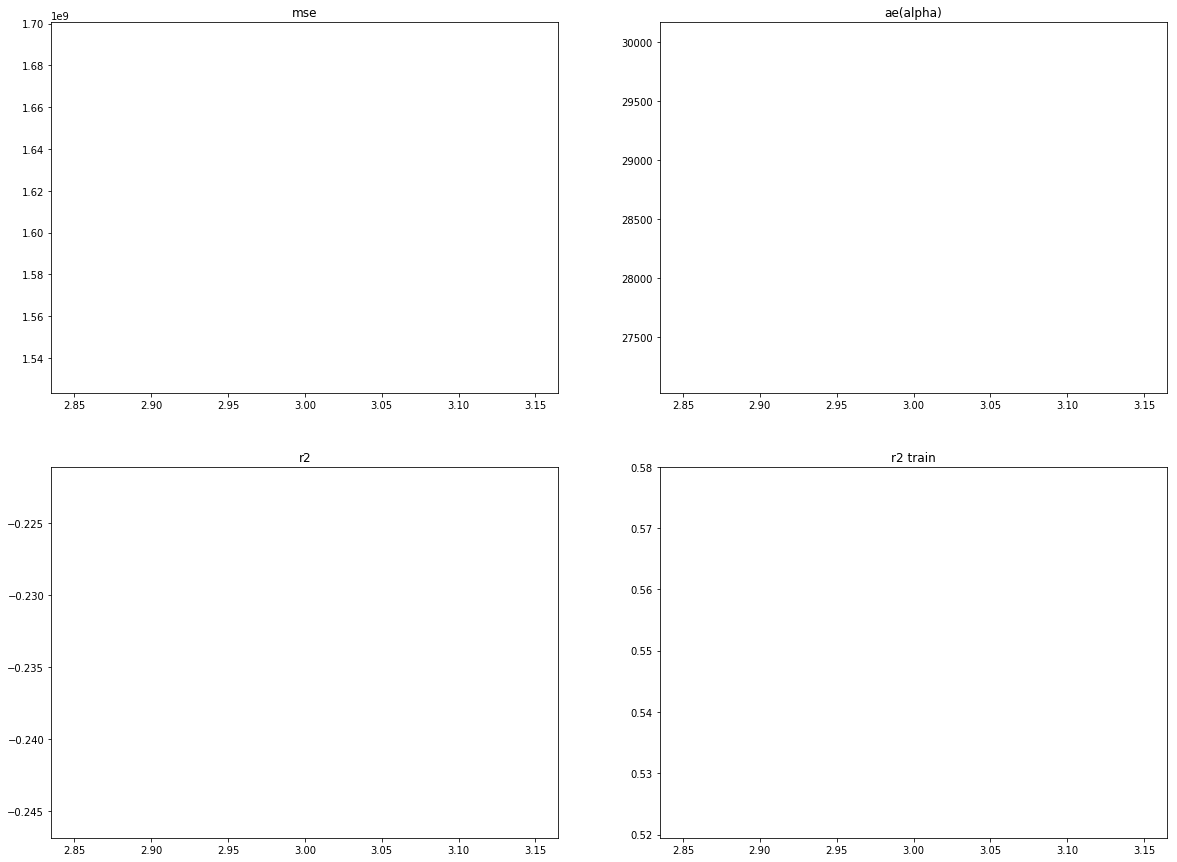

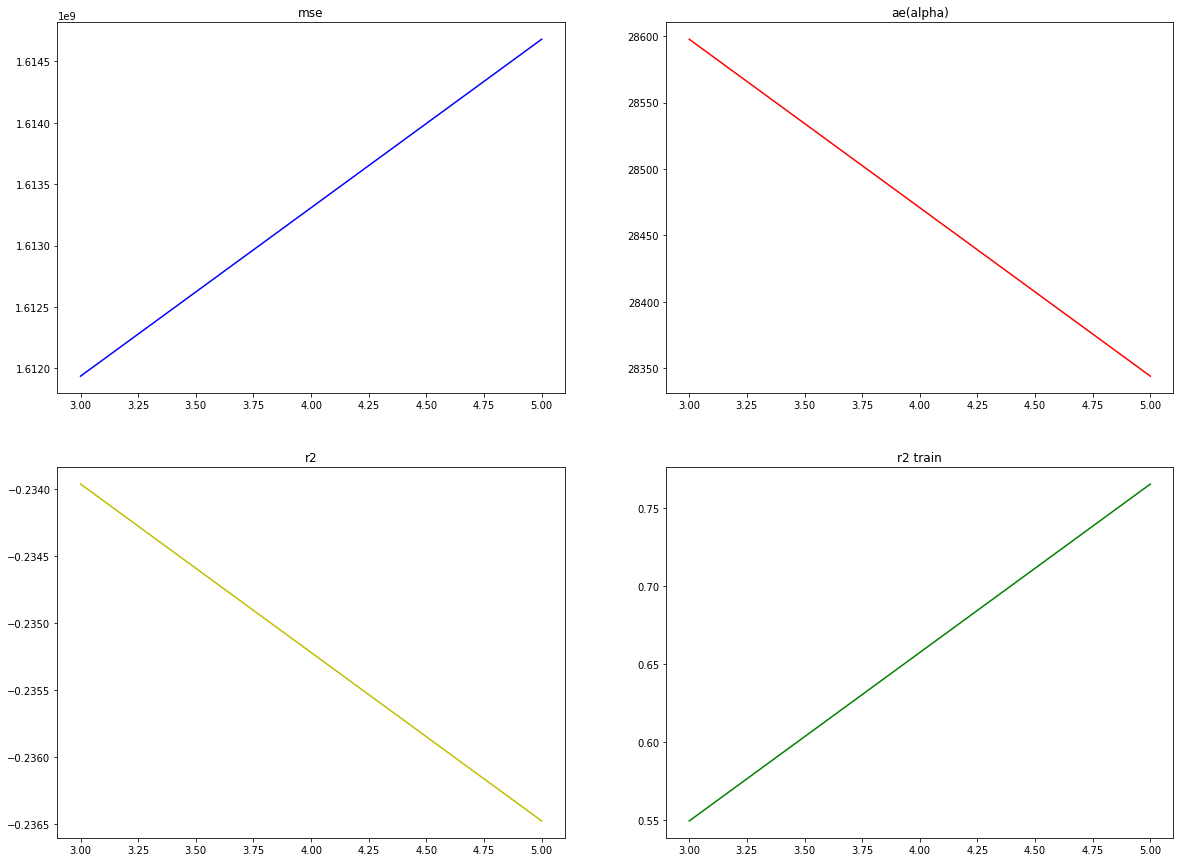

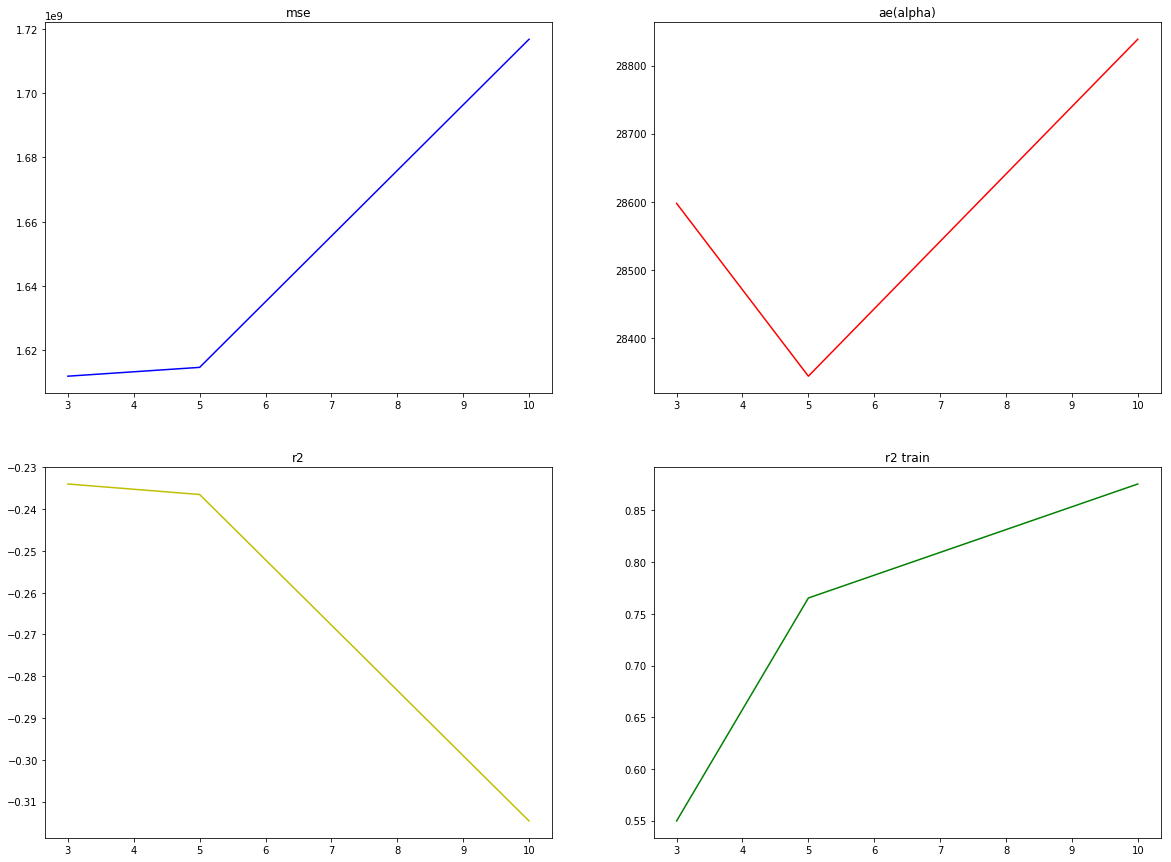

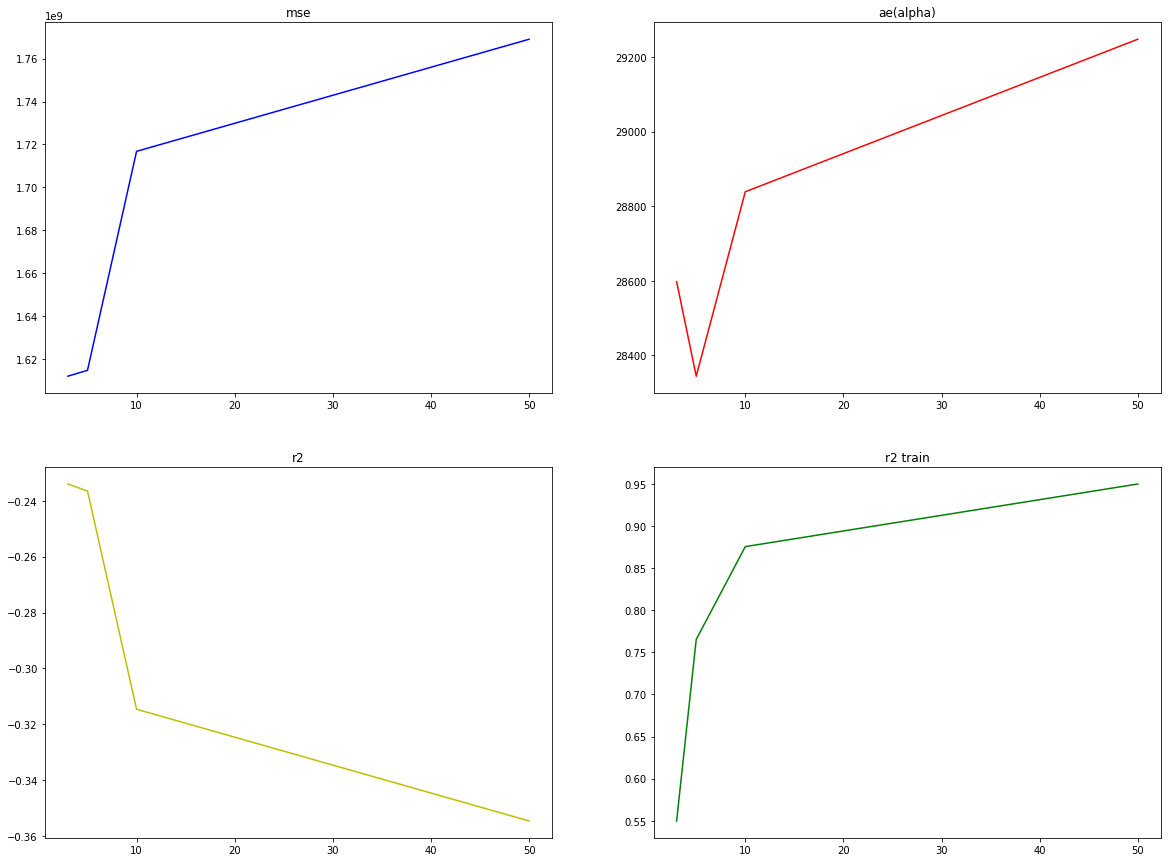

In [27]:
comp = [3,5,10,50, 100, 1000]
mse_s = []
ae_s = []
r2_s = []
r2_train_s = []
for j,c in enumerate(comp):
    mse = []
    ae = []
    r2 = []
    r2_train = []
    for train_idx, test_idx in split.split(right_hm):
        X_train, X_test = right_hm[train_idx], right_hm[test_idx]
        y_train, y_test = wY[train_idx], wY[test_idx]
        mdl = PLSRegression(n_components=c)
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
        mse += [np.mean((y_pred - y_test)**2)]
        ae += [np.mean(abs(y_pred - y_test))]
        score_train = mdl.score(X_train, y_train)
        score_test = mdl.score(X_test, y_test)
        r2 += [score_test]
        r2_train += [score_train]
        print('MSE: {}, AE: {}'.format(mse[-1], ae[-1]))
        print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))
    clear_output()
    mse_s += [np.mean(mse)]
    ae_s += [np.mean(ae)]
    r2_s += [np.mean(r2)]
    r2_train_s += [np.mean(r2_train)]
    fig, ax = plt.subplots(2,2, figsize = (20,15))
    ax[0,0].plot(comp[:j+1], mse_s, c = 'b')
    ax[0,0].set_title('mse')
    
    ax[0,1].plot(comp[:j+1], ae_s, c = 'r')
    ax[0,1].set_title('ae(alpha)')
    
    ax[1,0].plot(comp[:j+1], r2_s, c = 'y')
    ax[1,0].set_title('r2')
    
    ax[1,1].plot(comp[:j+1],r2_train_s, c = 'g')
    ax[1,1].set_title('r2 train')    
    fig.show()

/home/ayagoz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


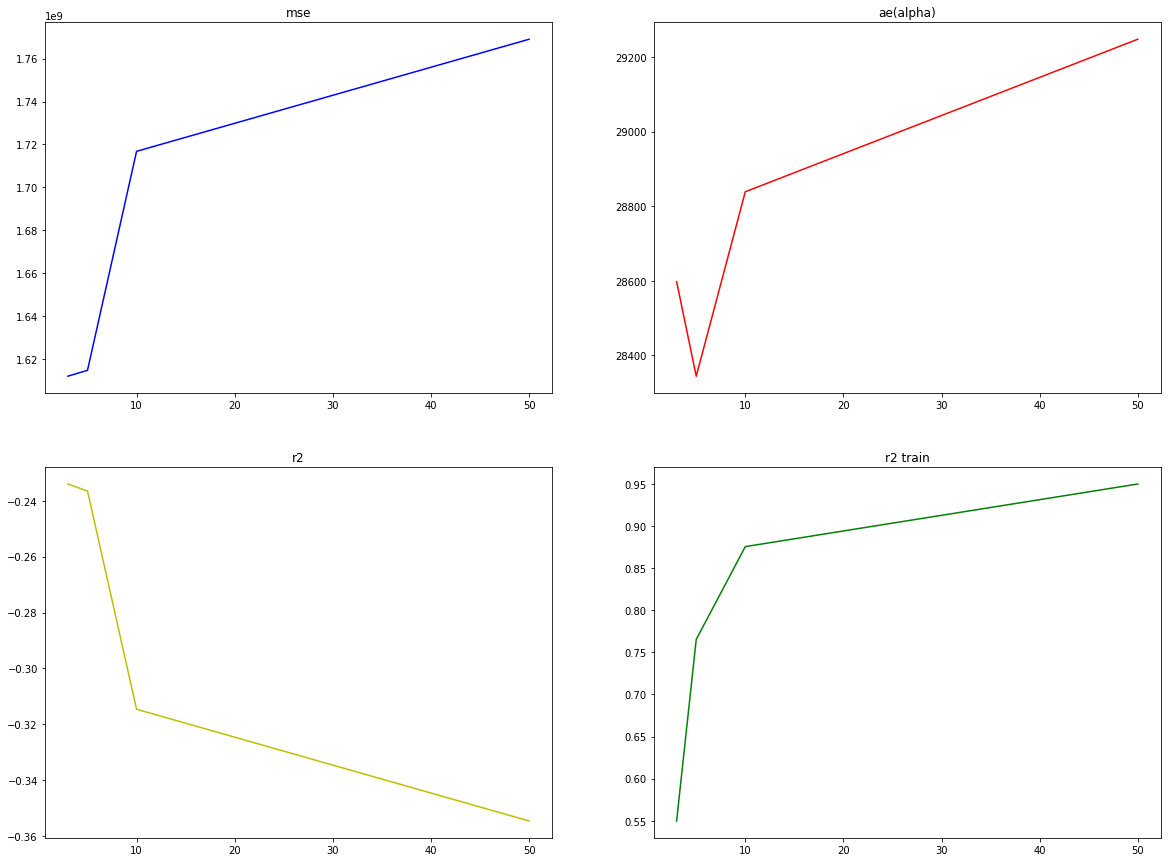

In [29]:
fig, ax = plt.subplots(2,2, figsize = (20,15))
ax[0,0].plot(comp[:4], mse_s, c = 'b')
ax[0,0].set_title('mse')

ax[0,1].plot(comp[:4], ae_s, c = 'r')
ax[0,1].set_title('ae(alpha)')

ax[1,0].plot(comp[:4], r2_s, c = 'y')
ax[1,0].set_title('r2')

ax[1,1].plot(comp[:4],r2_train_s, c = 'g')
ax[1,1].set_title('r2 train')    
fig.show()

In [ ]:
print()

In [30]:
print('alpha = ', alpha[i])
mse = []
ae = []
r2 = []
coef = []

for train_idx, test_idx in split.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = bY[train_idx], bY[test_idx]
    lasso = Lasso(alpha=alpha[-1], random_state=0)
    print('fit lasso')
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    mse += [np.mean((y_pred - y_test)**2)]
    ae += [np.mean(abs(y_pred - y_test))]
    score_train = r2_score(y_train, lasso.predict(X_train),multioutput='variance_weighted')
    score_test = r2_score(y_test, y_pred, multioutput='variance_weighted')
    r2 += [score_test]
    print('MSE: {}, AE: {}'.format(mse[-1], ae[-1]))
    print('R^2 score train: {}, R^2 score test: {}'.format(score_train, score_test))
    sparse_coef = np.squeeze(np.asarray(lasso.sparse_coef_.todense()))

    coef += [len(np.where(sparse_coef!=0)[0])]


NameError: name 'i' is not defined